# Table of contents
- [pre-check](#pre-check)
- [Kmeans clustering](#Kmeans-clustering)
    - [PCA reduction](#PCA-reduction)
    - [hyperparams selection](#hyperparams-selection)
    - [Kmeans clustering](#Kmeans-clustering)
- [cluster distribution across Kmeans groups](#cluster-distribution-across-Kmeans-groups)
    - [cell type distribution](#cell-type-distribution)
    - [At-Risk/ERA vs CON ratio](#At-Risk/ERA-vs-CON-ratio)
        - [statistical significance](#statistical-significance)
    - [G2 clusters ratio per cell type in CON and At-Risk/ERA](#G2-clusters-ratio-per-cell-type-in-CON-and-At-Risk/ERA)
        - [statistical significance per cell type](#statistical-significance-per-cell-type)
- [signature TFs, genes, pathways](#signature-TFs,-genes,-pathways)
    - [Kmeans group specific TFs](#Kmeans-group-specific-TFs)
        - [TF overlap](#TF-overlap)
    - [Kmeans group specific pathways](#Kmeans-group-specific-pathways)
        - [signature pathways across cell types](#signature-pathways-across-cell-types)
    - [top regulated genes](#top-regulated-genes)
- [heatmap](#heatmap)
    - [top Kmeans-specific TFs](#top-Kmeans-specific-TFs)
    - [all TFs](#all-TFs)
    - [sort by cell type](#sort-by-cell-type)
    - [participants in G2 across cell types](#participants-in-G2-across-cell-types)
    - [top signature TFs across cell types](#top-signature-TFs-across-cell-types)
- [session info](#session-info)

# pre-check

1. set up your own working directory. 
2. make sure the packages are installed: `RColorBrewer`, `ggplot2`, `dplyr`, `pheatmap`, `tibble`, `tidyr`, `amap`, `org.Hs.eg.db`, `clusterProfiler`, `enrichplot`, `ReactomePA`, `UpSetR`, `data.table`, `compositions`
3. make sure the following input files are inside:
    - `pr.csv`: original Taiji output file
    - `meta.csv`: meta data with cell type, disease state
    - `mycolors.rds`: color palette for meta data
    - `hclust_order_by_kmeans_hp.txt`: custom order of pseudobulk clusters
4. scripts are inside:
    - `findOptimal.R`: find optimal hyper-parameters for Kmeans clustering
    - `specificTFs_cell.R`: identify Kmeans group-specific TFs. Dependencies are `unpairedtTest.R`, `wilcoxonTest.R`
    - `utils.R`: some basic functions
    - `gsea.R`: GO analysis

In [1]:
# set working directory
maindir <- "/home/workspace/paper_figures_1031/" # needs to be modified
setwd(maindir)

ERROR: Error in setwd(maindir): cannot change working directory


In [2]:
# import functions
source('findOptimal.R')
source('specificTFs_cell.R')
source('utils.R')
source('gsea.R')

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("B

ERROR: Error in library(clusterProfiler): there is no package called ‘clusterProfiler’


In [6]:
# import libraries
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(pheatmap)
library(data.table)
library(compositions)


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second


Welcome to compositions, a package for compositional d

In [7]:
# set plot parameters, which is suitable for CNS publication
plot.format = theme(
    plot.background=element_blank(),
    panel.grid=element_blank(),
    panel.background=element_blank(),
    panel.border=element_rect(color="black", linewidth=0.5, fill=NA),
    axis.line=element_blank(),
    axis.ticks=element_line(color="black",linewidth=0.5),
    axis.text=element_text(color="black", size=7),
    axis.title=element_text(color="black", size=7),
    plot.title=element_text(color="black", size=7),
    legend.background=element_blank(),
    legend.key=element_blank(),
    legend.text=element_text(color="black", size=7),
    legend.title=element_text(color="black", size=7))

In [5]:
# set cell types of interest
selected_cell_states <- c("B intermediate","B memory", "B naive", "CD14 Mono", "CD16 Mono","CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","MAIT","NK","NK_CD56bright","Treg")
length(selected_cell_states)

[1] 13

In [14]:
# prepare input
pr <- read.csv('pr.csv', row.names = 1)
pr_normed <- scaleData(pr) ## normalize data across rows to make sure the values is in range [0,1] after norm
pr_normed2 <- zscore(pr) ## zscore of pagerank row-wise
meta <- read.csv('meta.csv', row.names = 1)
dim(meta)
dim(pr)
# col_orders <- readLines('hclust_order_by_kmeans_hp.txt') ## hclust order of clusters for heatmap

[1] 1610   21

[1] 1077 1610

In [7]:
# load customized color palette
mycolors <- readRDS('mycolors.rds')
mycolors

$subject.id
   BR1001    BR1005    BR1008    BR1009    BR1013    BR1019    BR1024    BR1025 
"#1B9E77" "#F1E2CC" "#A6D854" "#80B1D3" "#4DAF4A" "#666666" "#E78AC3" "#B3B3B3" 
   BR1031    BR1034    BR1043    BR2003    BR2005    BR2008    BR2009    BR2010 
"#CCEBC5" "#BEBADA" "#FBB4AE" "#B3E2CD" "#FF7F00" "#984EA3" "#E41A1C" "#FB9A99" 
   BR2015    BR2018    BR2021    BR2024    BR2034    BR2035    BR2036    BR2037 
"#FFFF99" "#FED9A6" "#DECBE4" "#FFFF33" "#8DD3C7" "#BC80BD" "#FFED6F" "#FDBF6F" 
   BR2041    CU1001    CU1002    CU1003    CU1004    CU1005    CU1007    CU1008 
"#FFFF99" "#CAB2D6" "#7570B3" "#FB8072" "#33A02C" "#377EB8" "#8DA0CB" "#7FC97F" 
   CU1009    CU1010    CU1012    CU1013    CU1019    CU1020    CU1021    CU1022 
"#66A61E" "#999999" "#FFFFCC" "#A6761D" "#FFFFB3" "#FFD92F" "#FCCDE5" "#B2DF8A" 
   CU1029    CU1030    CU1031    CU1032    CU1033    CU1034    CU1035    CU1039 
"#FDDAEC" "#E6F5C9" "#1F78B4" "#6A3D9A" "#A6CEE3" "#FDC086" "#B3DE69" "#FF7F00" 
   CU1044    CU1056    CU1058    CU1059    CU1064    CU1065    CU1066    CU1067 
"#A65628" "#CBD5E8" "#F4CAE4" "#FFF2AE" "#E5D8BD" "#D95F02" "#E7298A" "#E6AB02" 
   CU1069    CU1070    CU1072    CU1075    CU1077    CU1078    SD1001    SD1003 
"#CCEBC5" "#CCCCCC" "#66C2A5" "#BEAED4" "#F0027F" "#E5C494" "#F2F2F2" "#E31A1C" 
   SD1006    SD1007    SD1012 
"#B3CDE3" "#666666" "#F781BF" 

$cell.type
   B intermediate          B memory           B naive         CD14 Mono 
        "#9E0142"         "#B81E48"         "#D23B4E"         "#E25249" 
        CD16 Mono         CD4 Naive CD4 Proliferating           CD4 TCM 
        "#F16844"         "#F7854E"         "#FBA45C"         "#FDBE6E" 
          CD4 TEM         CD8 Naive           CD8 TCM           CD8 TEM 
        "#FDD683"         "#FEE899"         "#FEF7B2"         "#F9FCB5" 
             cDC2             Eryth               gdT              HSPC 
        "#EDF7A3"         "#DAF09A"         "#BEE5A0"         "#A1D9A4" 
             MAIT                NK     NK_CD56bright               pDC 
        "#80CCA4"         "#61BCA7"         "#48A0B2"         "#3485BB" 
      Plasmablast              Treg 
        "#496AAE"         "#5E4FA2" 

$subject.group
    Converter           ERA           CON Non-converter 
    "#377EB8"     "#E41A1C"     "#4DAF4A"     "#984EA3" 

$subject.group2
        CON At-Risk/ERA 
  "#4DAF4A"   "#FF7F00" 

$subject.group3
      ERA       CON   At-Risk 
"#E41A1C" "#4DAF4A" "#FFFF33" 

$TF.group
       G1        G2        G3        G4        G5 
"#66C2A5" "#FC8D62" "#8DA0CB" "#E78AC3" "#A6D854" 

$kmeans
       G1        G2        G3        G4        G5        G6 
"#66C2A5" "#FC8D62" "#8DA0CB" "#E78AC3" "#A6D854" "#FFD92F" 

$kmeans2
       G2     other 
"#FC8D62" "#808080" 

$celltype2
 B memory   B naive CD14 Mono CD16 Mono CD4 Naive CD8 Naive   CD4 TCM   CD8 TEM 
"#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F" "#FF7F00" 
     MAIT        NK      Treg 
"#CAB2D6" "#6A3D9A" "#FFFF99"

## feature filtering

In [11]:
features <- rownames(pr)
length(features)

[1] 1077

In [1078]:
outlier_f <- find_outlier_feature(pr, iqr_multiplier = 100, sample_threshold = 2)

In [1079]:
length(outlier_f)

[1] 71

In [1080]:
rownames(pr)[outlier_f]

[1] "ALX4"    "ARX"     "ASCL1"   "ATOH7"   "BARX1"   "BHLHE22" "CDX2"   
 [8] "DBX1"    "DBX2"    "DLX3"    "DLX5"    "DLX6"    "DMRT1"   "DMRTA2" 
[15] "DUX4"    "EN1"     "FOXA1"   "FOXA2"   "FOXC2"   "FOXD3"   "FOXD4L6"
[22] "FOXE1"   "FOXI1"   "FOXI2"   "FOXP2"   "FOXR1"   "GCM2"    "HAND2"  
[29] "HMGA2"   "HMX3"    "HOXB13"  "HOXB8"   "HOXC6"   "HOXC8"   "HOXC9"  
[36] "HOXD1"   "HSFX1"   "IRX3"    "IRX5"    "MNX1"    "NHLH2"   "NKX2-2" 
[43] "NKX2-5"  "NOTO"    "NR2E1"   "NR2F1"   "OTP"     "OTX1"    "OTX2"   
[50] "PITX2"   "PITX3"   "POU1F1"  "POU2AF1" "PROP1"   "PTF1A"   "RAX"    
[57] "RHOXF1"  "RHOXF2B" "RXRG"    "SOX10"   "SOX2"    "SP9"     "TBX2"   
[64] "TBX20"   "TFAP2D"  "TFCP2L1" "UNCX"    "WT1"     "ZBTB20"  "ZNF423" 
[71] "ZNF479"

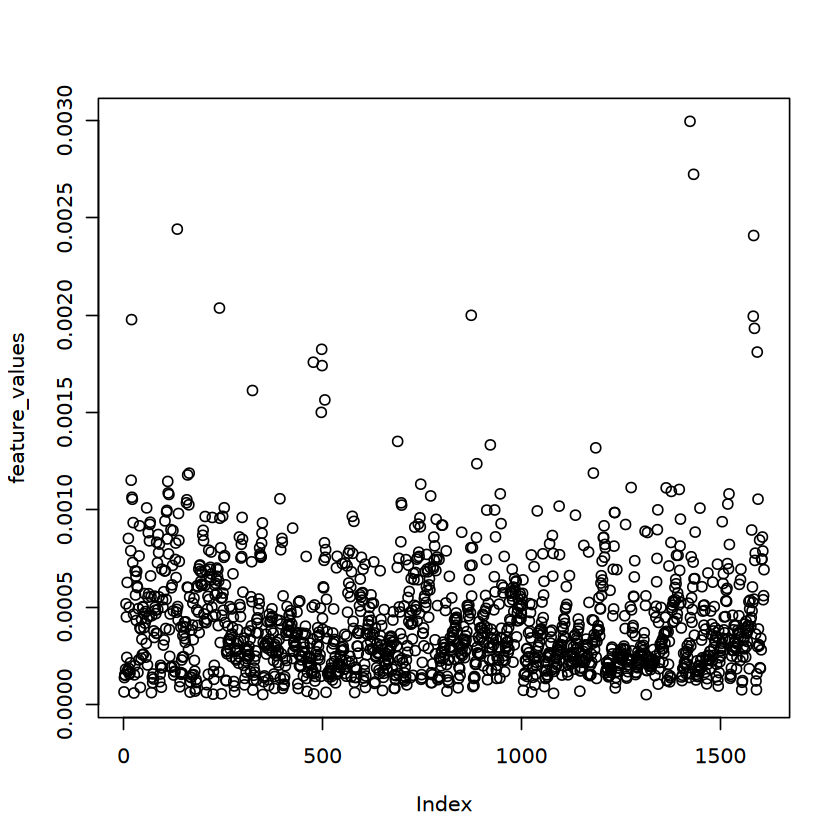

In [13]:
feature_values <- as.matrix(pr)['TFAP2A',]
plot(feature_values)

In [1134]:
writeLines(rownames(pr)[outlier_f], 'outlier_TFs_iqr100_s2.txt')

In [8]:
outlier_f <- readLines('outlier_TFs_iqr100_s2.txt')
pr <- read.csv('pr_1031.csv', row.names = 1)
pr <- pr[setdiff(rownames(pr),outlier_f),]
pr_normed2 <- zscore(pr) ## zscore of pagerank row-wise
dim(pr_normed2)

[1] 1006 1610

In [9]:
# writeLines(rownames(pr_normed2), 'TFs_1031_1006TFs.txt')
write.table(pr_normed2, 'pr_normed2_1006TFs.tsv')


In [1054]:
# Calculate Q1, Q3, and IQR
q1 <- quantile(feature_values, 0.25)
q3 <- quantile(feature_values, 0.75)
iqr <- q3 - q1

In [1055]:
upper_bound <- q3+70*iqr
upper_bound

75% 
0.0008466602

In [1056]:
outlier_count <- sum(feature_values > upper_bound)
outlier_count

[1] 2

## cell counts

In [13]:
# calculate the total number of scRNA-seq cells and scATAC-seq cells
sum(meta$RNA_cells)
sum(meta$ATAC_cells)
total_cells <- sum(meta$RNA_cells) + sum(meta$ATAC_cells)
total_cells

[1] 703701

[1] 932986

[1] 1636687

In [14]:
# median of cells per cluster
tmp <- meta |> mutate(total_cells = RNA_cells + ATAC_cells)
median(tmp$total_cells)

[1] 766.5

In [15]:
# median of cells per sample
tmp <- meta |> mutate(total_cells = RNA_cells + ATAC_cells) |> group_by(subject.subjectGuid) |> summarize(n = sum(total_cells))
median(tmp$n)

[1] 25194

In [16]:
# percentage of each cell type
tmp <- meta |> mutate(total_cells = RNA_cells + ATAC_cells) |> group_by(preClust) |> summarize(n = sum(total_cells)) |> arrange(-n) |> mutate(pct=round(100*n/total_cells, 2))
sum(head(tmp, n= 13)$n)/total_cells # top 13 cell types total percentage
# tmp |> arrange(preClust)
tmp

[1] 0.9943789

preClust          n      pct  
1  CD4 Naive         420908 25.72
2  CD4 TCM           348757 21.31
3  CD14 Mono         181079 11.06
4  NK                175692 10.73
5  CD8 TEM           169064 10.33
6  B naive           138689  8.47
7  CD8 Naive          56811  3.47
8  MAIT               40183  2.46
9  B intermediate     29998  1.83
10 CD16 Mono          29436  1.80
11 B memory           22634  1.38
12 NK_CD56bright       9552  0.58
13 Treg                4684  0.29
14 cDC2                2585  0.16
15 CD4 TEM             2063  0.13
16 CD4 Proliferating   1486  0.09
17 pDC                  939  0.06
18 gdT                  713  0.04
19 Eryth                522  0.03
20 HSPC                 446  0.03
21 Plasmablast          283  0.02
22 CD8 TCM              163  0.01

### plot of cell type distribution across groups 

In [17]:
# across groups
tmp <- meta |> mutate(total_cells = RNA_cells + ATAC_cells) |> group_by(preClust, sample, subject.group3) |> summarize(n = sum(total_cells)) |> arrange(-n) 
# |> mutate(pct=round(100*n/total_cells, 2))
df4 <- tmp %>% filter(preClust %in% selected_cell_states) %>% dplyr::group_by(sample) %>% mutate(total=sum(n)) %>% dplyr::group_by(preClust) %>% mutate(per=round(100*n/total,2))

`summarise()` has grouped output by 'preClust', 'sample'. You can override
using the `.groups` argument.


In [18]:
head(df4)
dim(df4)

preClust  sample       subject.group3 n     total per  
1 CD4 Naive B112_PB00072 ERA            20153 34716 58.05
2 CD4 Naive B126_PB02970 CON            18673 30054 62.13
3 CD4 TCM   B040_PB00349 CON            18011 34635 52.00
4 CD4 Naive B126_PB02985 CON            17866 32268 55.37
5 CD4 Naive B112_PB00107 At-Risk        17742 31743 55.89
6 CD4 TCM   B126_PB02953 CON            17528 28500 61.50

[1] 545   6

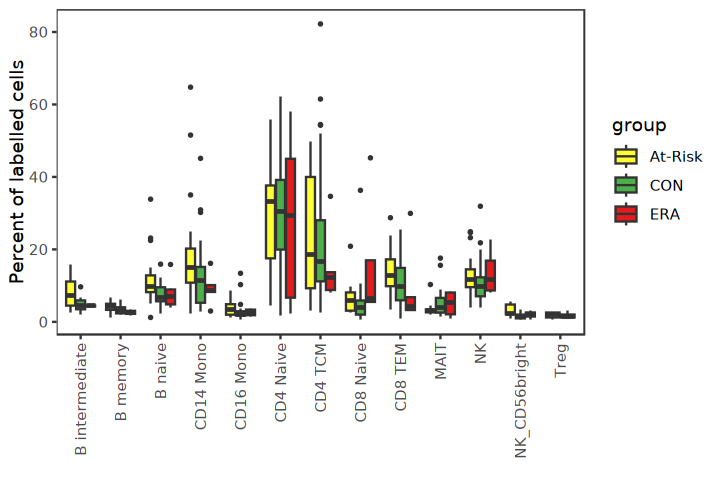

In [22]:
options(repr.plot.width = 6, repr.plot.height = 4)
p <- ggplot(df4, aes(x = preClust, y = per, fill = subject.group3)) +
    geom_boxplot(outlier.size = 0.5) +
    # geom_dotplot(binaxis='y', stackdir='center', position = position_dodge(1), dotsize = 0.1)+
    labs(x = "", y = "Percent of labelled cells") +
    scale_fill_manual(name="group",values = mycolors$subject.group3) +
    theme_bw() +
    theme(
      panel.grid.minor.x = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
    )
p

In [28]:
pdf("13_cell_states_dist_3_groups.pdf", width=4.5, height=3.5)
print(p)
dev.off()

pdf 
  2

### statistical test

We applied CLR (Centered Log-Ratio) transformation to handle compositional contraints of compositional data, such as percentages that sum to 100%.Then we performed standard statistical tests like Kruskal-Wallis test.

In [23]:
comp_data <- meta |> mutate(total_cells = RNA_cells + ATAC_cells) |> filter(preClust %in% selected_cell_states)|> group_by(preClust, sample) |> summarize(n = sum(total_cells)) |> arrange(-n) |> 
    tidyr::pivot_wider(names_from = 'preClust', values_from = 'n', values_fill = 0) |> tibble::column_to_rownames('sample')
comp_data <- comp_data/rowSums(comp_data)

# CLR transformation
clr_data <- clr(comp_data)
head(comp_data)
head(clr_data)

`summarise()` has grouped output by 'preClust'. You can override using the
`.groups` argument.


CD4 Naive  CD4 TCM    CD14 Mono  CD8 Naive  CD8 TEM    B naive   
B112_PB00072 0.58051043 0.08085609 0.10145178 0.00000000 0.03197373 0.05671736
B126_PB02970 0.62131497 0.16843016 0.00000000 0.04119252 0.03600186 0.07692820
B040_PB00349 0.02179876 0.52002310 0.15377508 0.02174101 0.10633752 0.05428035
B126_PB02985 0.55367547 0.10360109 0.14525226 0.00000000 0.03672369 0.02361473
B112_PB00107 0.55892638 0.11441893 0.00000000 0.03090445 0.04252906 0.05708345
B126_PB02953 0.02077193 0.61501754 0.03203509 0.02259649 0.03989474 0.06961404
             NK         MAIT       B intermediate B memory   CD16 Mono  
B112_PB00072 0.08753889 0.01013942 0.00000000     0.01811845 0.032693859
B126_PB02970 0.04684901 0.00000000 0.00000000     0.00000000 0.000000000
B040_PB00349 0.07596362 0.02760214 0.00000000     0.00000000 0.018478418
B126_PB02985 0.09628734 0.00000000 0.00000000     0.00000000 0.021941242
B112_PB00107 0.10285732 0.00000000 0.00000000     0.06744794 0.000000000
B126_PB02953 0.08722807 0.02136842 0.05894737     0.00000000 0.006350877
             Treg       NK_CD56bright
B112_PB00072 0.00000000 0.000000000  
B126_PB02970 0.00000000 0.009283290  
B040_PB00349 0.00000000 0.000000000  
B126_PB02985 0.00000000 0.018904178  
B112_PB00107 0.02583247 0.000000000  
B126_PB02953 0.01649123 0.009684211

              CD4 Naive   CD4 TCM   CD14 Mono  CD8 Naive    CD8 TEM     B naive
B112_PB00072  2.3581535 0.3869166  0.61382931  0.0000000 -0.5408397  0.03232610
B126_PB02970  2.2492374 0.9439205  0.00000000 -0.4643440 -0.5990300  0.16027176
B040_PB00349 -0.9932525 2.1787677  0.96038554 -0.9959050  0.5915127 -0.08094317
B126_PB02985  2.1545813 0.4785505  0.81647460  0.0000000 -0.5585753 -1.00012684
B112_PB00107  2.0275406 0.4413893  0.00000000 -0.8675769 -0.5482895 -0.25396292
B126_PB02953 -0.5079053 2.8801430 -0.07467605 -0.4237132  0.1447366  0.70145836
                     NK       MAIT B intermediate    B memory  CD16 Mono
B112_PB00072  0.4663288 -1.6893238      0.0000000 -1.10882372 -0.5185671
B126_PB02970 -0.3356709  0.0000000      0.0000000  0.00000000  0.0000000
B040_PB00349  0.2551491 -0.7572123      0.0000000  0.00000000 -1.1585021
B126_PB02985  0.4053395  0.0000000      0.0000000  0.00000000 -1.0736293
B112_PB00107  0.3348656  0.0000000      0.0000000 -0.08712111  0.0000000
B1

In [24]:
# get disease group
disease_groups <- meta |> distinct(sample, subject.group3) |> arrange(factor(sample, levels=rownames(clr_data))) |> pull(subject.group3)
disease_groups <- factor(disease_groups, labels = c('ERA','At-Risk', 'CON'))

In [25]:
# perform Kruskal-Wallis test for each cell type
kruskal_test <- function(data) {
  results <- sapply(1:ncol(data), function(i) {
    test <- kruskal.test(data[,i] ~ disease_groups)
    c(statistic = test$statistic, p.value = test$p.value)
  })
  rownames(results) <- c("statistic", "p.value")
  colnames(results) <- colnames(data)
  return(results)
}

In [26]:
clr_results <- kruskal_test(clr_data)
clr_results[,selected_cell_states]

B intermediate B memory  B naive   CD14 Mono CD16 Mono CD4 Naive
statistic 4.5171873      6.5677673 0.4767190 0.0342118 1.1116485 2.1790918
p.value   0.1044973      0.0374824 0.7879194 0.9830396 0.5735993 0.3363692
          CD8 Naive CD4 TCM   CD8 TEM   MAIT      NK        NK_CD56bright
statistic 1.5703468 1.7105048 2.2268238 1.0547172 3.8192995 5.02619920   
p.value   0.4560406 0.4251759 0.3284365 0.5901618 0.1481323 0.08101673   
          Treg     
statistic 1.1503173
p.value   0.5626156

## purity distribution

In [29]:
# statistics of purity scores
mean(meta$purity)
sd(meta$purity)

[1] 0.7151988

[1] 0.1919344

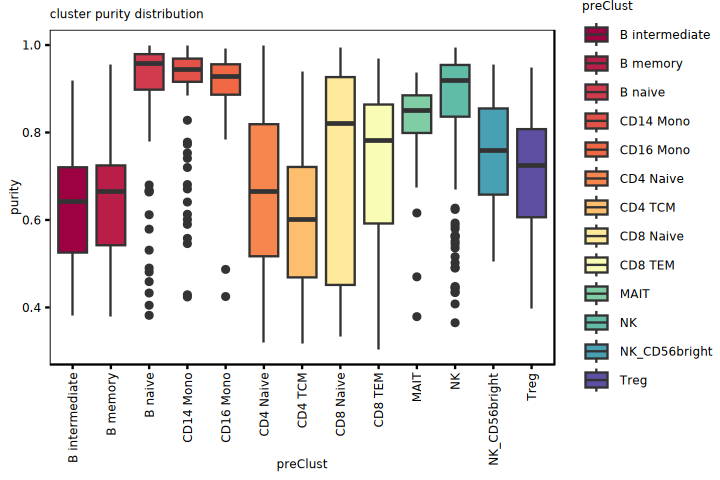

In [33]:
p1 <- ggplot(meta|>filter(preClust%in%selected_cell_states), aes(x=preClust, y=purity, fill=preClust))+
    geom_boxplot()+
    scale_fill_manual(values = mycolors$cell.type)+
    ggtitle("cluster purity distribution")+
    theme(
      axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
    )+plot.format
p1

In [34]:
# cluster purity distribution across kmeans
pdf("purity_across_13_cell_types.pdf",width = 5, height = 3.5)
print(p1)
dev.off()

pdf 
  2

In [32]:
# T cell subsets whose purity scores are less than 0.8
meta |> filter(preClust %in% selected_cell_states) |> group_by(preClust) |> summarise(mean=mean(purity), sd=sd(purity)) |> filter(mean<0.8 & grepl('T|CD4|CD8', preClust)) |> summarise(n=mean(mean),m=mean(sd))

n        m        
1 0.681376 0.1777992

In [35]:
# cell subsets whose purity scores are larger than 0.8
meta |> filter(preClust %in% selected_cell_states) |> group_by(preClust) |> summarise(mean=mean(purity), sd=sd(purity)) |> filter(mean>=0.8) |> summarise(n=mean(mean),m=mean(sd))

n        m        
1 0.871993 0.1339529

In [111]:
meta <- read.csv('meta_kmeans_5.csv', row.names = 1) 
head(meta)
dim(meta)

preClust  cluster purity cells RNA_cells ATAC_cells sample      
1 CD14 Mono C1      0.940  5329  4327      1002       B001_PB00001
2 NK        C2      0.873  1946  1391       555       B001_PB00001
3 B naive   C3      0.946  1830  1511       319       B001_PB00001
4 MAIT      C4      0.840  1588  1200       388       B001_PB00001
5 CD16 Mono C5      0.425  1062   392       670       B001_PB00001
6 CD4 TCM   C6      0.726  1059   104       955       B001_PB00001
  id              sample.visitName subject.biologicalSex ⋯ cohort.cohortGuid
1 B001_PB00001_C1 Flu Year 1 Day 0 Female                ⋯ BR1              
2 B001_PB00001_C2 Flu Year 1 Day 0 Female                ⋯ BR1              
3 B001_PB00001_C3 Flu Year 1 Day 0 Female                ⋯ BR1              
4 B001_PB00001_C4 Flu Year 1 Day 0 Female                ⋯ BR1              
5 B001_PB00001_C5 Flu Year 1 Day 0 Female                ⋯ BR1              
6 B001_PB00001_C6 Flu Year 1 Day 0 Female                ⋯ BR1              
  subject.age sample.sampleKitGuid sample.visitDetails            
1 36          KT00001              N/A - Flu-Series Timepoint Only
2 36          KT00001              N/A - Flu-Series Timepoint Only
3 36          KT00001              N/A - Flu-Series Timepoint Only
4 36          KT00001              N/A - Flu-Series Timepoint Only
5 36          KT00001              N/A - Flu-Series Timepoint Only
6 36          KT00001              N/A - Flu-Series Timepoint Only
  sample.daysSinceFirstVisit subject.race subject.group subject.group2
1 0                          Caucasian    CON           CON           
2 0                          Caucasian    CON           CON           
3 0                          Caucasian    CON           CON           
4 0                          Caucasian    CON           CON           
5 0                          Caucasian    CON           CON           
6 0                          Caucasian    CON           CON           
  subject.group3 kmeans
1 CON            G1    
2 CON            G3    
3 CON            G5    
4 CON            G3    
5 CON            G1    
6 CON            G2

[1] 1613   22

In [113]:
meta |> group_by(kmeans) |> summarise(mr = mean(RNA_cells), ma = mean(ATAC_cells), mp = mean(purity))

kmeans mr        ma       mp       
1 G1     978.32432 532.1892 0.8172500
2 G2      65.87473 409.0440 0.7000440
3 G3     684.66786 606.0071 0.7906286
4 G4     383.01010 697.8939 0.6299226
5 G5     812.03676 608.4191 0.7782721

In [206]:
# after applying RNA_cells>=80
meta2 |> group_by(kmeans) |> summarise(mr = mean(RNA_cells), ma = mean(ATAC_cells), mp = mean(purity))

kmeans mr        ma       mp       
1 G1      491.5615 767.7487 0.6282846
2 G2      745.0703 640.0977 0.7950000
3 G3      145.1104 517.3015 0.6403970
4 G4      880.7360 645.1360 0.7700720
5 G5     1153.1339 573.3543 0.8018268

In [120]:
meta2 <- meta |> filter(RNA_cells>=80) 
write.csv(meta2,"meta_kmeans_5_RNA_cells_min_80.csv")
# meta |> filter(RNA_cells>=20) |> group_by(kmeans) |> summarise(mr = mean(RNA_cells), ma = mean(ATAC_cells), mp = mean(purity))

In [123]:
write.csv(pr[,meta2$id], 'pr_RNA_cells_min_80.csv')

In [38]:
atac <- read.delim('../output_20230310/ATACSeq/GeneQuant/expression_profile.tsv', row.names=1)

In [39]:
atac_tf <- atac[rownames(pr),names(pr)]
head(atac_tf)
dim(atac_tf)

B001_PB00001_C1 B001_PB00001_C2 B001_PB00001_C3 B001_PB00001_C4
AC023509.3 31.0133530      42.53764032     37.2830781      49.4021165     
AHR         0.1702160       0.00000000      0.0000000       0.1310401     
AIRE        1.3106631       0.45454291      0.6252927       0.4586403     
ALX3        2.8085638       0.30302860      5.6276344       1.3104010     
ALX4        0.4085184       0.64393578      2.2666861       0.2620802     
AR          1.0212959       0.07575715      0.0000000       0.0000000     
           B001_PB00001_C5 B001_PB00001_C6 B001_PB00001_C7 B001_PB00001_C8
AC023509.3 34.28613315     43.1922602      44.2359804      45.20533000    
AHR         0.05911402      0.3997106       0.1475352       0.05821678    
AIRE        2.30544688      0.6113221       0.9835682       0.17465034    
ALX3        2.80791608      1.9280160       2.3113853       0.43662585    
ALX4        0.79803931      0.4702478       1.5245307       0.49484263    
AR          0.79803931      0.1410743       0.1229460       0.08732517    
           B001_PB00001_C9 B001_PB00001_C10 ⋯ B131_PB00369_C10 B131_PB00369_C12
AC023509.3 47.6608417      36.4595127       ⋯ 96.2177101       89.4147937      
AHR         0.1578174       0.2952187       ⋯  0.0000000        0.0000000      
AIRE        1.1573273       0.4428281       ⋯  0.3614942        0.7863110      
ALX3        1.4729620       2.8783826       ⋯  0.9639846        0.8424761      
ALX4        0.4471492       1.6237030       ⋯  0.9639846        0.4493206      
AR          0.2104231       0.0000000       ⋯  0.0000000        0.0000000      
           B131_PB00369_C13 B131_PB00369_C14 B131_PB00369_C15 B131_PB00369_C16
AC023509.3 86.1988541       64.09629419      97.2265662       97.5177502      
AHR         0.0000000        0.08655813       0.0000000        0.0000000      
AIRE        0.4082835        0.43279064       0.6368552        0.0000000      
ALX3        0.8676024        1.99083696       0.5660935        0.5548663      
ALX4        0.1020709        0.00000000       0.7076169        0.5548663      
AR          0.0000000        0.25967439       0.0000000        0.0000000      
           B131_PB00369_C17 B131_PB00369_C18 B131_PB00369_C19 B131_PB00369_C20
AC023509.3 100.7484220      74.6984846       89.4402147       74.5745482      
AHR          0.0000000       0.0000000        0.0000000        0.0000000      
AIRE         0.0000000       0.1138696        0.1269556        0.8076666      
ALX3         0.7254612       0.6832178        1.7773783        1.8845554      
ALX4         0.5440959       0.2277393        0.6347780        0.5384444      
AR           0.0000000       0.0000000        0.0000000        0.0000000

[1] 1078 1613

In [15]:
rna <- read.delim('../output_20230310/RNASeq/expression_profile.tsv', row.names=1)

In [21]:
pr <- read.table('pr.tsv', sep='\t')
rna_tf <- rna[rownames(pr),names(pr)]
head(rna_tf)
dim(rna_tf)

B001_PB00001_C1 B001_PB00001_C2 B001_PB00001_C3 B001_PB00001_C4
AC023509.3    7             0               0               1             
AHR        1465            31              14              37             
AIRE          4             0               5               0             
ALX3          2             1               2               1             
ALX4          0             0               0               0             
AR            2             1               0               0             
           B001_PB00001_C5 B001_PB00001_C6 B001_PB00001_C7 B001_PB00001_C8
AC023509.3   1             0                0              0              
AHR        252             9                7              5              
AIRE         0             5               16              0              
ALX3         1             0                0              0              
ALX4         0             0                0              0              
AR           1             0                0              0              
           B001_PB00001_C9 B001_PB00001_C10 ⋯ B131_PB00369_C10 B131_PB00369_C12
AC023509.3 0                1               ⋯ 0                 0              
AHR        3               15               ⋯ 9                 7              
AIRE       0                3               ⋯ 2                19              
ALX3       0                0               ⋯ 0                 0              
ALX4       0                0               ⋯ 0                 0              
AR         0                0               ⋯ 0                 0              
           B131_PB00369_C13 B131_PB00369_C14 B131_PB00369_C15 B131_PB00369_C16
AC023509.3 0                 0               0                0               
AHR        2                18               0                0               
AIRE       0                 0               0                0               
ALX3       0                 0               0                0               
ALX4       0                 0               0                0               
AR         0                 0               0                0               
           B131_PB00369_C17 B131_PB00369_C18 B131_PB00369_C19 B131_PB00369_C20
AC023509.3 0                 1               0                0               
AHR        4                13               1                1               
AIRE       2                 0               0                3               
ALX3       0                 0               0                0               
ALX4       0                 0               0                0               
AR         0                 0               0                0

[1] 1078 1613

In [26]:
sig_ids <- meta |> filter(kmeans=='G2') |> pull(id)
nosig_ids <- meta |> filter(kmeans!='G2') |> pull(id)
length(sig_ids)
length(nosig_ids)

[1] 455

[1] 1158

In [30]:
sig_tfs <- readLines('../output_20230310/post-analysis/cell_state_specific_TFs/kmeans/C2_p0.01_d0.5_gene433_wilcoxon_all.txt')
nosig_tfs <- setdiff(rownames(pr),sig_tfs)
length(sig_tfs)
length(nosig_tfs)

[1] 433

[1] 645

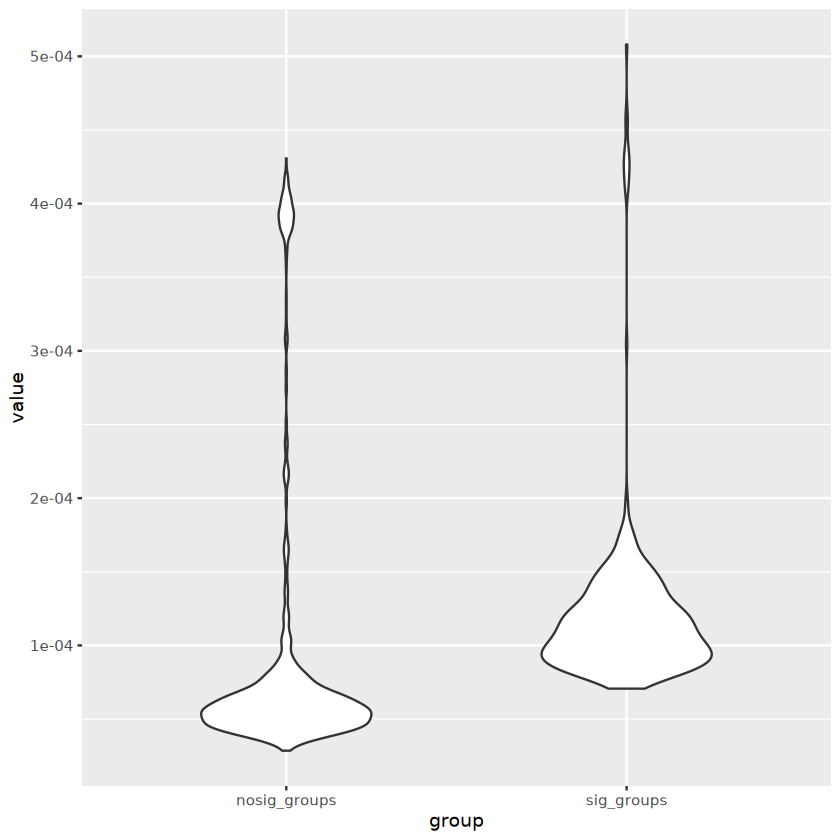

In [102]:
sig <- data.frame(value=colMeans(pr[sig_tfs,sig_ids]), group='sig_groups')
nosig <- data.frame(value=colMeans(pr[sig_tfs,nosig_ids]), group='nosig_groups')
dat <- rbind(sig,nosig)
ggplot(dat, aes(x=group, y=value))+geom_violin(scale='width', adjust=1, width=0.5)

In [183]:
(.42)**8*8

[1] 0.007746122

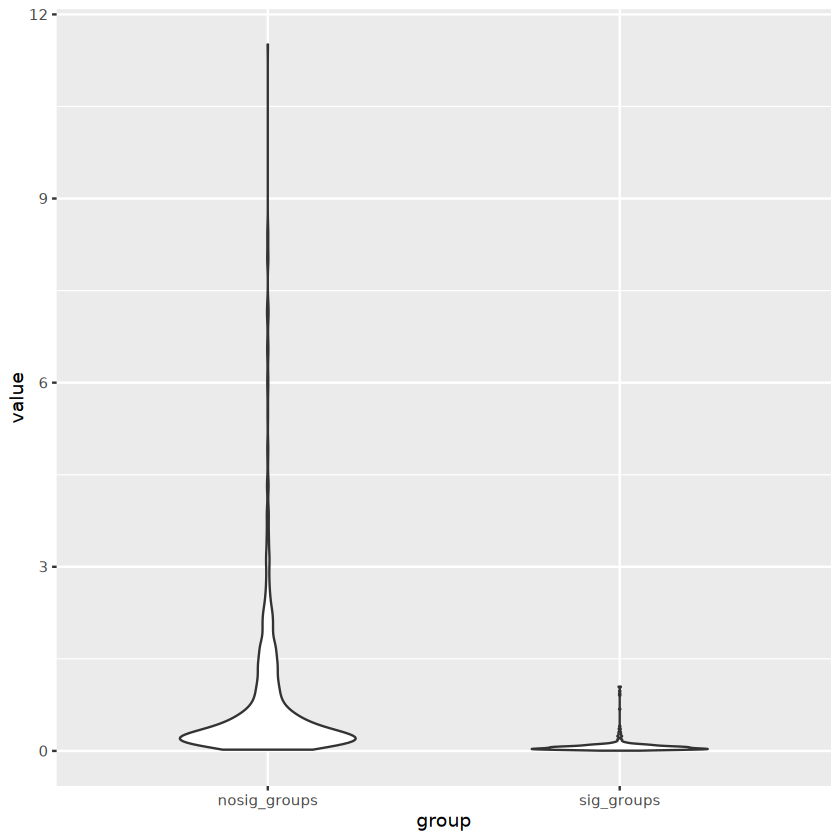

In [103]:
sig <- data.frame(value=colMeans(rna_tf[sig_tfs,sig_ids]), group='sig_groups')
nosig <- data.frame(value=colMeans(rna_tf[sig_tfs,nosig_ids]), group='nosig_groups')
dat <- rbind(sig,nosig)
ggplot(dat, aes(x=group, y=value))+geom_violin(scale='width', adjust=1, width=0.5)

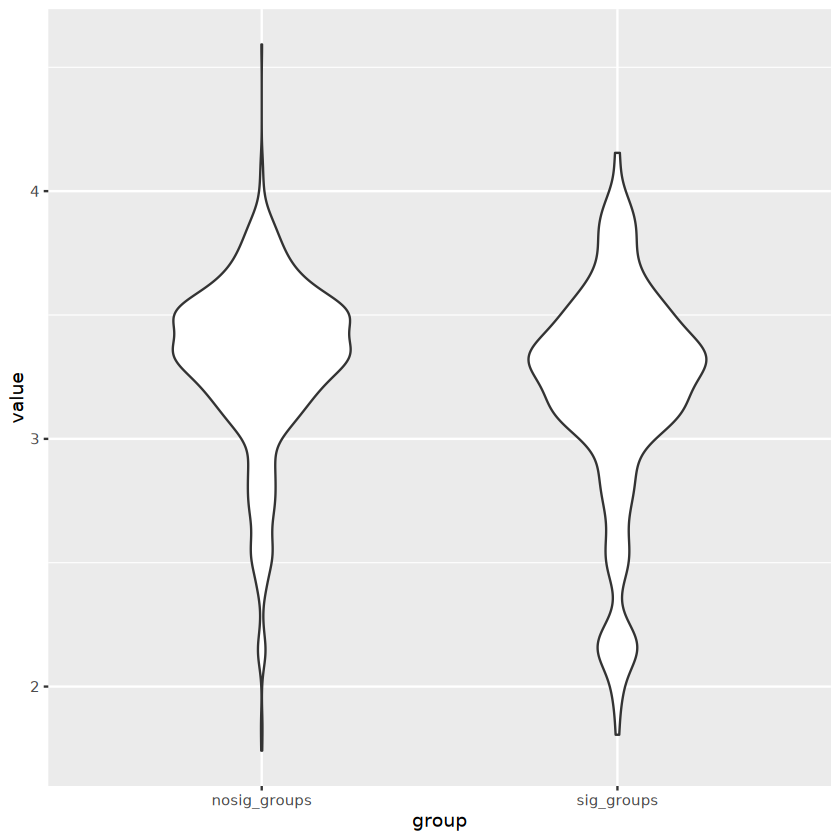

In [101]:
sig <- data.frame(value=colMeans(atac_tf[intersect(sig_tfs,rownames(atac_tf)),sig_ids]), group='sig_groups')
nosig <- data.frame(value=colMeans(atac_tf[intersect(sig_tfs,rownames(atac_tf)),nosig_ids]), group='nosig_groups')
dat <- rbind(sig,nosig)
ggplot(dat, aes(x=group, y=value))+geom_violin(scale='width', adjust=1, width=0.5)

In [ ]:
# plot(colMeans(atac_tf[nosig_tfs,sig_ids]))
plot(colMeans(rna_tf[nosig_tfs,sig_ids]))
# plot(colMeans(pr[nosig_tfs,sig_ids]))

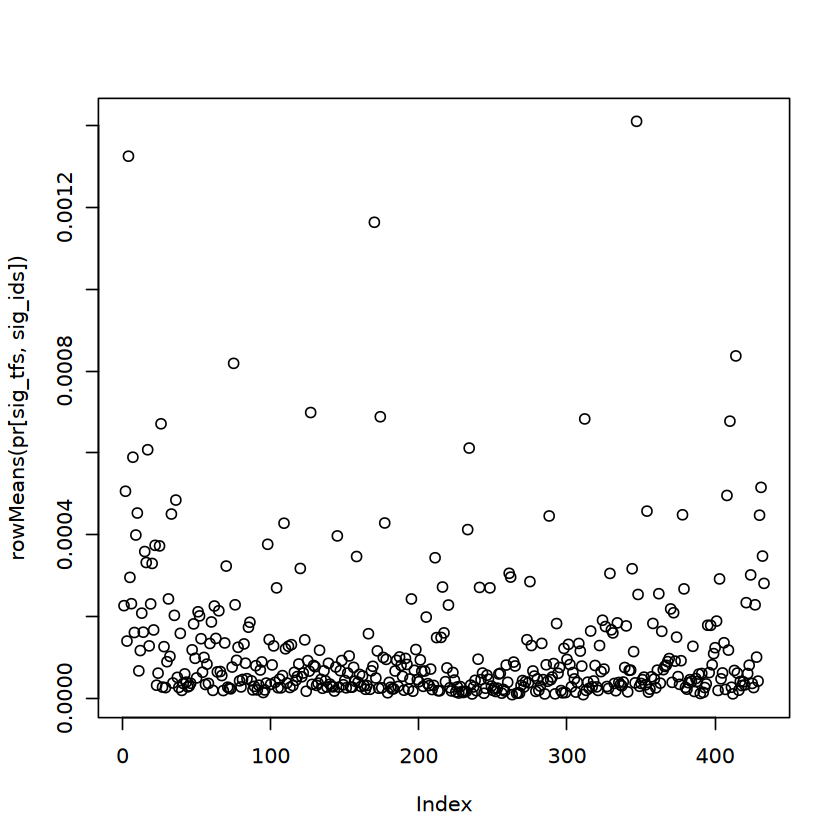

In [91]:
# plot(rowMeans(rna_tf[sig_tfs,sig_ids]))
plot(rowMeans(pr[sig_tfs,sig_ids]))

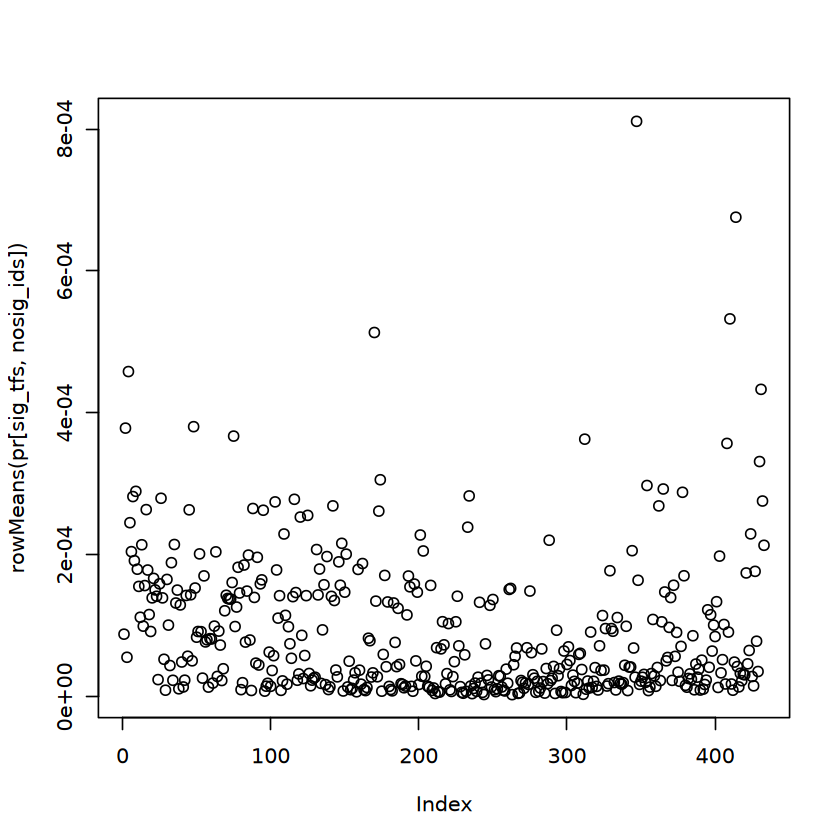

In [92]:
# plot(colMeans(atac_tf[intersect(sig_tfs,rownames(atac_tf)),nosig_ids]))
# plot(rowMeans(rna_tf[sig_tfs,nosig_ids]))
plot(rowMeans(pr[sig_tfs,nosig_ids]))

In [43]:
mean(colMeans(atac_tf[intersect(sig_tfs,rownames(atac_tf)),sig_ids]))
mean(colMeans(atac_tf[nosig_tfs,sig_ids]))

[1] 3.185823

[1] 20.42712

In [34]:
mean(colMeans(rna_tf[sig_tfs,sig_ids]))
mean(colMeans(rna_tf[nosig_tfs,sig_ids]))

[1] 0.07582164

[1] 8.533991

In [46]:
mean(colMeans(pr[sig_tfs,sig_ids]))
mean(colMeans(pr[nosig_tfs,sig_ids]))

[1] 0.0001206449

[1] 0.001170767

In [51]:
# pr_normed2[sig_tfs,sig_ids]
pr['ZNF304',sig_ids]

B001_PB00001_C6 B001_PB00001_C7 B001_PB00001_C9 B001_PB00001_C14
ZNF304 0.0001477035    0.0001724891    0.0002071637    0.0002860883    
       B001_PB00058_C8 B001_PB00058_C11 B001_PB00058_C12 B001_PB00058_C13
ZNF304 0.0002645309    0.0003923667     0.0001490906     0.0003673067    
       B001_PB00058_C15 B001_PB00058_C18 ⋯ B127_PB00436_C39 B127_PB00465_C22
ZNF304 0.0003668075     0.0003205897     ⋯ 0.0001860043     0.0001797588    
       B131_PB00369_C5 B131_PB00369_C9 B131_PB00369_C10 B131_PB00369_C13
ZNF304 0.0001585434    0.0002586547    0.0001598712     0.0001625101    
       B131_PB00369_C15 B131_PB00369_C16 B131_PB00369_C17 B131_PB00369_C19
ZNF304 0.0002545393     0.0002730596     0.0002208359     0.0002531206

In [52]:
pr_normed <- scaleData(pr) ## zscore of pagerank row-wise
mean(colMeans(pr_normed[sig_tfs,sig_ids]))
mean(colMeans(pr_normed[nosig_tfs,sig_ids]))

[1] 0.07055518

[1] 0.1305631

In [47]:
pr_normed2 <- zscore(pr) ## zscore of pagerank row-wise
mean(colMeans(pr_normed2[sig_tfs,sig_ids]))
mean(colMeans(pr_normed2[nosig_tfs,sig_ids]))

[1] 0.3548368

[1] -0.08360532

In [27]:
mean(colSums(rna_tf[,nosig_ids]))
mean(colSums(rna_tf[,sig_ids]))


[1] 63321.12

[1] 5537.255

# Kmeans clustering

The following inputs are needed for Kmeans clustering:
1. PageRank scores matrix, which is the output of Taiji. Each row is one TF, each column is one sample, and each cell is PageRank score. 
2. meta data of each sample. Typical meta data includes cell types, participant id, clinical status, etc.

## feature filtering

The first step is to prepare data for Kmeans clustering. Before PCA reduction, we need to filter the features since some features are outliers, i.e. some TFs have abnormally high scores in very few samples. We'll filter out these outliers using function `find_outlier_feature`.
1. `iqr_multiplier` determines the upper bound for outliers (default is 50)
2. `sample_threshold`: minimum number of samples that must exceed the upper bound for a feature to be considered an outlier (default is 2)

In [37]:
outlier_f <- find_outlier_feature(pr, iqr_multiplier = 100, sample_threshold = 3)
length(outlier_f)
rownames(pr)[outlier_f]

[1] 30

[1] "ALX4"    "ARX"     "ATOH7"   "BARX1"   "DBX1"    "DMRTA2"  "EN1"    
 [8] "FOXC2"   "FOXD4L6" "FOXE1"   "FOXI1"   "GCM2"    "HOXB8"   "HOXC8"  
[15] "HOXC9"   "IRX3"    "MNX1"    "NHLH2"   "NOTO"    "NR2F1"   "OTX2"   
[22] "POU1F1"  "PROP1"   "PTF1A"   "RHOXF2B" "RXRG"    "SOX10"   "TFAP2D" 
[29] "ZNF423"  "ZNF479"

In [39]:
outlier_tfs <- rownames(pr)[outlier_f]
writeLines(outlier_tfs, 'outlier_TFs_iqr100_s3.txt')

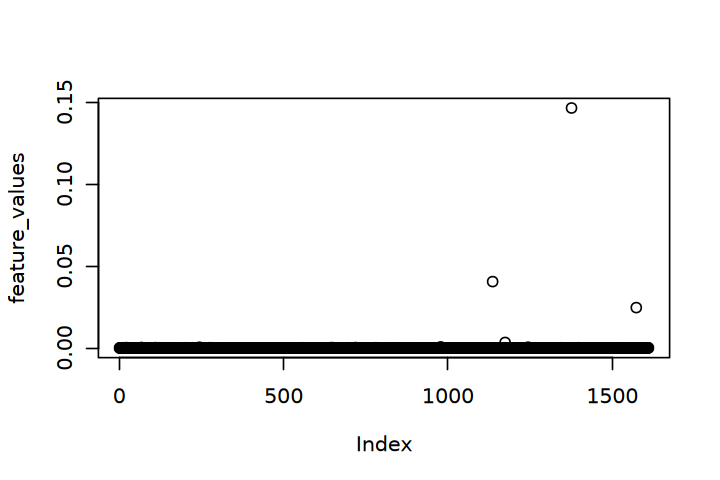

In [38]:
feature_values <- as.matrix(pr)['POU1F1',]
plot(feature_values)

## PCA reduction

Since we have too many dimensions for each sample, we need to perform PCA for dimension reduction. In the meantime, we can also visualize the first principal components (PCs) to check whether they're associated with meta data, like cell lineages or disease state.

In [40]:
tag <- "" # can be customized for different versions of result
pr <- pr[setdiff(rownames(pr),outlier_tfs),]
pr_normed2 <- zscore(pr) ## zscore of pagerank row-wise
dim(pr_normed2)

[1] 1047 1610

In [41]:
# load data first
data <- pr_normed2
dim(data)
head(data)

[1] 1047 1610

B001_PB00001_C1 B001_PB00001_C2 B001_PB00001_C3 B001_PB00001_C4
AC023509.3 -0.4905396      -0.8001815      -1.18511416     -0.03606539    
AHR         2.0877592      -0.4247451      -0.91064070     -0.53866663    
AIRE       -0.4244849      -0.6234658      -0.08764432     -0.62019964    
ALX3       -0.4986812      -0.4358823       0.14016249     -0.04138090    
AR         -0.1465723      -0.2280143      -0.72528891     -0.59253195    
ARID3A      1.8171293       0.3040975      -0.18984508     -0.09448736    
           B001_PB00001_C5 B001_PB00001_C6 B001_PB00001_C7 B001_PB00001_C8
AC023509.3 -0.2113944      -0.49138623     -0.28549801     -1.0162713     
AHR         3.0042014       0.27855176      0.49430528     -0.8448511     
AIRE       -0.5924162       1.31133960      4.09419312     -0.5202893     
ALX3        0.1883957       0.01105456     -0.09597051     -0.5318990     
AR          0.3426223       0.27717039      0.37349441     -0.5119248     
ARID3A      0.7430924       0.65989399     -0.10642918      1.1529692     
           B001_PB00001_C9 B001_PB00001_C10 ⋯ B002_PB00060_C12 B002_PB00060_C13
AC023509.3 -0.30995912      0.1686400       ⋯ -1.0618955       -0.5992382      
AHR        -0.33037690     -0.7349628       ⋯ -0.2660317       -0.6367260      
AIRE       -0.39637073     -0.1626349       ⋯  1.1615843        0.5254585      
ALX3       -0.01029262     -0.8022935       ⋯ -0.8624983       -0.1857762      
AR          0.02198288     -0.6031656       ⋯ -0.4809114       -0.3094359      
ARID3A      0.38397496      0.9357747       ⋯ -0.6208114       -0.1315764      
           B002_PB00060_C14 B002_PB00060_C15 B002_PB00060_C17 B002_PB00060_C18
AC023509.3 -0.77804837       1.2902017        0.8434443        0.6833557      
AHR        -0.70994017      -0.2698295       -1.2708845        0.2755473      
AIRE       -0.08242324      -0.1762674       -0.3033882       -0.2702859      
ALX3       -0.65027802       0.1053983        0.2965788        0.2630380      
AR         -0.46682209       0.1574118        0.3693285        0.1416981      
ARID3A     -0.80578625      -1.0679514       -0.6039900       -0.5739999      
           B002_PB00060_C20 B002_PB00060_C24 B002_PB00060_C26 B002_PB00060_C28
AC023509.3  0.780079208     -0.0662790       -0.5155090       -0.23117619     
AHR         0.003428285      0.7327827       -0.4705271       -1.26559603     
AIRE       -0.233235537     -0.2630631       -0.3810429        1.29660240     
ALX3        0.518618633     -0.3656016       -0.1018241       -0.11341831     
AR          0.211139423      4.1116639        9.3996239        0.07549051     
ARID3A     -0.998003896      1.1081441        5.4955616        1.39361027

In [42]:
# perform pca
pca <- data %>% as.matrix %>% t %>% prcomp 
percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

# visualize first PCs
mydata <- pca %>% .$x %>% data.frame %>% mutate(Samples = rownames(.)) %>% 
    mutate(cell.type = meta[match(rownames(.), meta$id),"preClust"]) %>% 
    mutate(subject.group = meta[match(rownames(.), meta$id),"subject.group3"])

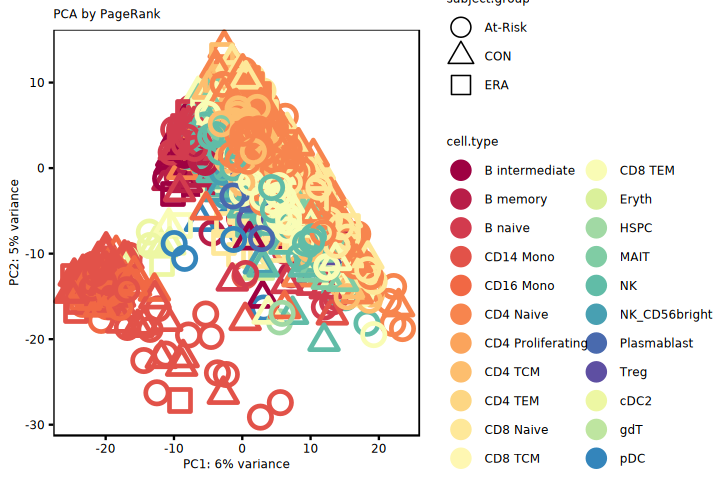

In [43]:
options(repr.plot.width=6, repr.plot.height=4)
myPlot <- ggplot(mydata, aes(x = PC1, y = PC2, colour = cell.type, shape=subject.group, stroke=1.5)) + geom_point(size = 5) + scale_color_manual(values = mycolors$cell.type) + 
        plot.format + scale_shape(solid = FALSE) + ggtitle("PCA by PageRank") +
        xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
        ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance"))
print(myPlot)

In [44]:
pdf(paste0("PCA_",tag,"_PC1_2_group3.pdf"), width = 7, height = 5)
print(myPlot)
dev.off()

pdf 
  2

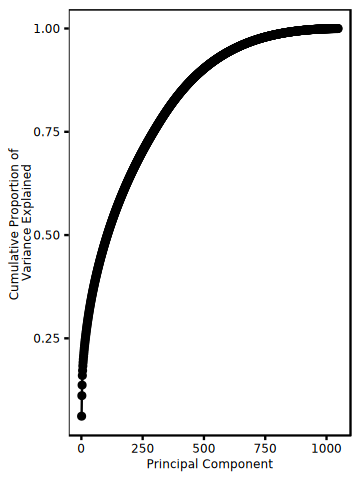

In [45]:
# plot pca cumulating variance
options(repr.plot.width=3, repr.plot.height=4)
df2 <- data.frame(x=c(1:length(pca$sdev)),y=cumsum(percentVar))
p2 <- ggplot(df2)+aes(x=x,y=y)+geom_point()+geom_line()+
    labs(x="Principal Component",y="Cumulative Proportion of \nVariance Explained")+
    plot.format
print(p2)

In [46]:
## save to file
pdf(paste0("PCA_",tag,"_cumul_variance.pdf"), width=2, height=2)
print(p2)
dev.off()

pdf 
  2

## hyperparams selection

After manually checking the above cumulative PCA plot, we decide to use PC=300 to reduce the data based on "elbow" method, which explained 85% variance. Then we need to determine the best distance metric and number of K for Kmeans clustering. To evaluate the clustering quality, we computed the **average silhouette width** which combines both *cohesion* (how close data points in a cluster are to each other) and *separation* (how distinct a cluster is from other clusters). A higher silhouette width value indicates better clustering quality.

We used five common distance metrics:
- Euclidean distance
- Manhattan distance
- Kendall correlation
- Pearson correlation
- Spearman correlation

Number of k is selected from the range [3, 20]. The lower limit is considering the number of disease states while the upper limit is the balance of searching space and searching speed.

In [47]:
PCNo <- 500
df <- data %>% as.matrix %>% t
data_reduced <- as.data.frame(prcomp(df, rank. = PCNo)$x)

In [48]:
head(data_reduced)
dim(data_reduced)
write.csv(data_reduced, paste0('data_reduced_PC',PCNo,'_',tag,'.csv'))

PC1        PC2         PC3         PC4         PC5      
B001_PB00001_C1 -24.183060 -13.4007282   0.3256017   7.1685272 -8.990808
B001_PB00001_C2  -5.874121   5.2523341   7.3215542 -10.0616944 -1.347698
B001_PB00001_C3  -8.313757   4.7758244 -11.9118288  -4.9084052  2.347942
B001_PB00001_C4  -3.416828   7.2799514   6.0047613  -2.7030689 -5.322716
B001_PB00001_C5 -19.383388 -13.8387284  -0.6538943   5.1636291 -4.602663
B001_PB00001_C6   3.062678  -0.3324675   0.9118705   0.3486713 -3.174901
                PC6        PC7        PC8         PC9        PC10       ⋯
B001_PB00001_C1 -0.6402949  0.9028733 -3.48722205  0.6677825  0.2258353 ⋯
B001_PB00001_C2  5.7084212  2.3795441 -1.93929678  1.2818488  1.3512580 ⋯
B001_PB00001_C3  0.5566533  1.2044329 -0.28904969 -3.1101593 -1.5975660 ⋯
B001_PB00001_C4 -3.0714018 -0.7290561 -1.30872899 -0.9079955 -2.9790540 ⋯
B001_PB00001_C5 -0.2254571 -0.4099033 -3.82784911  0.4040543  0.4621727 ⋯
B001_PB00001_C6 -4.5346866 -2.6643713 -0.01169851  0.7899192  0.4839091 ⋯
                PC491       PC492       PC493       PC494       PC495      
B001_PB00001_C1 -0.16289938 -1.04967327  0.45586150  0.41594767  0.60286804
B001_PB00001_C2 -0.37070924  0.05663753 -0.32280709 -1.35999672 -0.32424996
B001_PB00001_C3  0.05443855 -0.37635813 -0.07183694 -0.03347767  0.49469213
B001_PB00001_C4  0.18954169 -0.37045806  0.10524578 -0.53637673 -0.09138857
B001_PB00001_C5  0.08289681 -0.74498780 -0.39913571  1.61476868 -0.64749863
B001_PB00001_C6 -1.01774634 -0.14878588  0.52697709  0.82350422 -0.68308778
                PC496       PC497      PC498      PC499      PC500     
B001_PB00001_C1 -0.09315129 0.03135575 -0.7887403  1.3970554  0.3588919
B001_PB00001_C2  0.11422919 0.60522197 -0.6063804 -0.4893455  2.0593892
B001_PB00001_C3  0.43124653 0.32467330  0.6436510  0.3716533 -0.4679705
B001_PB00001_C4  0.25232488 0.13156611 -0.3399065  0.6739807 -0.1470186
B001_PB00001_C5 -0.48359708 1.08969201 -0.9225044 -0.8884743  0.6996253
B001_PB00001_C6  1.03878191 0.59463356 -1.5862982 -0.8389786 -1.2584975

[1] 1610  500

In [49]:
# this step takes ~3hr
set.seed(3)
df2 <- findOptimal(data_reduced, max_k = 10, cores = detectCores())
# df2 <- findOptimal(as.data.frame(df), max_k = 10) # use original data


Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 itera

In [50]:
saveRDS(df2,paste0('hyper_opt_PC',PCNo,'_',tag,'.rds'))

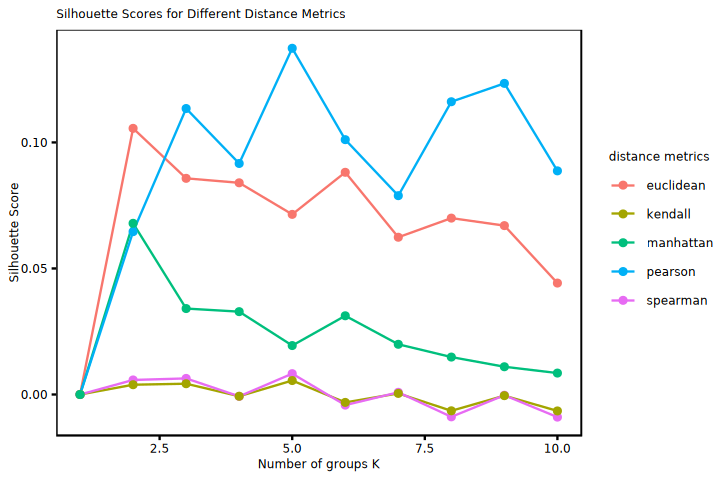

In [51]:
options(repr.plot.width=6, height=2)
df2$silhouette_plot+plot.format

In [52]:
# save to file
pdf(paste0("kmeans_param_PC",PCNo,"_",tag,".pdf"),width=3.5,height = 2)
df2$silhouette_plot+plot.format
df2$elbow_plot+plot.format
df2$gap_plot+plot.format
dev.off()

pdf 
  2

## Kmeans clustering

From the distance metrics plot, we can select the best hyperparam combos: 
- K=5
- distance metric=Pearson Correlation.

You need to install package `amap`

In [53]:
clusterNo <- 5

In [54]:
PCNo <- 500
df <- data %>% as.matrix %>% t
data_reduced <- as.data.frame(prcomp(df, rank. = PCNo)$x)

In [55]:
# get final Kmeans clustering result
# set.seed(8) # K=6
set.seed(3) # K=5

# method <- "spearman"
clusterNo <- 5
Cluster <- kmeans(data_reduced, centers = clusterNo, nstart = 25,iter.max = 50) 
# Cluster <- amap::Kmeans(as.data.frame(df), centers = clusterNo, nstart = 25,iter.max = 50, method = method) # use original data

df2 <- as.data.frame(Cluster$cluster) %>% tibble::rownames_to_column("id") %>% dplyr::rename(kmeans=`Cluster$cluster`) 
df2$kmeans <- paste0("G",df2$kmeans)

In [56]:
# get updated meta file
info <- meta %>% inner_join(df2, by = "id")
head(info)
dim(info)

preClust  cluster purity cells RNA_cells ATAC_cells sample      
1 CD14 Mono C1      0.940  5329  4327      1002       B001_PB00001
2 NK        C2      0.873  1946  1391       555       B001_PB00001
3 B naive   C3      0.946  1830  1511       319       B001_PB00001
4 MAIT      C4      0.840  1588  1200       388       B001_PB00001
5 CD16 Mono C5      0.425  1062   392       670       B001_PB00001
6 CD4 TCM   C6      0.726  1059   104       955       B001_PB00001
  id              sample.visitName subject.biologicalSex ⋯ cohort.cohortGuid
1 B001_PB00001_C1 Flu Year 1 Day 0 Female                ⋯ BR1              
2 B001_PB00001_C2 Flu Year 1 Day 0 Female                ⋯ BR1              
3 B001_PB00001_C3 Flu Year 1 Day 0 Female                ⋯ BR1              
4 B001_PB00001_C4 Flu Year 1 Day 0 Female                ⋯ BR1              
5 B001_PB00001_C5 Flu Year 1 Day 0 Female                ⋯ BR1              
6 B001_PB00001_C6 Flu Year 1 Day 0 Female                ⋯ BR1              
  subject.age sample.sampleKitGuid sample.visitDetails            
1 36          KT00001              N/A - Flu-Series Timepoint Only
2 36          KT00001              N/A - Flu-Series Timepoint Only
3 36          KT00001              N/A - Flu-Series Timepoint Only
4 36          KT00001              N/A - Flu-Series Timepoint Only
5 36          KT00001              N/A - Flu-Series Timepoint Only
6 36          KT00001              N/A - Flu-Series Timepoint Only
  sample.daysSinceFirstVisit subject.race subject.group subject.group2
1 0                          Caucasian    CON           CON           
2 0                          Caucasian    CON           CON           
3 0                          Caucasian    CON           CON           
4 0                          Caucasian    CON           CON           
5 0                          Caucasian    CON           CON           
6 0                          Caucasian    CON           CON           
  subject.group3 kmeans
1 CON            G4    
2 CON            G3    
3 CON            G1    
4 CON            G3    
5 CON            G4    
6 CON            G2

[1] 1610   22

In [242]:
info |> group_by(kmeans) |> summarise(n=n())

kmeans n  
1 G1     131
2 G2     359
3 G3     290
4 G4     704
5 G5     126

In [58]:
info |> distinct(kmeans, subject.group2, sample.sampleKitGuid) |> group_by(kmeans, subject.group2) |> summarise(n=n())

`summarise()` has grouped output by 'kmeans'. You can override using the
`.groups` argument.


kmeans subject.group2 n 
1  G1     At-Risk/ERA    31
2  G1     CON            35
3  G2     At-Risk/ERA    31
4  G2     CON            35
5  G3     At-Risk/ERA    30
6  G3     CON            34
7  G4     At-Risk/ERA    24
8  G4     CON            30
9  G5     At-Risk/ERA    31
10 G5     CON            32

In [64]:
# adjust the order of Kmeans: G3-->G4; G4-->G5; G5-->G3 (K=5)
info <- info |> mutate(kmeans = ifelse(kmeans=='G5', 'G2', ifelse(kmeans=='G2', 'G4', ifelse(kmeans=='G4', 'G1', ifelse(kmeans=='G1', 'G5', kmeans)))))

In [65]:
# save to file
write.csv(info, paste0('meta_kmeans_',tag,'_',clusterNo,'.csv'))

# cluster distribution across Kmeans groups

## cell type distribution

First, we checked the cell type distribution across kmeans groups

In [66]:
file <- paste0('meta_kmeans_',tag,'_',clusterNo,'.csv')
test_group <- 'preClust'
f1 <- paste0("id ~ kmeans + ", test_group)
f2 <- paste0("id ~ ", test_group)


df1 <- read.csv(file) %>% 
    stats::aggregate(as.formula(f1), data = ., FUN = function(x){NROW(x)})

# add null distribtution
df2 <- read.csv(file) %>%
    stats::aggregate(as.formula(f2), data = ., FUN = function(x){NROW(x)}) %>% mutate(kmeans="All")
df3 <- rbind(df1,df2) %>% arrange(kmeans)

head(df3)
dim(df3)

kmeans preClust       id 
1 All    B intermediate  27
2 All    B memory        26
3 All    B naive         84
4 All    CD14 Mono       85
5 All    CD16 Mono       43
6 All    CD4 Naive      466

[1] 72  3

In [67]:
# write to file
tmp <- df3 %>% tidyr::pivot_wider(names_from = preClust, values_from = id, values_fill = 0) 
write.csv(tmp,paste0('cell_states_freq_across_kmeans_',tag,'_',clusterNo,'.csv'),quote=F, row.names=F)

In [68]:
# normalize
df3 <- read.csv(paste0('cell_states_freq_across_kmeans_',tag,'_',clusterNo,'.csv')) %>% tibble::column_to_rownames('kmeans') 
df4 <- df3/rowSums(df3)
head(df4)

B.intermediate B.memory    B.naive     CD14.Mono   CD16.Mono   CD4.Naive  
All 0.016770186    0.016149068 0.052173913 0.052795031 0.026708075 0.289440994
G1  0.000000000    0.000000000 0.000000000 0.595419847 0.312977099 0.000000000
G2  0.002785515    0.005571031 0.030640669 0.013927577 0.002785515 0.309192201
G3  0.000000000    0.000000000 0.000000000 0.000000000 0.000000000 0.003448276
G4  0.000000000    0.000000000 0.001420455 0.001420455 0.000000000 0.502840909
G5  0.206349206    0.190476190 0.571428571 0.007936508 0.007936508 0.000000000
    CD4.Proliferating CD4.TCM    CD4.TEM     CD8.Naive  ⋯ Eryth      
All 0.001863354       0.21366460 0.001242236 0.06211180 ⋯ 0.001242236
G1  0.000000000       0.00000000 0.000000000 0.00000000 ⋯ 0.000000000
G2  0.002785515       0.16434540 0.000000000 0.13927577 ⋯ 0.005571031
G3  0.000000000       0.02068966 0.003448276 0.00000000 ⋯ 0.000000000
G4  0.002840909       0.39630682 0.001420455 0.07102273 ⋯ 0.000000000
G5  0.000000000       0.00000000 0.000000000 0.00000000 ⋯ 0.000000000
    HSPC        MAIT        NK         NK_CD56bright Plasmablast Treg       
All 0.001242236 0.035403727 0.08944099 0.013043478   0.001863354 0.006211180
G1  0.000000000 0.000000000 0.00000000 0.000000000   0.000000000 0.000000000
G2  0.005571031 0.052924791 0.07520891 0.005571031   0.002785515 0.008356546
G3  0.000000000 0.120689655 0.40344828 0.065517241   0.000000000 0.000000000
G4  0.000000000 0.004261364 0.00000000 0.000000000   0.001420455 0.009943182
G5  0.000000000 0.000000000 0.00000000 0.000000000   0.007936508 0.000000000
    cDC2        gdT         pDC        
All 0.005590062 0.000621118 0.004347826
G1  0.068702290 0.000000000 0.015267176
G2  0.000000000 0.000000000 0.011142061
G3  0.000000000 0.003448276 0.000000000
G4  0.000000000 0.000000000 0.000000000
G5  0.000000000 0.000000000 0.007936508

We can see that G2 has cell type distribution similar to the overall PBMC distribution and included all 11 major cell types.

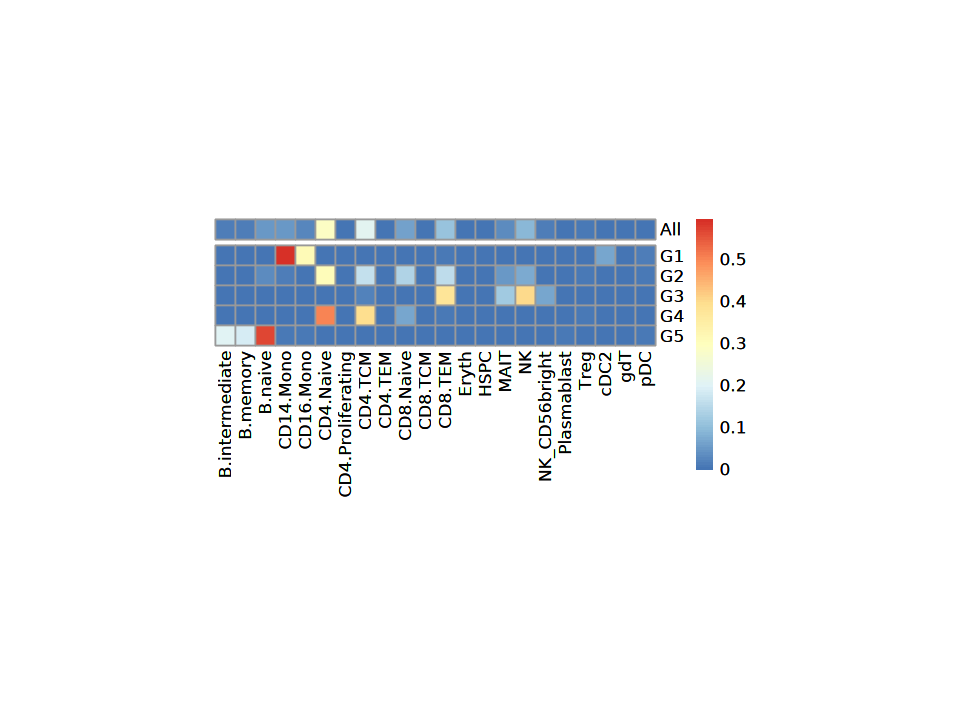

In [69]:
# visualize all cell types
options(repr.plot.width=8, repr.plot.height=6)
library(pheatmap)
p <- pheatmap(df4, cluster_rows=FALSE, cluster_cols=FALSE, gaps_row = 1, cellheight = 12, cellwidth = 12, angle_col = 90)
print(p)

 [1] "B intermediate" "B memory"       "B naive"        "CD14 Mono"     
 [5] "CD16 Mono"      "CD4 Naive"      "CD8 Naive"      "CD4 TCM"       
 [9] "CD8 TEM"        "MAIT"           "NK"             "NK_CD56bright" 
[13] "Treg"          


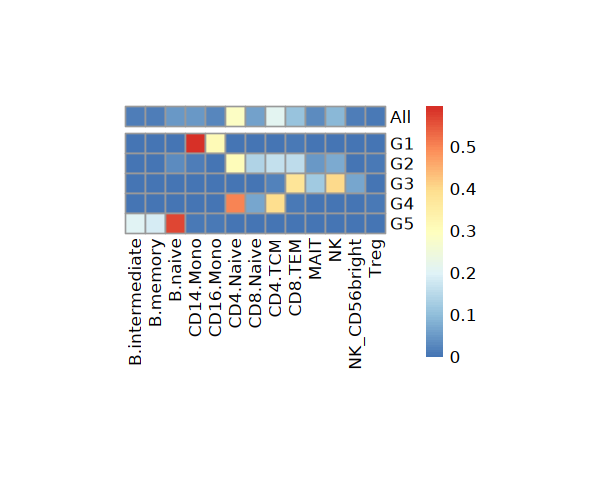

In [70]:
# select major cell states and visualize
options(repr.plot.width=5, repr.plot.height=4)
print(selected_cell_states)
df5 <- df4[,sub(' ','.',selected_cell_states)]

p <- pheatmap(df5, cluster_rows=FALSE, cluster_cols=FALSE, gaps_row = 1, cellheight = 12, cellwidth = 12, angle_col=90)

In [71]:
## save to file
pdf(paste0('cell_state_freq_across_kmeans_',tag,'_',clusterNo,'.pdf'), width = 4, height = 4)
print(p)
dev.off()

pdf 
  2

## At-Risk/ERA vs CON ratio

Next, we investigated the disease state distribution across 5 kmeans groups. We want to see if At-Risk/ERA is significantly enriched in any Kmeans group.

In [72]:
# test_group <- 'subject.group'
test_group <- 'subject.group2'
file <- paste0('meta_kmeans_',tag,'_',clusterNo,'.csv')

f1 <- paste0("id ~ kmeans + ", test_group)
f2 <- paste0("id ~ ", test_group)


df1 <- read.csv(file) %>% 
    stats::aggregate(as.formula(f1), data = ., FUN = function(x){NROW(x)})

# add null distribtution
df2 <- read.csv(file) %>%
    stats::aggregate(as.formula(f2), data = ., FUN = function(x){NROW(x)}) %>% mutate(kmeans="All")
df3 <- rbind(df1,df2) %>% arrange(kmeans)

head(df3)
dim(df3)

kmeans subject.group2 id 
1 All    At-Risk/ERA    760
2 All    CON            850
3 G1     At-Risk/ERA     61
4 G1     CON             70
5 G2     At-Risk/ERA    210
6 G2     CON            149

[1] 12  3

In [73]:
meta <- read.csv(file)
meta2 <- meta |> mutate(subject.group4=ifelse(subject.group %in% c('Non-converter','CON'), 'neg','pos'))

               kmeans  G1  G2  G3  G4  G5
subject.group2                           
At-Risk/ERA            61 210 140 285  64
CON                    70 149 150 419  62


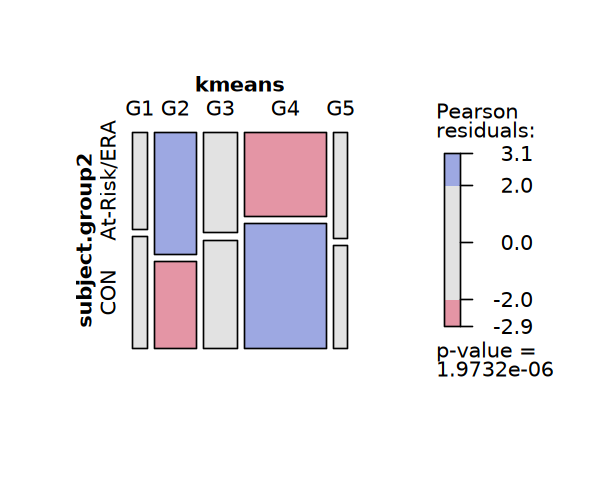

In [75]:
library(vcd)
# test_group <- 'subject.group'
test_group <- 'subject.group2'
f <- paste0("~ kmeans + ", test_group)
p3 <- vcd::mosaic(as.formula(f), direction = c("v", "h"), data = read.csv(file), shade = TRUE)
print(p3)

In [76]:
file <- paste0('meta_kmeans_',tag,'_',clusterNo,'.csv')
test_group <- 'subject.group2'
# test_group <- 'subject.group'
f1 <- paste0("id ~ kmeans + ", test_group)
f2 <- paste0("id ~ ", test_group)


df1 <- read.csv(file) %>% 
    stats::aggregate(as.formula(f1), data = ., FUN = function(x){NROW(x)})

# add null distribtution
df2 <- read.csv(file) %>%
    stats::aggregate(as.formula(f2), data = ., FUN = function(x){NROW(x)}) %>% mutate(kmeans="All")
df3 <- rbind(df1,df2) %>% arrange(kmeans)

head(df3)
dim(df3)

kmeans subject.group2 id 
1 All    At-Risk/ERA    760
2 All    CON            850
3 G1     At-Risk/ERA     61
4 G1     CON             70
5 G2     At-Risk/ERA    210
6 G2     CON            149

[1] 12  3

In [77]:
# write to file
tmp <- df3 %>% tidyr::pivot_wider(names_from = !!as.name(test_group), values_from = id, values_fill = 0)
write.csv(tmp,paste0('disease_state_freq_across_kmeans_',test_group,'_',tag,'_',clusterNo,'.csv'),quote=F, row.names=F)

In [78]:
# df3[df3$kmeans==x & df3$subject.group!="Non-converter", "id"]
# ratios <- df3 |> tidyr::pivot_wider(names_from = test_group, values_from = 'id', values_fill = 0) |> as.data.frame() |> mutate(ratio=(Converter+ERA)/`Non-converter`)
ratios <- df3 |> tidyr::pivot_wider(names_from = test_group, values_from = 'id', values_fill = 0) |> as.data.frame() |> mutate(ratio=(`At-Risk/ERA`/CON))
null = ratios[ratios$kmeans=='All','ratio']
ratios$adjusted.ratio <- ratios$ratio/null
ratios

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(test_group)

  # Now:
  data %>% select(all_of(test_group))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


kmeans At-Risk/ERA CON ratio     adjusted.ratio
1 All    760         850 0.8941176 1.0000000     
2 G1      61          70 0.8714286 0.9746241     
3 G2     210         149 1.4093960 1.5762981     
4 G3     140         150 0.9333333 1.0438596     
5 G4     285         419 0.6801909 0.7607399     
6 G5      64          62 1.0322581 1.1544992

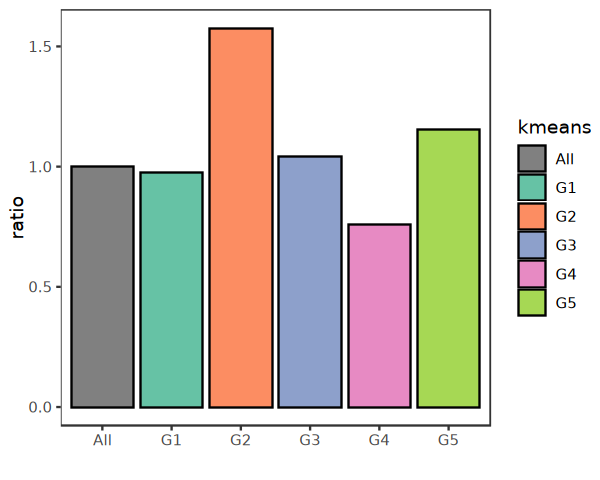

In [79]:
p4 <- ggplot(ratios, aes(x = kmeans, y = adjusted.ratio, fill=kmeans)) +
    geom_bar(stat = "identity", colour = "black") +
    labs(x = "", y = "ratio") + 
    scale_fill_manual(values = c("#808080",brewer.pal(clusterNo,"Set2")[1:clusterNo])) +
    theme_bw() +
    theme(
      panel.grid.minor.x = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank()
    )
p4

In [80]:
## save to file
pdf(paste0('disease_state_ratio_across_kmeans_',test_group,'_',tag,'_',clusterNo,'.pdf'), width = 4, height = 4)
print(p4)
dev.off()

pdf 
  2

### statistical significance 

From above plot, it's obvious that G2 is enriched in At-Risk/ERA compared to controls. Then we used chi-squared goodness of fit test to see if the enrichment is significant or not compared to the null distribution. R function `chisq.test` can be used as follow:
`chisq.test(x,p)`, where x is a numeric vector representing the observed probability and p represents the expected probability.

In [81]:
# test for G2, subject.group2
test_k = 'G2'
test_group = 'subject.group2'
a <- df3 |> filter(kmeans=='All' & !!as.name(test_group)!='CON') |> pull(id) 
b <- df3 |> filter(kmeans=='All' & !!as.name(test_group)=='CON') |> pull(id) 
a2 <- df3 |> filter(kmeans==test_k & !!as.name(test_group)!='CON') |> pull(id) 
b2 <- df3 |> filter(kmeans==test_k & !!as.name(test_group)=='CON') |> pull(id) 

x <- c(a2,b2)
p <- c(a/(a+b), b/(a+b))
chisq.test(x,p=p)


	Chi-squared test for given probabilities

data:  x
X-squared = 18.364, df = 1, p-value = 1.825e-05


## G2 clusters ratio per cell type in CON and At-Risk/ERA

From the previous analysis, we already know:
- G2 is significantly enriched in At-Risk/ERA
- G2 is multi-lineage group

We then want to see the distribution of the enrichment across cell types. In other words, what cell types in G2 that contributed more in the enrichment?

In [82]:
C_target = 'G2'
g <- "subject.group2"
meta3 <- read.csv(file, row.names = 1) %>% 
        mutate(preClust2 = ifelse(preClust %in% c("B memory", "B naive", "B intermediate"), "B cell", 
                                  ifelse(preClust %in% c("CD16 Mono", "CD14 Mono"), "Monocytes", 
                                         ifelse(preClust %in% c("NK", "NK_CD56bright"), "NK cell", preClust))),
                kmeans2 = ifelse(kmeans==C_target, kmeans, "other"))
head(meta3)
dim(meta3)

preClust  cluster purity cells RNA_cells ATAC_cells sample      
1 CD14 Mono C1      0.940  5329  4327      1002       B001_PB00001
2 NK        C2      0.873  1946  1391       555       B001_PB00001
3 B naive   C3      0.946  1830  1511       319       B001_PB00001
4 MAIT      C4      0.840  1588  1200       388       B001_PB00001
5 CD16 Mono C5      0.425  1062   392       670       B001_PB00001
6 CD4 TCM   C6      0.726  1059   104       955       B001_PB00001
  id              sample.visitName subject.biologicalSex ⋯ sample.sampleKitGuid
1 B001_PB00001_C1 Flu Year 1 Day 0 Female                ⋯ KT00001             
2 B001_PB00001_C2 Flu Year 1 Day 0 Female                ⋯ KT00001             
3 B001_PB00001_C3 Flu Year 1 Day 0 Female                ⋯ KT00001             
4 B001_PB00001_C4 Flu Year 1 Day 0 Female                ⋯ KT00001             
5 B001_PB00001_C5 Flu Year 1 Day 0 Female                ⋯ KT00001             
6 B001_PB00001_C6 Flu Year 1 Day 0 Female                ⋯ KT00001             
  sample.visitDetails             sample.daysSinceFirstVisit subject.race
1 N/A - Flu-Series Timepoint Only 0                          Caucasian   
2 N/A - Flu-Series Timepoint Only 0                          Caucasian   
3 N/A - Flu-Series Timepoint Only 0                          Caucasian   
4 N/A - Flu-Series Timepoint Only 0                          Caucasian   
5 N/A - Flu-Series Timepoint Only 0                          Caucasian   
6 N/A - Flu-Series Timepoint Only 0                          Caucasian   
  subject.group subject.group2 subject.group3 kmeans preClust2 kmeans2
1 CON           CON            CON            G1     Monocytes other  
2 CON           CON            CON            G3     NK cell   other  
3 CON           CON            CON            G5     B cell    other  
4 CON           CON            CON            G3     MAIT      other  
5 CON           CON            CON            G1     Monocytes other  
6 CON           CON            CON            G4     CD4 TCM   other

[1] 1610   24

In [83]:
# get the number of total clusters across cell types
total <- meta3 |> group_by(preClust2, !!as.name(g)) |> summarise(total=n())
head(total)
dim(total)

# get the number of G2 clusters across cell types
sub <- meta3 |> filter(kmeans==C_target) |> group_by(preClust2, !!as.name(g)) |> summarise(sub=n())
head(sub)
dim(sub)

`summarise()` has grouped output by 'preClust2'. You can override using the
`.groups` argument.


preClust2         subject.group2 total
1 B cell            At-Risk/ERA     72  
2 B cell            CON             65  
3 CD4 Naive         At-Risk/ERA    203  
4 CD4 Naive         CON            263  
5 CD4 Proliferating CON              3  
6 CD4 TCM           At-Risk/ERA    159

[1] 31  3

`summarise()` has grouped output by 'preClust2'. You can override using the
`.groups` argument.


preClust2         subject.group2 sub
1 B cell            At-Risk/ERA     8 
2 B cell            CON             6 
3 CD4 Naive         At-Risk/ERA    63 
4 CD4 Naive         CON            48 
5 CD4 Proliferating CON             1 
6 CD4 TCM           At-Risk/ERA    37

[1] 23  3

In [84]:
# calculate the percentage of G2 clusters per cell type in CON and At-Risk/ERA respectively
df <- sub %>% right_join(total, by=c("preClust2",g)) %>% mutate_all(~replace(., is.na(.), 0)) %>% mutate(pct = 100*sub/total) %>%
            mutate(label=paste0(sub,"(", sprintf("%.0f", pct), "%)"))
head(df)
dim(df)

`mutate_all()` ignored the following grouping variables:
• Column `preClust2`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.


preClust2         subject.group2 sub total pct       label  
1 B cell            At-Risk/ERA     8   72   11.111111 8(11%) 
2 B cell            CON             6   65    9.230769 6(9%)  
3 CD4 Naive         At-Risk/ERA    63  203   31.034483 63(31%)
4 CD4 Naive         CON            48  263   18.250951 48(18%)
5 CD4 Proliferating CON             1    3   33.333333 1(33%) 
6 CD4 TCM           At-Risk/ERA    37  159   23.270440 37(23%)

[1] 31  6

In [85]:
# save to file
write.csv(df, paste0('pct_G2_per_cell_type_two_groups_',tag,"_",clusterNo,'.csv'))

### statistical significance per cell type

We used chi-squared goodness of fit test to see if the percentage is significant different from CON and At-Risk/ERA. 

In [86]:
selected_cell_states2 <- c('B cell', 'Monocytes', 'CD4 Naive', 'CD8 Naive', 'CD4 TCM', 'CD8 TEM', 'MAIT', 'NK cell', 'Treg')
selected_cell_states2

[1] "B cell"    "Monocytes" "CD4 Naive" "CD8 Naive" "CD4 TCM"   "CD8 TEM"  
[7] "MAIT"      "NK cell"   "Treg"

In [87]:
#### calculate p-values for all cell types
pvalues <- lapply(selected_cell_states2, function(x){
    print(x)
    tmp <- df %>% filter(preClust2==x) 
    a <- tmp |> filter(subject.group2=='At-Risk/ERA') |> pull(total)
    b <- tmp |> filter(subject.group2=='CON') |> pull(total)
    c <- tmp |> filter(subject.group2=='At-Risk/ERA') |> pull(sub)
    d <- tmp |> filter(subject.group2=='CON') |> pull(sub)
    
    null.prop <- c(a/(a + b), b/(a + b))
    res <- chisq.test(c(c, d), p = null.prop)
    print(res$p.value)    
    return(res$p.value)
})

[1] "B cell"
[1] 0.7310027
[1] "Monocytes"


Warning message in chisq.test(c(c, d), p = null.prop):
“Chi-squared approximation may be incorrect”


[1] 0.7875219
[1] "CD4 Naive"
[1] 0.005053635
[1] "CD8 Naive"
[1] 0.008735788
[1] "CD4 TCM"
[1] 0.01106458
[1] "CD8 TEM"
[1] 0.1292272
[1] "MAIT"


Warning message in chisq.test(c(c, d), p = null.prop):
“Chi-squared approximation may be incorrect”


[1] 0.01782124
[1] "NK cell"
[1] 0.7919784
[1] "Treg"


Warning message in chisq.test(c(c, d), p = null.prop):
“Chi-squared approximation may be incorrect”


[1] 0.8136637


In [88]:
names(pvalues) <- selected_cell_states2

In [89]:
## select cell lineages with significant enrichment
cells <- names(pvalues)[which(pvalues <= 0.3)]

In [90]:
## plot vertical histogram
df2 <- df %>% filter(preClust2 %in% cells)
df2[[g]] <- factor(df2[[g]], levels = sort(unique(df2[[g]]), decreasing = T))

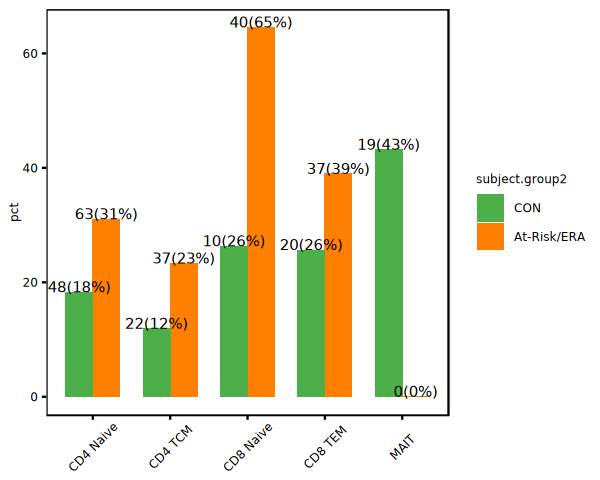

In [91]:
p1 <- ggplot(df2, aes(x = preClust2, y = pct, fill = !!as.name(g))) + 
    geom_bar(position = position_dodge(), stat = "identity", width = .7) +
    scale_fill_manual(values = mycolors[[g]]) + 
    geom_text(aes(label = label), position = position_dodge(width = .7), vjust=0, size = 3) +
    plot.format + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5), axis.title.x = element_blank())
p1

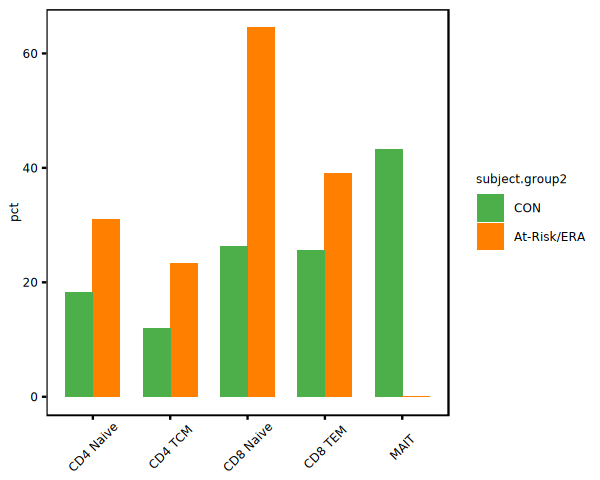

In [92]:
# no label version
p2 <- ggplot(df2, aes(x = preClust2, y = pct, fill = !!as.name(g))) + 
    geom_bar(position = position_dodge(), stat = "identity", width = .7) +
    scale_fill_manual(values = mycolors[[g]]) + 
    plot.format + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5), axis.title.x = element_blank())
p2

In [93]:
df3 <- df |> filter(preClust2 %in% selected_cell_states2)
df3

preClust2 subject.group2 sub total pct       label  
1  B cell    At-Risk/ERA     8   72   11.111111 8(11%) 
2  B cell    CON             6   65    9.230769 6(9%)  
3  CD4 Naive At-Risk/ERA    63  203   31.034483 63(31%)
4  CD4 Naive CON            48  263   18.250951 48(18%)
5  CD4 TCM   At-Risk/ERA    37  159   23.270440 37(23%)
6  CD4 TCM   CON            22  185   11.891892 22(12%)
7  CD8 Naive At-Risk/ERA    40   62   64.516129 40(65%)
8  CD8 Naive CON            10   38   26.315789 10(26%)
9  CD8 TEM   At-Risk/ERA    37   95   38.947368 37(39%)
10 CD8 TEM   CON            20   78   25.641026 20(26%)
11 MAIT      CON            19   44   43.181818 19(43%)
12 Monocytes At-Risk/ERA     3   57    5.263158 3(5%)  
13 Monocytes CON             3   71    4.225352 3(4%)  
14 NK cell   At-Risk/ERA    13   78   16.666667 13(17%)
15 NK cell   CON            16   87   18.390805 16(18%)
16 Treg      At-Risk/ERA     1    4   25.000000 1(25%) 
17 Treg      CON             2    6   33.333333 2(33%) 
18 MAIT      At-Risk/ERA     0   13    0.000000 0(0%)

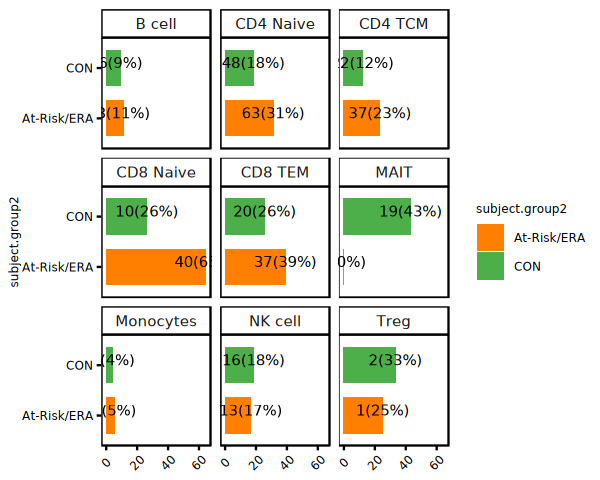

In [94]:
p3 <- ggplot(df3, aes(y = !!as.name(g), x = pct, fill = !!as.name(g))) + 
    geom_bar(position = position_dodge(), stat = "identity", width = .7) +
    scale_fill_manual(values = mycolors[[g]]) + 
    facet_wrap(~preClust2)+
    geom_text(aes(label = label), position = position_dodge(width = .7), vjust=0, size = 3) +
    plot.format + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5), axis.title.x = element_blank(),
                        legend.key = element_blank(), strip.background = element_rect(colour="black", fill=NA)) 

p3

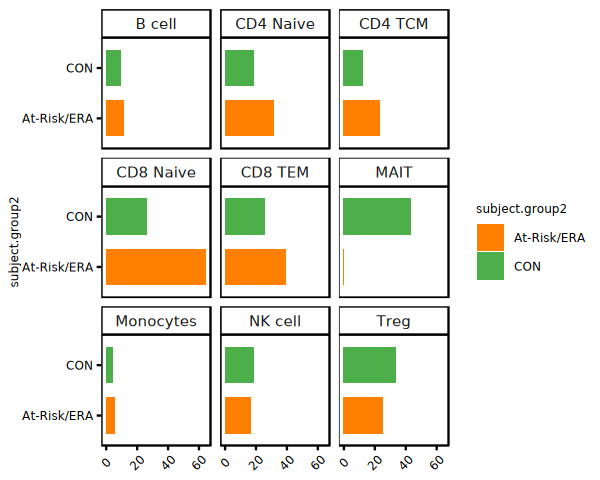

In [95]:
p4 <- ggplot(df3, aes(y = !!as.name(g), x = pct, fill = !!as.name(g))) + 
    geom_bar(position = position_dodge(), stat = "identity", width = .7) +
    scale_fill_manual(values = mycolors[[g]]) + 
    facet_wrap(~preClust2)+
    plot.format + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5), axis.title.x = element_blank(),
                        legend.key = element_blank(), strip.background = element_rect(colour="black", fill=NA)) 

p4

In [96]:
## save to file
pdf(paste0('pct_G2_per_cell_type_two_groups_',g,'_',tag,"_",clusterNo,'.pdf'), width = 5, height = 4)
print(p1)
print(p2)
print(p3)
print(p4)
dev.off()

pdf 
  2

# signature TFs, genes, pathways

## Kmeans group specific TFs

The heatmap shows distinct TF profiles across Kmeans groups. We used Wilcoxon rank-sum test (a.k.a Mann-Whitney U test) to identify Kmeans group-specific TFs. We selected Wilcoxon test because our data doesn't fit normal distribution. If data is normally or log-normally distributed, t-test can be applied here as well.

To be more specific, we divided the clusters into two groups: target group and background group. Target group included the clusters in the Kmeans group of interest, for example G2. Background group included all the remaining clusters. We experimented on several combinations of p-value and log2 fold change. We chose p-value of 0.01 and log2FC of 0.5 considering a reasonable number of TFs for all 5 groups. 

In [11]:
tag <- "" 
clusterNo <- 5

In [98]:
# create dir for results
dir.create(file.path(maindir, paste0('kmeans_',clusterNo)), showWarnings = FALSE)
dir.create(file.path(maindir, paste0('kmeans_',clusterNo,'/GO')), showWarnings = FALSE)

In [34]:
setwd(paste0(maindir,"kmeans_",clusterNo))

In [100]:
## identify kmeans cluster-specific TFs
main <- function(p = 0.001, d = 1, data=pr, meta=meta2, group_by='kmeans'){
    tryCatch({
        subject.types <- unique(meta[[group_by]])
        ls <- lapply(subject.types,function(y) 
          specificTFs_cell(y, p = p, d = d, df = data, group = meta, group_name = group_by, test = "wilcoxon"))

        ### GO analysis
        L <- list.files(path = "./", pattern = paste0(".*_p",p,"_d",d,".*.txt"), full.names = T)
        print(L)
        lapply(L, function(x) gsea(x, output_dir = "GO/", showCategory = 20, go.height = 10, go.width = 7))
    },error=function(e){})

}                     

In [12]:
# load data and meta data
# meta2 <- read.csv(paste0(maindir,"/meta_kmeans_5.csv"), row.names = 1)
meta2 <- read.csv(paste0(maindir,'meta_kmeans_',tag,'_',clusterNo,'.csv'), row.names=1)
head(meta2)
dim(meta2)

preClust  cluster purity cells RNA_cells ATAC_cells sample      
1 CD14 Mono C1      0.940  5329  4327      1002       B001_PB00001
2 NK        C2      0.873  1946  1391       555       B001_PB00001
3 B naive   C3      0.946  1830  1511       319       B001_PB00001
4 MAIT      C4      0.840  1588  1200       388       B001_PB00001
5 CD16 Mono C5      0.425  1062   392       670       B001_PB00001
6 CD4 TCM   C6      0.726  1059   104       955       B001_PB00001
  id              sample.visitName subject.biologicalSex ⋯ cohort.cohortGuid
1 B001_PB00001_C1 Flu Year 1 Day 0 Female                ⋯ BR1              
2 B001_PB00001_C2 Flu Year 1 Day 0 Female                ⋯ BR1              
3 B001_PB00001_C3 Flu Year 1 Day 0 Female                ⋯ BR1              
4 B001_PB00001_C4 Flu Year 1 Day 0 Female                ⋯ BR1              
5 B001_PB00001_C5 Flu Year 1 Day 0 Female                ⋯ BR1              
6 B001_PB00001_C6 Flu Year 1 Day 0 Female                ⋯ BR1              
  subject.age sample.sampleKitGuid sample.visitDetails            
1 36          KT00001              N/A - Flu-Series Timepoint Only
2 36          KT00001              N/A - Flu-Series Timepoint Only
3 36          KT00001              N/A - Flu-Series Timepoint Only
4 36          KT00001              N/A - Flu-Series Timepoint Only
5 36          KT00001              N/A - Flu-Series Timepoint Only
6 36          KT00001              N/A - Flu-Series Timepoint Only
  sample.daysSinceFirstVisit subject.race subject.group subject.group2
1 0                          Caucasian    CON           CON           
2 0                          Caucasian    CON           CON           
3 0                          Caucasian    CON           CON           
4 0                          Caucasian    CON           CON           
5 0                          Caucasian    CON           CON           
6 0                          Caucasian    CON           CON           
  subject.group3 kmeans
1 CON            G1    
2 CON            G3    
3 CON            G5    
4 CON            G3    
5 CON            G1    
6 CON            G4

[1] 1610   22

In [102]:
# this step takes several minutes
main(data=pr, meta=meta2, p = 0.01, d = 0.5)

[1] 131
[1] 290
[1] 126
[1] 704
[1] 359
[1] ".//G1_p0.01_d0.5_gene141_wilcoxon.txt"
[2] ".//G2_p0.01_d0.5_gene409_wilcoxon.txt"
[3] ".//G3_p0.01_d0.5_gene65_wilcoxon.txt" 
[4] ".//G4_p0.01_d0.5_gene41_wilcoxon.txt" 
[5] ".//G5_p0.01_d0.5_gene101_wilcoxon.txt"


'select()' returned 1:1 mapping between keys and columns

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

### TF overlap

In [103]:
library(UpSetR)

In [104]:
L <- list.files(pattern = "G.*p0.01_d0.5.*txt", full.names = T)
TFs <- lapply(L, function(x) readLines(x))
names(TFs) <- paste0("G",1:clusterNo)

In [105]:
p <- upset(fromList(TFs), 
      nintersects = 40, 
      nsets = 6, 
      order.by = "freq", 
      decreasing = T, 
      mb.ratio = c(0.6, 0.4),
      number.angles = 0, 
      text.scale = 1.1, 
      point.size = 2.8, 
      line.size = 1
      )

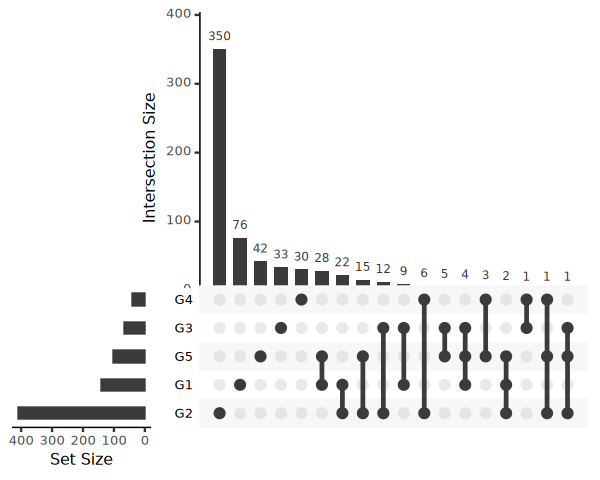

In [106]:
print(p)

In [107]:
pdf(paste0('kmeans_group_TFs_upset.pdf'), width = 4, height = 4)
print(p)
dev.off()

pdf 
  2

In [108]:
# total number of unique TFs
unlist(TFs) |> unique() |> length()

[1] 640

In [35]:
# read signature TFs
# pathways <- c('SUMOylation of intracellular receptors','Transcriptional regulation by RUNX2','YAP1- and WWTR1 (TAZ)-stimulated gene expression','Deactivation of the beta-catenin transactivating complex','NOTCH3 Intracellular Domain Regulates Transcription')
# tfs <- read.csv(paste0(maindir,'kmeans/GO/G2_p0.01_d0.5_gene433_wilcoxon_GO.csv')) |> filter(Description %in% pathways) |> select(Description, p.adjust,geneID)
tfs <- read.csv('GO/G2_p0.01_d0.5_gene409_wilcoxon_GO.csv') |> filter(grepl('SUMO|RUNX2|YAP1|beta-catenin|NOTCH3', Description)) |> 
    select(Description, p.adjust,geneID) |> mutate(D2 = ifelse(grepl('SUMO', Description), 'SUMO', 
                           ifelse(grepl('RUNX2', Description), 'RUNX2', 
                                  ifelse(grepl('NOTCH3', Description), 'NOTCH3',                            
                                         ifelse(grepl('beta-catenin', Description), 'Wnt', 
                                                ifelse(grepl('YAP1', Description), 'YAP1', 'SUMO')))))) |>  group_by(D2) 

head(tfs)
dim(tfs)

Description                                         p.adjust    
1 Transcriptional regulation by RUNX2                 1.937194e-10
2 RUNX2 regulates bone development                    2.449885e-08
3 RUNX2 regulates osteoblast differentiation          4.174362e-08
4 YAP1- and WWTR1 (TAZ)-stimulated gene expression    1.016182e-06
5 SUMOylation of intracellular receptors              4.572997e-06
6 NOTCH3 Intracellular Domain Regulates Transcription 2.273632e-05
  geneID                                                                                      
1 SP7/SOX9/DLX6/NKX3-2/HAND2/DLX5/HEY1/ZNF521/MSX2/TWIST1/TWIST2/SATB2/GLI3/AR/HES1/HEY2/SMAD1
2 SP7/HEY1/ZNF521/SATB2/GLI3/AR/HES1/HEY2/SMAD1                                               
3 SP7/HEY1/ZNF521/SATB2/GLI3/AR/HES1/HEY2                                                     
4 NKX2-5/GATA4/TEAD4/TEAD1/TEAD2/TEAD3                                                        
5 PGR/NR5A1/NR5A2/NR1I2/THRB/AR/PPARG                                                         
6 HES5/HEYL/HEY1/HES1/HEY2/PBX1                                                               
  D2    
1 RUNX2 
2 RUNX2 
3 RUNX2 
4 YAP1  
5 SUMO  
6 NOTCH3

[1] 15  4

In [36]:
# signature TF list
l <- c('SUMO','RUNX2','YAP1','Wnt','NOTCH3')
regulators <- lapply(l, function(x) {
    r <- paste0(tfs |> filter(D2==x) |> pull(geneID), collapse='/')
    strsplit(r,'/')[[1]] |> unique()
})
names(regulators) <- l
regulators

$SUMO
 [1] "PGR"    "NR5A1"  "NR5A2"  "NR1I2"  "THRB"   "AR"     "PPARG"  "TFAP2C"
 [9] "TFAP2B" "FOXL2"  "TFAP2A" "SATB2"  "MITF"  

$RUNX2
 [1] "SP7"    "SOX9"   "DLX6"   "NKX3-2" "HAND2"  "DLX5"   "HEY1"   "ZNF521"
 [9] "MSX2"   "TWIST1" "TWIST2" "SATB2"  "GLI3"   "AR"     "HES1"   "HEY2"  
[17] "SMAD1" 

$YAP1
[1] "NKX2-5" "GATA4"  "TEAD4"  "TEAD1"  "TEAD2"  "TEAD3" 

$Wnt
[1] "SOX9"   "SOX2"   "SOX6"   "SOX7"   "TCF7L1" "SOX13" 

$NOTCH3
[1] "HES5" "HEYL" "HEY1" "HES1" "HEY2" "PBX1"

In [37]:
saveRDS(regulators, 'signature_tfs.rds')

In [112]:
p <- upset(fromList(regulators), 
      nintersects = 40, 
      nsets = 6, 
      order.by = "freq", 
      decreasing = T, 
      mb.ratio = c(0.6, 0.4),
      number.angles = 0, 
      text.scale = 1.1, 
      point.size = 2.8, 
      line.size = 1,set_size.show = TRUE
      )

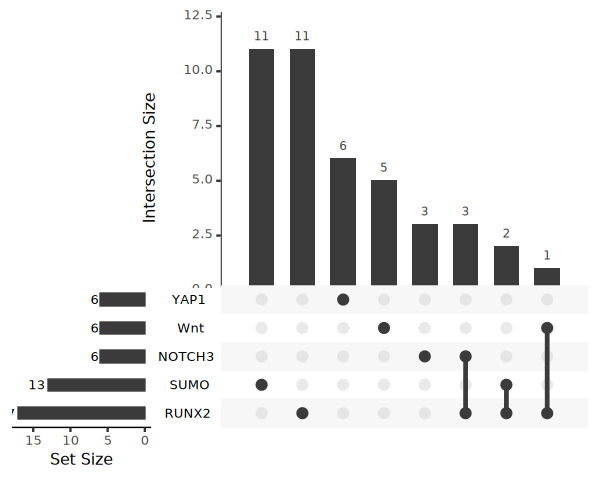

In [113]:
print(p)

In [114]:
pdf(paste0('signature_TFs_upset.pdf'), width = 4, height = 3)
print(p)
dev.off()

pdf 
  2

## Kmeans group specific pathways

We already performed gene set enrichment analysis for each Kmeans group TFs. We'll gather the results and visualize the top pathways.

In [115]:
L <- list.files(path = paste0(maindir, '/kmeans_',clusterNo,'/GO/') , pattern = 'p0.01_d0.5.*csv', full.names = T)
L

[1] "/home/workspace/paper_figures_1031//kmeans_5/GO//G1_p0.01_d0.5_gene141_wilcoxon_GO.csv"
[2] "/home/workspace/paper_figures_1031//kmeans_5/GO//G2_p0.01_d0.5_gene409_wilcoxon_GO.csv"
[3] "/home/workspace/paper_figures_1031//kmeans_5/GO//G3_p0.01_d0.5_gene65_wilcoxon_GO.csv" 
[4] "/home/workspace/paper_figures_1031//kmeans_5/GO//G4_p0.01_d0.5_gene41_wilcoxon_GO.csv" 
[5] "/home/workspace/paper_figures_1031//kmeans_5/GO//G5_p0.01_d0.5_gene101_wilcoxon_GO.csv"

In [148]:
# df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% filter(grepl('R-HSA', ID) & p.adjust<=0.05) %>% slice_min(order_by = p.adjust, n=30)%>%mutate(group=gsub('_.*','',gsub('.*/','',x)))}))
df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% filter(p.adjust<=0.05) |> mutate(ID_class = factor(gsub("[^a-zA-Z]", "", ID), levels = c('RHSA','GO','hsa'))) |>
                                             arrange(ID_class, p.adjust) |> head(n=30)|>
                                             mutate(group=gsub('_.*','',gsub('.*/','',x)))}))

df$GeneRatio <- sapply(df$GeneRatio, function(x) eval(parse(text=x)))
df <- df %>% arrange(group, GeneRatio)
df$Description <- factor(df$Description, levels = unique(df$Description))
 
dim(df)
head(df)

[1] 150  11

ID           
1 R-HSA-9708530
2 R-HSA-9818030
3 R-HSA-9818027
4 R-HSA-380994 
5 R-HSA-9733709
6 R-HSA-450282 
  Description                                                       GeneRatio 
1 Regulation of BACH1 activity                                      0.02298851
2 NFE2L2 regulating tumorigenic genes                               0.02298851
3 NFE2L2 regulating anti-oxidant/detoxification enzymes             0.03448276
4 ATF4 activates genes in response to endoplasmic reticulum  stress 0.03448276
5 Cardiogenesis                                                     0.03448276
6 MAPK targets/ Nuclear events mediated by MAP kinases              0.03448276
  BgRatio  pvalue       p.adjust    qvalue      geneID            Count
1 11/11009 0.0032418764 0.028434188 0.019645649 BACH1/MAFK        2    
2 11/11009 0.0032418764 0.028434188 0.019645649 NFE2L2/MAFK       2    
3 19/11009 0.0004215408 0.005199004 0.003592077 BACH1/NFE2L2/MAFK 3    
4 27/11009 0.0012156836 0.013119252 0.009064307 CEBPB/CEBPG/ATF3  3    
5 27/11009 0.0012156836 0.013119252 0.009064307 SMAD1/MEF2C/SRF   3    
6 31/11009 0.0018261366 0.018918775 0.013071293 FOS/MEF2C/MEF2A   3    
  ID_class group
1 RHSA     G1   
2 RHSA     G1   
3 RHSA     G1   
4 RHSA     G1   
5 RHSA     G1   
6 RHSA     G1

This plot shows the top20 pathways for each Kmeans group. We curated a list of G2-specific pathways associated with RA pathogenesis:
1. Transcriptional regulation by RUNX2
2. YAP1- and WWTR1 (TAZ)-stimulated gene expression
3. SUMOylation of intracellular receptors
4. NOTCH3 Intracellular Domain Regulates Transcription
5. Deactivation of the beta-catenin transactivating complex

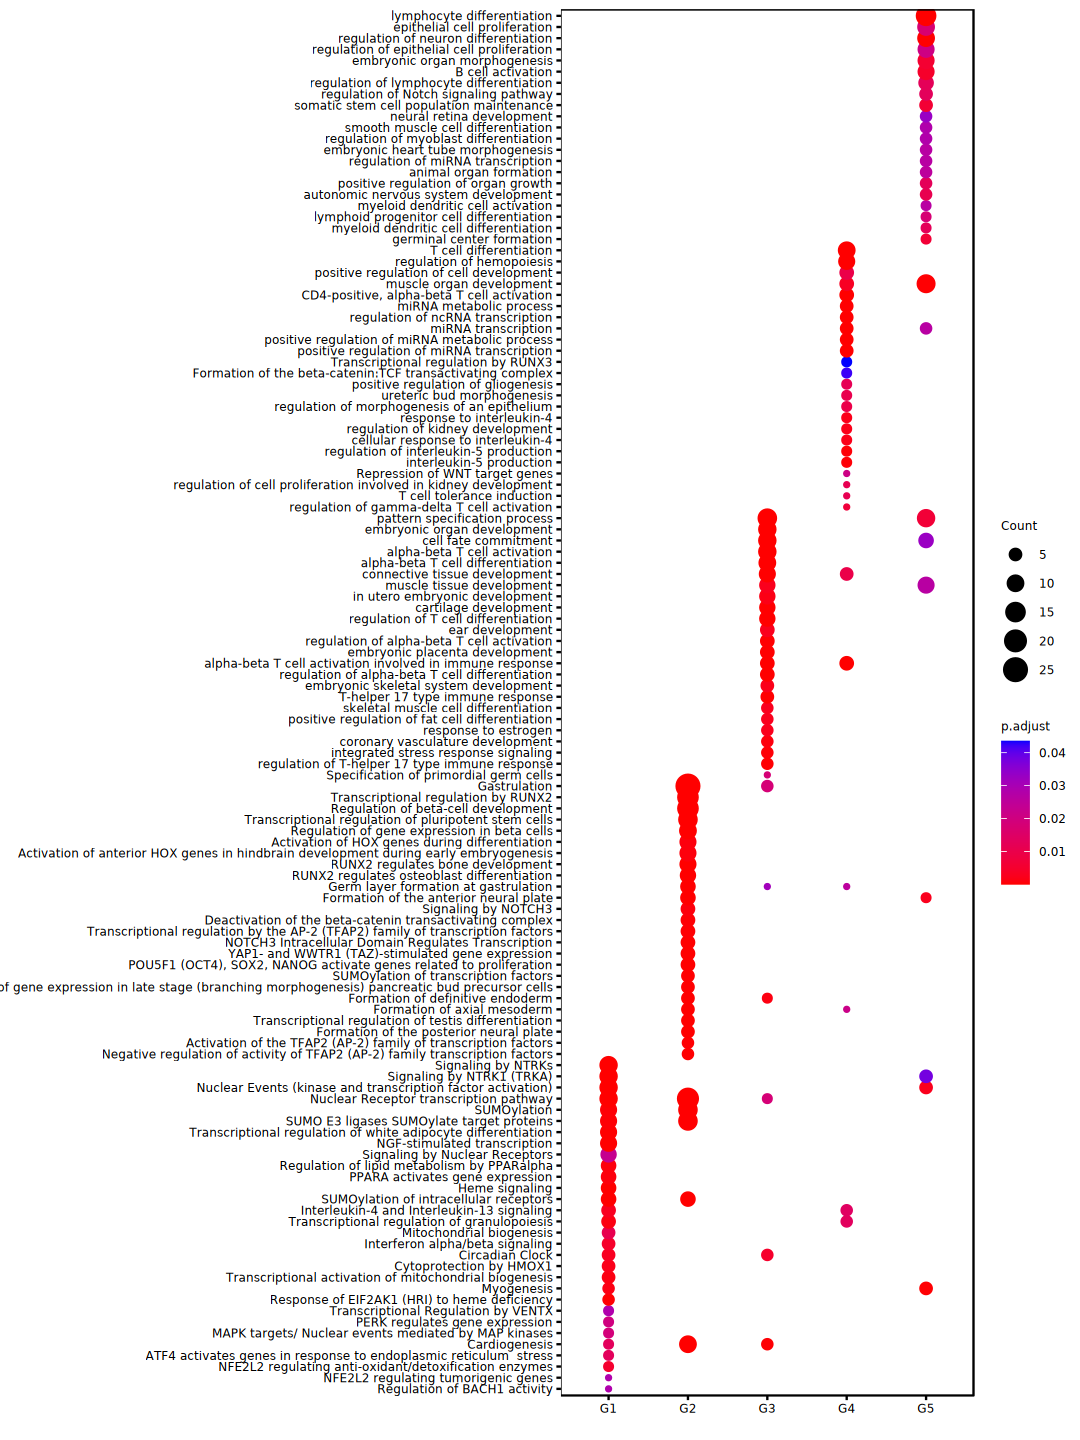

In [152]:
options(repr.plot.width = 9,repr.plot.height = 12)
p <- ggplot(df, aes(x=group, y=Description, size=Count, color=p.adjust))+
    geom_point()+scale_color_gradient(low="red",high="blue", name="p.adjust")+theme_bw()+
    ylab("")+xlab("")+plot.format
p

In [118]:
# write to file
df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% filter(grepl('R-HSA', ID) & p.adjust<=0.05) %>%mutate(group=gsub('_.*','',gsub('.*/','',x)))}))
write.table(df, 'Reactome_pathway_p0.05_G2_specific_TFs_all.tsv', quote=F, row.names=F, sep = '\t')

In [158]:
# selected representative pathways
# shortened version of plot
selected_pathways <- c('myeloid cell differentiation','Signaling by NTRKs','Mussle tissue development',
                       'SUMOylation of intracellular receptors','Transcriptional regulation by RUNX2','YAP1- and WWTR1 (TAZ)-stimulated gene expression','NOTCH3 Intracellular Domain Regulates Transcription','Deactivation of the beta-catenin transactivating complex',
                       'cartilage development', 'alpha-beta T cell activation',
                       'Formation of the beta-catenin:TCF transactivating complex','Repression of WNT target genes','Transcriptional regulation by RUNX3','Interleukin-4 and Interleukin-13 signaling',
                       'B cell activation', 'regulation of Notch signaling pathway')

df2 <- df %>% filter(Description %in% selected_pathways)
df2$Description <- factor(df2$Description, levels =selected_pathways)
head(df2)
dim(df2)

ID            Description                                             
1 R-HSA-6785807 Interleukin-4 and Interleukin-13 signaling              
2 R-HSA-4090294 SUMOylation of intracellular receptors                  
3 R-HSA-166520  Signaling by NTRKs                                      
4 R-HSA-2032785 YAP1- and WWTR1 (TAZ)-stimulated gene expression        
5 R-HSA-9013508 NOTCH3 Intracellular Domain Regulates Transcription     
6 R-HSA-3769402 Deactivation of the beta-catenin transactivating complex
  GeneRatio  BgRatio   pvalue       p.adjust     qvalue      
1 0.06896552 108/11009 2.055877e-04 2.958178e-03 2.043854e-03
2 0.08045977 30/11009  2.646552e-09 1.370914e-07 9.471872e-08
3 0.12643678 134/11009 7.328293e-09 3.163380e-07 2.185631e-07
4 0.03409091 15/11009  6.809467e-08 1.016182e-06 7.112722e-07
5 0.03409091 25/11009  2.109555e-06 2.273632e-05 1.591419e-05
6 0.03409091 42/11009  4.987934e-05 3.583923e-04 2.508551e-04
  geneID                                                   Count ID_class group
1 CEBPD/BCL6/FOS/STAT6/JUNB/IRF4                            6    RHSA     G1   
2 RXRA/RARA/VDR/NR4A2/NR1H3/PPARA/PPARG                     7    RHSA     G1   
3 FOS/LYL1/JUNB/MEF2C/MEF2A/FOSB/MEF2D/SRF/EGR2/FOSL1/EGR3 11    RHSA     G1   
4 NKX2-5/GATA4/TEAD4/TEAD1/TEAD2/TEAD3                      6    RHSA     G2   
5 HES5/HEYL/HEY1/HES1/HEY2/PBX1                             6    RHSA     G2   
6 SOX9/SOX2/SOX6/SOX7/TCF7L1/SOX13                          6    RHSA     G2

[1] 16 11

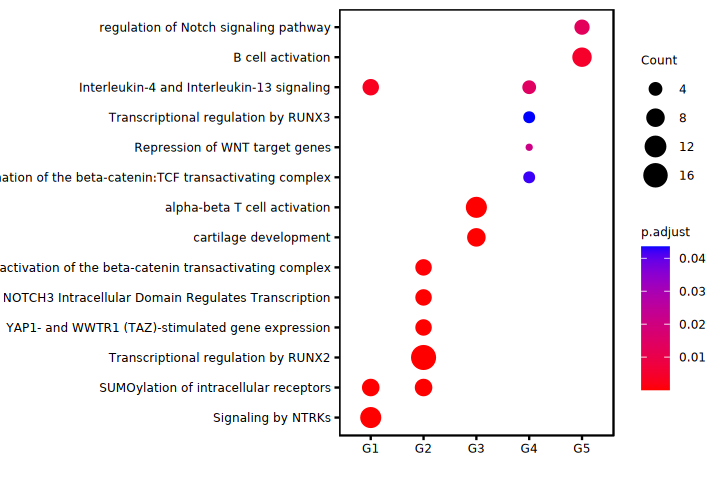

In [159]:
options(repr.plot.width = 6,repr.plot.height = 4)
p <- ggplot(df2, aes(x=group, y=Description, size=Count, color=p.adjust))+
    geom_point()+scale_color_gradient(low="red",high="blue", name="p.adjust")+theme_bw()+
    ylab("")+xlab("")+plot.format
p

In [160]:
# save to file
pdf('summary_representative_pathways.pdf', width = 6, height = 3)
print(p)
dev.off()

pdf 
  2

### signature pathways across cell types

Next, we identified G2-specific TFs along with pathways for each cell type. Target group included the G2 clusters in the cell type of interest and the background included the remaining clusters of the same cell type. p-value of 0.01 and log2 fold change of 0.5 were used for calling the specific TFs. 

In [161]:
# create dir for results
dir.create(file.path(maindir, paste0('kmeans_cell_type_',clusterNo)), showWarnings = FALSE)
dir.create(file.path(maindir, paste0('kmeans_cell_type_',clusterNo,'/GO')), showWarnings = FALSE)

In [80]:
setwd(paste0(maindir,'kmeans_cell_type_',clusterNo))
getwd()

[1] "/home/workspace/paper_figures_1031/kmeans_cell_type_5"

In [163]:
meta3 <- meta2 |> mutate(preClust2 = ifelse(preClust %in% c("B memory", "B naive", "B intermediate"), "B cell", ifelse(preClust %in% c("CD16 Mono", "CD14 Mono"), "Monocytes", ifelse(preClust %in% c("NK", "NK_CD56bright"), "NK cell", preClust)))) |> mutate(cell_k=paste0(preClust2,'_',kmeans))

In [164]:
head(meta3)
dim(meta3)

preClust  cluster purity cells RNA_cells ATAC_cells sample      
1 CD14 Mono C1      0.940  5329  4327      1002       B001_PB00001
2 NK        C2      0.873  1946  1391       555       B001_PB00001
3 B naive   C3      0.946  1830  1511       319       B001_PB00001
4 MAIT      C4      0.840  1588  1200       388       B001_PB00001
5 CD16 Mono C5      0.425  1062   392       670       B001_PB00001
6 CD4 TCM   C6      0.726  1059   104       955       B001_PB00001
  id              sample.visitName subject.biologicalSex ⋯ sample.sampleKitGuid
1 B001_PB00001_C1 Flu Year 1 Day 0 Female                ⋯ KT00001             
2 B001_PB00001_C2 Flu Year 1 Day 0 Female                ⋯ KT00001             
3 B001_PB00001_C3 Flu Year 1 Day 0 Female                ⋯ KT00001             
4 B001_PB00001_C4 Flu Year 1 Day 0 Female                ⋯ KT00001             
5 B001_PB00001_C5 Flu Year 1 Day 0 Female                ⋯ KT00001             
6 B001_PB00001_C6 Flu Year 1 Day 0 Female                ⋯ KT00001             
  sample.visitDetails             sample.daysSinceFirstVisit subject.race
1 N/A - Flu-Series Timepoint Only 0                          Caucasian   
2 N/A - Flu-Series Timepoint Only 0                          Caucasian   
3 N/A - Flu-Series Timepoint Only 0                          Caucasian   
4 N/A - Flu-Series Timepoint Only 0                          Caucasian   
5 N/A - Flu-Series Timepoint Only 0                          Caucasian   
6 N/A - Flu-Series Timepoint Only 0                          Caucasian   
  subject.group subject.group2 subject.group3 kmeans preClust2 cell_k      
1 CON           CON            CON            G1     Monocytes Monocytes_G1
2 CON           CON            CON            G3     NK cell   NK cell_G3  
3 CON           CON            CON            G5     B cell    B cell_G5   
4 CON           CON            CON            G3     MAIT      MAIT_G3     
5 CON           CON            CON            G1     Monocytes Monocytes_G1
6 CON           CON            CON            G4     CD4 TCM   CD4 TCM_G4

[1] 1610   24

In [165]:
selected_cell_states3 <- c('B cell', 'Monocytes', 'CD4 Naive', 'CD4 TCM', 'CD8 Naive', 'CD8 TEM', 'NK cell', 'Treg')

In [166]:
# identify specific TFs for each cell type, which takes ~5 min
tmp <- lapply(selected_cell_states3,function(x){
    meta4 <- meta3 |> filter(preClust2==x)
    df <- pr[,meta4$id]
    ls <- specificTFs_cell(paste0(x,'_G2'), p = 0.01, d = 0.5, df = df, group = meta4, group_name = 'cell_k', test = "wilcoxon")
})

[1] 14
[1] 6
[1] 111
[1] 59
[1] 50
[1] 57
[1] 29
[1] 3


In [167]:
# GO analysis for each group of TFs, which takes ~10 min
L <- list.files(path = "./", pattern = paste0(".*_p",0.01,"_d",0.5,".*.txt"), full.names = T)
print(L)
lapply(L, function(x) gsea(x, output_dir = "GO/", showCategory = 20, go.height = 10, go.width = 7))

[1] ".//B cell_G2_p0.01_d0.5_gene383_wilcoxon.txt"   
[2] ".//CD4 Naive_G2_p0.01_d0.5_gene413_wilcoxon.txt"
[3] ".//CD4 TCM_G2_p0.01_d0.5_gene399_wilcoxon.txt"  
[4] ".//CD8 Naive_G2_p0.01_d0.5_gene416_wilcoxon.txt"
[5] ".//CD8 TEM_G2_p0.01_d0.5_gene401_wilcoxon.txt"  
[6] ".//Monocytes_G2_p0.01_d0.5_gene392_wilcoxon.txt"
[7] ".//NK cell_G2_p0.01_d0.5_gene393_wilcoxon.txt"  


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

In [81]:
setwd("GO/")

In [169]:
L <- list.files(pattern = 'gene.*csv')
L

[1] "B cell_G2_p0.01_d0.5_gene383_wilcoxon_GO.csv"   
[2] "CD4 Naive_G2_p0.01_d0.5_gene413_wilcoxon_GO.csv"
[3] "CD4 TCM_G2_p0.01_d0.5_gene399_wilcoxon_GO.csv"  
[4] "CD8 Naive_G2_p0.01_d0.5_gene416_wilcoxon_GO.csv"
[5] "CD8 TEM_G2_p0.01_d0.5_gene401_wilcoxon_GO.csv"  
[6] "Monocytes_G2_p0.01_d0.5_gene392_wilcoxon_GO.csv"
[7] "NK cell_G2_p0.01_d0.5_gene393_wilcoxon_GO.csv"

In [170]:
df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% filter(grepl('R-HSA', ID) & p.adjust<=0.05) %>% slice_min(order_by = p.adjust, n=40)%>%mutate(group=gsub('_.*','',x))}))
dim(df)
head(df)

[1] 283  10

ID            Description                                          GeneRatio
1 R-HSA-186712  Regulation of beta-cell development                  16/162   
2 R-HSA-383280  Nuclear Receptor transcription pathway               17/162   
3 R-HSA-9758941 Gastrulation                                         21/162   
4 R-HSA-452723  Transcriptional regulation of pluripotent stem cells 12/162   
5 R-HSA-210745  Regulation of gene expression in beta cells          10/162   
6 R-HSA-9733709 Cardiogenesis                                        10/162   
  BgRatio   pvalue       p.adjust     qvalue      
1 41/11009  1.710229e-19 3.146820e-17 2.268303e-17
2 52/11009  4.269719e-19 3.928141e-17 2.831498e-17
3 114/11009 1.195985e-17 7.335375e-16 5.287513e-16
4 24/11009  1.586823e-16 7.299385e-15 5.261570e-15
5 21/11009  1.105135e-13 4.066896e-12 2.931515e-12
6 27/11009  2.450238e-12 7.514062e-11 5.416315e-11
  geneID                                                                                                                
1 ONECUT3/FOXA3/RFX6/FOXA2/ONECUT1/NEUROG3/NKX2-2/INSM1/NEUROD1/NKX6-1/HNF4A/HNF4G/HNF1B/HNF1A/NR5A2/MAFA               
2 NR2E1/NR0B1/ESRRB/HNF4A/HNF4G/PGR/NR1I2/NR5A1/PPARG/AR/RORC/NR6A1/NR5A2/NR1I3/ESRRG/VDR/NR4A3                         
3 GATA4/LHX1/FOXA2/TEAD4/ZIC2/GSC/FOXF1/SOX2/GATA6/FOXA1/SOX1/TBPL2/HES7/MESP2/ZNF521/MIXL1/FOXH1/FOXC1/NANOG/SNAI1/PAX2
4 ZSCAN10/FOXD3/SOX2/SALL4/HIF3A/PRDM14/NR5A1/EPAS1/LIN28A/NR6A1/NANOG/PBX1                                             
5 FOXA3/RFX6/FOXA2/NKX2-2/NEUROD1/NKX6-1/HNF4A/HNF4G/HNF1A/MAFA                                                         
6 GATA4/TBX20/HAND1/NKX2-5/GATA6/HAND2/TBX1/HEY1/HEY2/SMAD1                                                             
  Count group 
1 16    B cell
2 17    B cell
3 21    B cell
4 12    B cell
5 10    B cell
6 10    B cell

In [171]:
# write to file
write.table(df, 'Reactome_pathway_p0.05_G2_specific_TFs_across_cell_states_top40.tsv', quote=F, row.names=F, sep = '\t')

In [82]:
df <- read.table('Reactome_pathway_p0.05_G2_specific_TFs_across_cell_states_top40.tsv', sep = '\t', header = T)
df$GeneRatio <- sapply(df$GeneRatio, function(x) eval(parse(text=x)))
df <- df %>% arrange(group, GeneRatio)
df$Description <- factor(df$Description, levels = unique(df$Description))
df <- df %>% mutate(log10_p.adjust = ifelse(p.adjust<=1e-5, 5, -log10(p.adjust))) |> group_by(group) |> slice_min(order_by=p.adjust, n = 50)
tail(df)
dim(df)

ID           
1 R-HSA-9764260
2 R-HSA-8866910
3 R-HSA-9819196
4 R-HSA-9031628
5 R-HSA-9013695
6 R-HSA-8939902
  Description                                                                      
1 Regulation of Expression and Function of Type II Classical Cadherins             
2 TFAP2 (AP-2) family regulates transcription of growth factors and their receptors
3 Zygotic genome activation (ZGA)                                                  
4 NGF-stimulated transcription                                                     
5 NOTCH4 Intracellular Domain Regulates Transcription                              
6 Regulation of RUNX2 expression and activity                                      
  GeneRatio  BgRatio  pvalue      p.adjust    qvalue     
1 0.02395210 31/11009 0.001167483 0.006637977 0.004669933
2 0.01796407 15/11009 0.001364103 0.007336660 0.005161469
3 0.01796407 15/11009 0.001364103 0.007336660 0.005161469
4 0.02395210 39/11009 0.002777903 0.014547439 0.010234379
5 0.01796407 20/11009 0.003232771 0.016495421 0.011604819
6 0.02994012 73/11009 0.004952419 0.024638286 0.017333468
  geneID                       Count group   log10_p.adjust
1 HEYL/FOXF1/BHLHE22/SNAI1     4     NK cell 2.177964      
2 TFAP2C/TFAP2B/TFAP2A         3     NK cell 2.134502      
3 TEAD4/DUX4/ZSCAN4            3     NK cell 2.134502      
4 ASCL1/EGR4/FOSL1/EGR3        4     NK cell 1.837213      
5 HEY1/HES5/HES1               3     NK cell 1.782637      
6 MSX2/DLX5/DLX6/NKX3-2/TWIST1 5     NK cell 1.608390

[1] 283  11

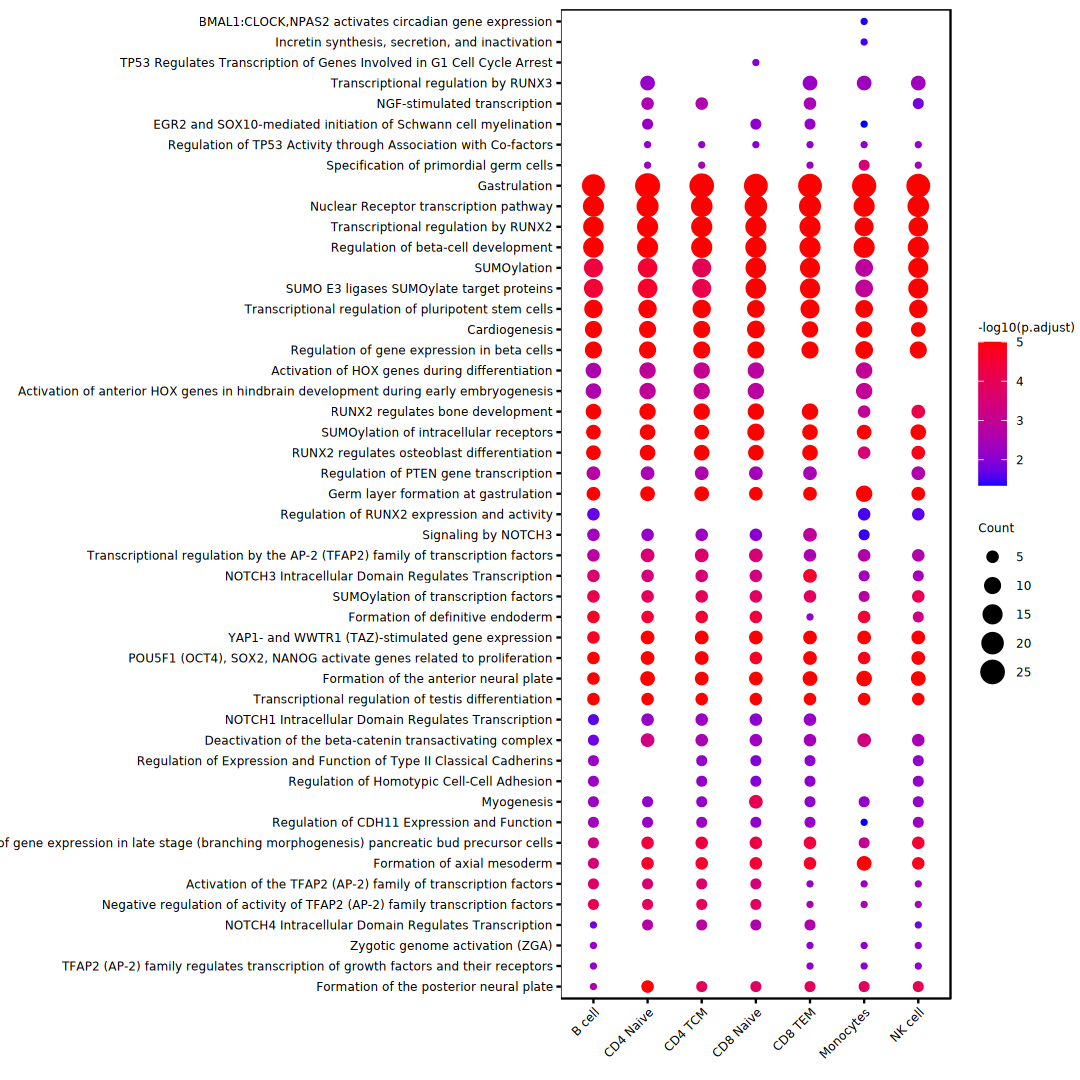

In [173]:
options(repr.plot.width = 9,repr.plot.height = 9)
p <- ggplot(df, aes(x=group, y=Description, size=Count, color=log10_p.adjust))+
    geom_point()+scale_color_gradient(low="blue",high="red", name="-log10(p.adjust)")+theme_bw()+
    ylab("")+xlab("")+plot.format+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

p

From the above plot, we can see the 5 signature pathways are shared across cell types. Some pathways are only important in a few cell types. So we selected some representative G2 pathways and visualized below.

In [83]:
# selected pathways
selected_pathways <- c('Activation of HOX genes during differentiation',
                       'NGF-stimulated transcription',
                       'Signaling by NOTCH1 in Cancer',
                       # 'TP53 Regulates Transcription of Genes Involved in G1 Cell Cycle Arrest',
                       'Transcriptional regulation by RUNX3',
                       # 'BMAL1:CLOCK,NPAS2 activates circadian gene expression',
                       'Deactivation of the beta-catenin transactivating complex',
                       'NOTCH3 Intracellular Domain Regulates Transcription',
                       'SUMOylation of intracellular receptors', 
                       'YAP1- and WWTR1 (TAZ)-stimulated gene expression', 
                       'Transcriptional regulation by RUNX2')
# selected_pathways <- c('Adherens junctions interactions','Transcriptional regulation by RUNX3','NOTCH4 intracellular Domain Regulates Transcription',
#                        'Deactivation of the beta-catenin transactivating complex','NOTCH3 Intracellular Domain Regulates Transcription','SUMOylation of intracellular receptors', 'YAP1- and WWTR1 (TAZ)-stimulated gene expression', 'Transcriptional regulation by RUNX2')
selected_cell_states <- c('B cell','CD4 Naive','CD4 TCM','CD8 Naive','CD8 TEM','Monocytes','NK cell','Treg')
df3 <- df %>% filter(Description %in% selected_pathways & group %in% selected_cell_states)
df3$Description <- factor(df3$Description, levels=selected_pathways)
head(df3)
dim(df3)

ID            Description                                             
1 R-HSA-8878166 Transcriptional regulation by RUNX2                     
2 R-HSA-4090294 SUMOylation of intracellular receptors                  
3 R-HSA-2032785 YAP1- and WWTR1 (TAZ)-stimulated gene expression        
4 R-HSA-9013508 NOTCH3 Intracellular Domain Regulates Transcription     
5 R-HSA-5619507 Activation of HOX genes during differentiation          
6 R-HSA-3769402 Deactivation of the beta-catenin transactivating complex
  GeneRatio  BgRatio   pvalue       p.adjust     qvalue      
1 0.09876543 121/11009 2.164283e-11 5.688972e-10 4.100747e-10
2 0.04320988 30/11009  2.009713e-07 3.361701e-06 2.423194e-06
3 0.03086420 15/11009  1.729193e-06 1.988572e-05 1.433410e-05
4 0.03086420 25/11009  2.715747e-05 2.271352e-04 1.637244e-04
5 0.04938272 121/11009 4.071583e-04 2.583349e-03 1.862140e-03
6 0.02469136 42/11009  3.272739e-03 1.584695e-02 1.142286e-02
  geneID                                                                                 
1 DLX6/SOX9/DLX5/HAND2/GLI3/NKX3-2/SP7/TWIST1/SATB2/TWIST2/HEY1/MSX2/HEY2/ZNF521/AR/SMAD1
2 PGR/NR1I2/NR5A1/PPARG/AR/NR5A2/VDR                                                     
3 GATA4/TEAD4/NKX2-5/TEAD1/TEAD3                                                         
4 HEYL/HES5/HEY1/HEY2/PBX1                                                               
5 HOXD1/HOXA2/MEIS1/HOXA3/HOXA4/HOXA1/HOXB3/PBX1                                         
6 SOX9/SOX2/SOX6/SOX13                                                                   
  Count group  log10_p.adjust
1 16    B cell 5.000000      
2  7    B cell 5.000000      
3  5    B cell 4.701459      
4  5    B cell 3.643716      
5  8    B cell 2.587817      
6  4    B cell 1.800054

[1] 48 11

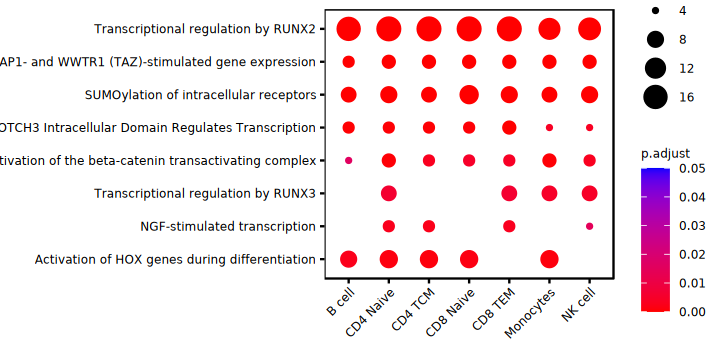

In [92]:
options(repr.plot.width = 6, repr.plot.height = 3)
p2 <- ggplot(df3, aes(x=group, y=Description, size=Count, color=p.adjust))+
    geom_point()+
    scale_color_gradient(low="red",high="blue", name="p.adjust", limits=c(0, 0.05))+
    # scale_color_gradient2(
    #     low = "red",
    #     mid = "gray",
    #     high = "blue",
    #     midpoint = 0.05,
    #     limits = c(0, 1),
    #     name = "p.adjust"
    # ) +
    ylab("")+xlab("")+
    # guides(color='none')+
    plot.format+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
p2

In [93]:
# save to file
pdf('summary_representative_G2_pathways_across_cell_types.pdf', width = 6, height = 2.5)
print(p2)
dev.off()

pdf 
  2

## Kmeans group specific regulatees

Kmeans group-specific regulatees are selected as top 2000 regulatees ranked by mean edge weight across Kmeans-specific TFs.

In [184]:
# create dir for results
dir.create(file.path(maindir, 'regulatees/'), showWarnings = FALSE)
dir.create(file.path(maindir, 'regulatees/GO'), showWarnings = FALSE)

In [9]:
# set working dir
setwd(file.path(maindir, 'regulatees/'))
tag <- ''
clusterNo <- 5
getwd()

[1] "/home/workspace/paper_figures_1031/regulatees"

In [10]:
meta2 <- read.csv(paste0(maindir,'meta_kmeans_',tag,'_',clusterNo,'.csv'), row.names=1)

In [24]:
get_csv_file <- function(regulators, fgs, label, input_dir='/home/workspace/output_20230310/'){

    # regulators: selected TFs
    # fgs: selected samples, in our case, the At-Risk/ERA patients
    # label: used for output file name
    # input_dir: taiji output dir
        
    read_plus <- function(x){

        dt <- fread(x)
        dt <- dt[weight>=1,] # pre-filter based on weight for acceleration
        dt <- dt[`:START_ID` %in% regulators]
        dt <- dt[,c(1:3)]
        dt$filename <- sub(".*Network/","",sub("/edges.*","",x))
        return(dt)

    }
    fl <- paste0(input_dir,"./Network/",fgs,"/edges_combined.csv")
    dt <- do.call("rbind", lapply(fl, read_plus))
    message("finished reading data")
    write.table(dt, paste0(label,"_regulatees.tsv"), quote = FALSE, row.names = FALSE)

}

In [188]:
files <- list.files('../kmeans_5/', pattern = 'G[0-9].*txt', full.names = T)
files

[1] "../kmeans_5//G1_p0.01_d0.5_gene141_wilcoxon.txt"
[2] "../kmeans_5//G2_p0.01_d0.5_gene409_wilcoxon.txt"
[3] "../kmeans_5//G3_p0.01_d0.5_gene65_wilcoxon.txt" 
[4] "../kmeans_5//G4_p0.01_d0.5_gene41_wilcoxon.txt" 
[5] "../kmeans_5//G5_p0.01_d0.5_gene101_wilcoxon.txt"

In [241]:
# it takes an hour to run
lapply(unique(meta2$kmeans), function(x){
    fg <- meta2 %>% filter(kmeans == x & subject.group2 == "At-Risk/ERA") %>% pull(id)
    regulators <- readLines(files[grep(x, files)])
    get_csv_file(regulators, fg, paste0(x,'_TFs_in_ARK_and_ERA_samples'))
})

finished reading data

finished reading data

finished reading data

finished reading data

finished reading data



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

In [ ]:
# top 1000 regulatees
# top 2000 regulatees
n = 1000
n = 2000
lapply(unique(meta2$kmeans), function(x){
    df1 <- read.table(paste0(x,'_TFs_in_ARK_and_ERA_samples_regulatees.tsv'), header = T) |> group_by(`X.END_ID`) |> summarise(mean_weight = mean(weight)) |> arrange(-mean_weight)
    df2 <- df1 |> filter(!grepl('[0-9]{5,}', `X.END_ID`))
    df2 |> top_n(mean_weight, n=n) |> pull(X.END_ID) |> writeLines(paste0(x,'_top', n, '_regulatees.txt'))
    gsea(paste0(x,'_top',n,'_regulatees.txt'), output_dir = 'GO/',showCategory = 20, go.height = 10, go.width = 7)
}) # OR run script 'Kmeans_specific_regulatees.r' instead

'select()' returned 1:1 mapping between keys and columns

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



### pathway plot

In [15]:
L <- list.files(path = 'GO/' , pattern = 'top1000.*csv', full.names = T)
L

[1] "GO//G1_top1000_regulatees_GO.csv" "GO//G2_top1000_regulatees_GO.csv"
[3] "GO//G3_top1000_regulatees_GO.csv" "GO//G4_top1000_regulatees_GO.csv"
[5] "GO//G5_top1000_regulatees_GO.csv"

In [16]:
# pathway summary plot
df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% filter(grepl('R-HSA', ID) & p.adjust<=0.05) %>% slice_min(order_by = p.adjust, n=30)%>%mutate(group=gsub('_.*','',gsub('.*/','',x)))}))
df$GeneRatio <- sapply(df$GeneRatio, function(x) eval(parse(text=x)))
df <- df %>% arrange(group, GeneRatio)
df$Description <- factor(df$Description, levels = unique(df$Description))
 
dim(df)
head(df)

[1]  8 10

ID            Description                          GeneRatio  BgRatio  
1 R-HSA-1482925 Acyl chain remodelling of PG         0.02040816 19/11009 
2 R-HSA-1482839 Acyl chain remodelling of PE         0.02551020 30/11009 
3 R-HSA-6809371 Formation of the cornified envelope  0.04591837 129/11009
4 R-HSA-6805567 Keratinization                       0.07653061 214/11009
5 R-HSA-373076  Class A/1 (Rhodopsin-like receptors) 0.08163265 335/11009
6 R-HSA-877300  Interferon gamma signaling           0.04347826 96/11009 
  pvalue       p.adjust    qvalue     
1 3.062332e-04 0.037946987 0.035916211
2 1.686245e-04 0.037946987 0.035916211
3 4.870454e-04 0.046366719 0.043885351
4 6.286386e-06 0.002992320 0.002832183
5 3.188822e-04 0.037946987 0.035916211
6 4.650808e-06 0.004004345 0.004004345
  geneID                                                                                                      
1 PLA2G4B/PLA2G2F/PLA2G2A/PLA2G4A                                                                             
2 PLA2G4B/PLA2G2F/PLA2G2A/PLA2G4A/PLAAT5                                                                      
3 KRT2/KRT73/LCE2D/KRT81/KRT5/KRT6A/KRT4/CASP14/KLK14                                                         
4 KRTAP9-4/KRT2/KRT73/KRTAP9-8/KRTAP6-2/LCE2D/KRTAP10-3/KRTAP11-1/KRTAP13-2/KRT81/KRT5/KRT6A/KRT4/CASP14/KLK14
5 SSTR4/SSTR3/GPR37L1/BDKRB1/AGTR1/RXFP1/CCL5/GHRL/FPR2/LPAR1/EDNRA/CXCR2/PTAFR/GPR39/HTR1B/SUCNR1            
6 HLA-DQB2/TRIM6/GBP4/TRIM5/GBP6/TRIM34/TRIM22/TRIM21/TRIM68/GBP2/SP100/TRIM2                                 
  Count group
1  4    G2   
2  5    G2   
3  9    G2   
4 15    G2   
5 16    G2   
6 12    G3

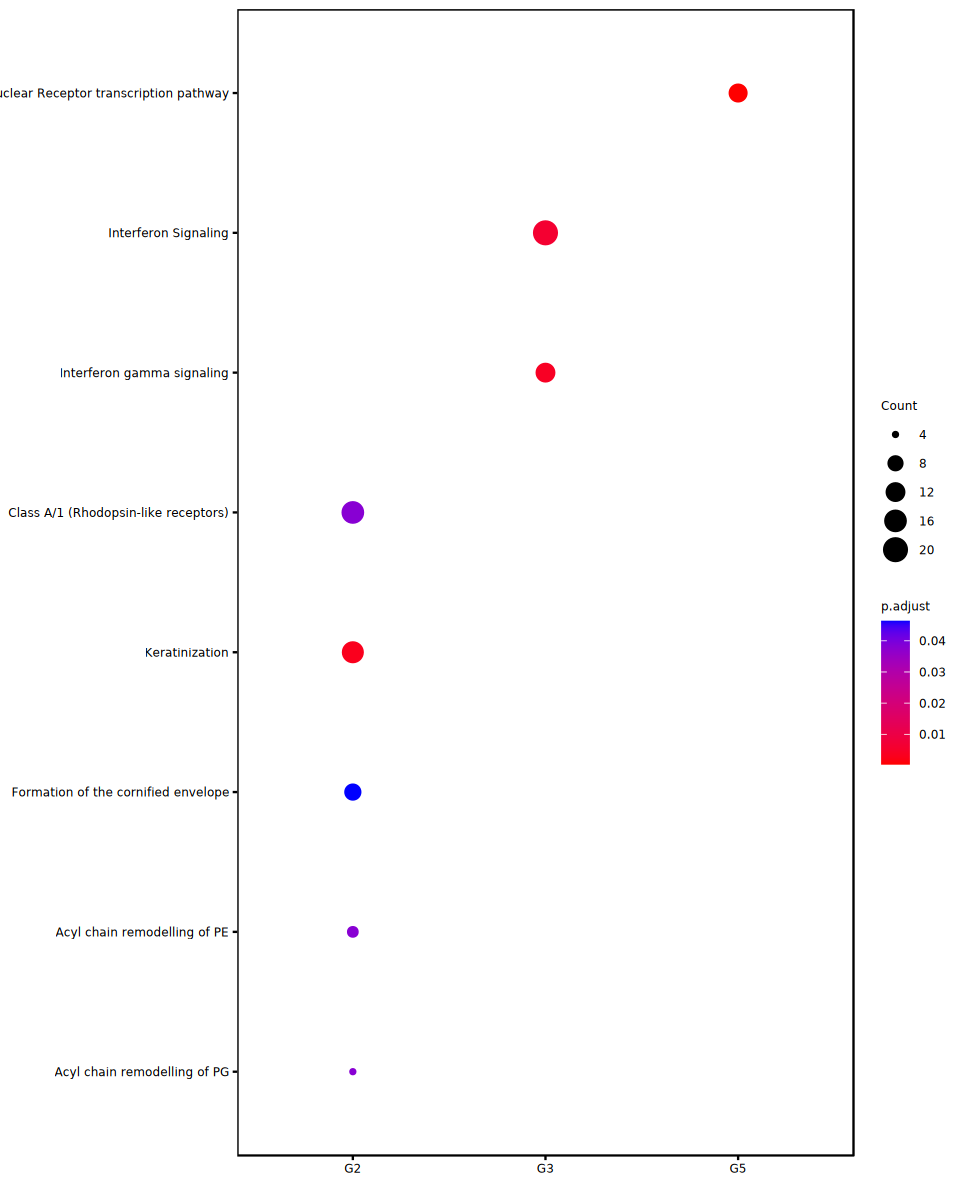

In [17]:
options(repr.plot.width = 8, repr.plot.height = 10)
p <- ggplot(df, aes(x=group, y=Description, size=Count, color=p.adjust))+
    geom_point()+scale_color_gradient(low="red",high="blue", name="p.adjust")+theme_bw()+
    ylab("")+xlab("")+plot.format
p

In [18]:
# pdf('Kmeans_group_specific_top2000_regulatee_pathway.pdf', width = 6, height = 10)
pdf('Kmeans_group_specific_top1000_regulatee_pathway.pdf', width = 4, height = 4)
print(p)
dev.off()

pdf 
  2

## top regulated genes

Now we have identified signature pathways along with involved TFs associated with RA pathogenesis. Taiji generated the regulatory network showing the regulatory relationship between TF and its target genes (**regulatee**) with edge weight, which represents the regulatory strength. Based on this, we can curate a list of representative regulatee genes by selecting the top 10 genes regulated by the signature TFs involved in each pathway ranked by the mean edge weight.

Required input: network files "/taiji_output/Network/sample*/edges_combined.csv". Each sample/pseudo-bulk cluster has one network file.

In [47]:
setwd(maindir)

In [19]:
# read signature TFs
pathways <- c('SUMOylation of intracellular receptors','Transcriptional regulation by RUNX2','YAP1- and WWTR1 (TAZ)-stimulated gene expression','Deactivation of the beta-catenin transactivating complex','NOTCH3 Intracellular Domain Regulates Transcription')
tfs <- read.csv(paste0(maindir,'/kmeans_5/GO/G2_p0.01_d0.5_gene409_wilcoxon_GO.csv')) |> filter(Description %in% pathways) |> select(Description, p.adjust,geneID)
head(tfs)
dim(tfs)

Description                                              p.adjust    
1 Transcriptional regulation by RUNX2                      1.937194e-10
2 YAP1- and WWTR1 (TAZ)-stimulated gene expression         1.016182e-06
3 SUMOylation of intracellular receptors                   4.572997e-06
4 NOTCH3 Intracellular Domain Regulates Transcription      2.273632e-05
5 Deactivation of the beta-catenin transactivating complex 3.583923e-04
  geneID                                                                                      
1 SP7/SOX9/DLX6/NKX3-2/HAND2/DLX5/HEY1/ZNF521/MSX2/TWIST1/TWIST2/SATB2/GLI3/AR/HES1/HEY2/SMAD1
2 NKX2-5/GATA4/TEAD4/TEAD1/TEAD2/TEAD3                                                        
3 PGR/NR5A1/NR5A2/NR1I2/THRB/AR/PPARG                                                         
4 HES5/HEYL/HEY1/HES1/HEY2/PBX1                                                               
5 SOX9/SOX2/SOX6/SOX7/TCF7L1/SOX13

[1] 5 3

In [20]:
# signature TF list
regulators <- unique(unlist(lapply(pathways, function(x) {
    r <- tfs |> filter(Description==x) |> pull(geneID) 
    strsplit(r,'/')[[1]]
})))
length(regulators)

[1] 37

In [21]:
tfs

Description                                              p.adjust    
1 Transcriptional regulation by RUNX2                      1.937194e-10
2 YAP1- and WWTR1 (TAZ)-stimulated gene expression         1.016182e-06
3 SUMOylation of intracellular receptors                   4.572997e-06
4 NOTCH3 Intracellular Domain Regulates Transcription      2.273632e-05
5 Deactivation of the beta-catenin transactivating complex 3.583923e-04
  geneID                                                                                      
1 SP7/SOX9/DLX6/NKX3-2/HAND2/DLX5/HEY1/ZNF521/MSX2/TWIST1/TWIST2/SATB2/GLI3/AR/HES1/HEY2/SMAD1
2 NKX2-5/GATA4/TEAD4/TEAD1/TEAD2/TEAD3                                                        
3 PGR/NR5A1/NR5A2/NR1I2/THRB/AR/PPARG                                                         
4 HES5/HEYL/HEY1/HES1/HEY2/PBX1                                                               
5 SOX9/SOX2/SOX6/SOX7/TCF7L1/SOX13

In [22]:
# selected sample list
fg <- meta2 %>% filter(kmeans == 'G2' & subject.group2 == "At-Risk/ERA") %>% pull(id)
length(fg)

[1] 210

In [25]:
# this step takes ~30 min
# to save time, the output file is provided for demo purpose so that this step can be skipped
get_csv_file(regulators, fg, '37_signature_TFs_vs_all_genes')

finished reading data



In [27]:
dt <- read.csv('37_signature_TFs_vs_all_genes_regulatees.tsv', sep=' ')
names(dt) <- c("regulator","regulatees", "weight","sample")
dt <- dt[!grepl("[0-9]{3}", dt$regulatees),]
dt <- dt |> group_by(regulator, regulatees) |> summarise(mean_edge_weight = mean(weight))
head(dt)
dim(dt)

`summarise()` has grouped output by 'regulator'. You can override using the
`.groups` argument.


regulator regulatees mean_edge_weight
1 AR        A2M        2.324337        
2 AR        A2M-AS1    2.954782        
3 AR        A3GALT2    3.162262        
4 AR        AAAS       1.934746        
5 AR        AACS       1.643769        
6 AR        AADAT      2.959318

[1] 94998     3

In [28]:
tfs$gene <- unlist(lapply(pathways, function(x){
    regulators <- tfs |> filter(Description==x) |> pull(geneID) 
    regulators <- strsplit(regulators,'/')[[1]]
    regulatee <- dt |> filter(regulator %in% regulators) |> group_by(regulatees) |> summarise(mean_mean_ew=mean(mean_edge_weight)) |> slice_max(mean_mean_ew, n =10) |> pull(regulatees)    
    paste0(regulatee, collapse = '/')
}))

In [29]:
head(tfs)

Description                                              p.adjust    
1 Transcriptional regulation by RUNX2                      1.937194e-10
2 YAP1- and WWTR1 (TAZ)-stimulated gene expression         1.016182e-06
3 SUMOylation of intracellular receptors                   4.572997e-06
4 NOTCH3 Intracellular Domain Regulates Transcription      2.273632e-05
5 Deactivation of the beta-catenin transactivating complex 3.583923e-04
  geneID                                                                                      
1 SP7/SOX9/DLX6/NKX3-2/HAND2/DLX5/HEY1/ZNF521/MSX2/TWIST1/TWIST2/SATB2/GLI3/AR/HES1/HEY2/SMAD1
2 NKX2-5/GATA4/TEAD4/TEAD1/TEAD2/TEAD3                                                        
3 PGR/NR5A1/NR5A2/NR1I2/THRB/AR/PPARG                                                         
4 HES5/HEYL/HEY1/HES1/HEY2/PBX1                                                               
5 SOX9/SOX2/SOX6/SOX7/TCF7L1/SOX13                                                            
  gene                                                                                      
1 FCRL4/FBXL16/RPL7P51/SIGLEC5/RPL7P33/IRGM/GP1BB/PPIAP40/EEF1GP3/ADGRG7                    
2 FCRL4/RPL7P51/RPL7P33/GP1BB/EEF1GP3/ADGRG7/ACTBP2/LYZ/CTSLP3/PPIAP28                      
3 SPECC1/ESYT2/NCAPG2/WDR60/TUBA8/COX10-AS1/HS3ST3B1/GATA6-AS1/BLOC1S6/HMGN2P46/SLC30A4/SQOR
4 MAP3K8/CDADC1/RPL31P7/RORA/MTMR10/SLC22A2/CCER1/RPL34P6/PAICS/FLT1P1/XCR1                 
5 EDRF1/VCX/FICD/MTRF1L/IGLV4-3/ELF1/KBTBD6/KBTBD7/MTRF1/WBP4

In [30]:
write.csv(tfs, '../tables/Table_sig_pathways_TFs_regulatees.csv')

## G2-specific TFs' regulatees

In [67]:
# create dir for results
dir.create(file.path(maindir, 'regulatees/G2/'), showWarnings = FALSE)
dir.create(file.path(maindir, 'regulatees/G2/GO'), showWarnings = FALSE)

In [38]:
setwd(paste0(maindir, 'regulatees/G2/GO/'))
getwd()

[1] "/home/workspace/paper_figures_1031/regulatees/G2/GO"

run script G2_specific_TFs_regulatees.r in folder 'regulatees/' first to gather the pathway file for each TF's top regulatees

### selected G2 TFs

In [41]:
regulators <- readRDS('../../../kmeans_5/signature_tfs.rds')

In [57]:
L <- list.files(pattern = paste0(paste0(regulators[['SUMO']], collapse = '.*csv|'),'.*csv'), full.names = T)
length(L)

[1] 13

In [65]:
L

[1] "./ARNT2_top500_regulatees_GO.csv"  "./AR_top500_regulatees_GO.csv"    
 [3] "./BARX2_top500_regulatees_GO.csv"  "./NR1I2_top500_regulatees_GO.csv" 
 [5] "./NR5A1_top500_regulatees_GO.csv"  "./NR5A2_top500_regulatees_GO.csv" 
 [7] "./PGR_top500_regulatees_GO.csv"    "./PPARG_top500_regulatees_GO.csv" 
 [9] "./SATB2_top500_regulatees_GO.csv"  "./TFAP2A_top500_regulatees_GO.csv"
[11] "./TFAP2B_top500_regulatees_GO.csv" "./TFAP2C_top500_regulatees_GO.csv"
[13] "./THRB_top500_regulatees_GO.csv"

In [66]:
df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% 
                                             filter(grepl('R-HSA', ID) & p.adjust<=0.07) %>% 
                                             # filter(p.adjust<=0.05) %>% 
                                             mutate(TF=gsub('_.*','',gsub('.*/','',x)))}))
df$GeneRatio <- sapply(df$GeneRatio, function(x) eval(parse(text=x)))
df <- df %>% arrange(TF, GeneRatio)
df$Description <- factor(df$Description, levels = unique(df$Description))
dim(df)
head(df)

[1]  6 10

ID           
1 R-HSA-1236977
2 R-HSA-9679506
3 R-HSA-9022699
4 R-HSA-3371497
5 R-HSA-8986944
6 R-HSA-5628897
  Description                                                                        
1 Endosomal/Vacuolar pathway                                                         
2 SARS-CoV Infections                                                                
3 MECP2 regulates neuronal receptors and channels                                    
4 HSP90 chaperone cycle for steroid hormone receptors (SHR) in the presence of ligand
5 Transcriptional Regulation by MECP2                                                
6 TP53 Regulates Metabolic Genes                                                     
  GeneRatio  BgRatio   pvalue       p.adjust   qvalue    
1 0.01526718 11/11009  0.0000906865 0.06823489 0.06475296
2 0.08778626 414/11009 0.0001385480 0.06823489 0.06475296
3 0.33333333 17/11009  0.0046258430 0.03700674 0.01947723
4 0.33333333 55/11009  0.0149143326 0.04480484 0.02358149
5 0.33333333 62/11009  0.0168018138 0.04480484 0.02358149
6 0.33333333 87/11009  0.0235231344 0.04704627 0.02476119
  geneID                                                                                                                                         
1 HLA-A/HLA-B/HLA-C/HLA-G                                                                                                                        
2 AP2B1/FXYD2/FXYD6/GSK3A/HLA-A/HLA-B/HLA-C/HLA-G/HNRNPA1/MAP3K7/MGAT1/MGAT5/NFE2L2/NOD1/NUP210/NUP54/REST/ROCK1/SAP18/SAP30/SNRPD1/SRPK2/ZDHHC20
3 FKBP5                                                                                                                                          
4 FKBP5                                                                                                                                          
5 FKBP5                                                                                                                                          
6 DDIT4                                                                                                                                          
  Count TF   
1  4    NR1I2
2 23    NR1I2
3  1    PGR  
4  1    PGR  
5  1    PGR  
6  1    PGR

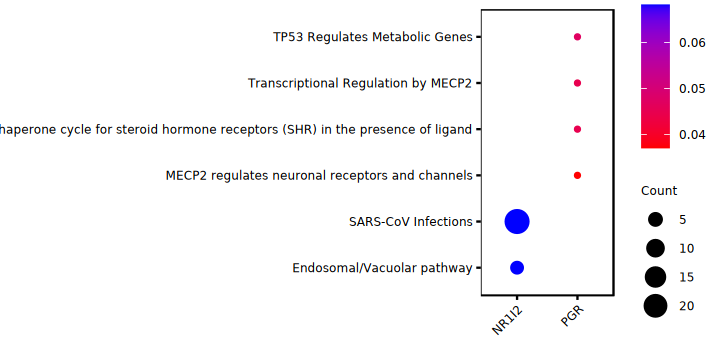

In [67]:
options(repr.plot.width = 6, repr.plot.height = 3)
p <- ggplot(df, aes(x=TF, y=Description, size=Count, color=p.adjust))+
    geom_point()+scale_color_gradient(low="red",high="blue", name="p.adjust")+theme_bw()+
    ylab("")+xlab("")+theme(axis.text.x = element_text(angle = 45, hjust = 1))+plot.format
p

In [149]:
pdf('hp_SUMO_TFs_whose_regulatees_in_signature_pathways.pdf', width = 4.5, height = 2.5)
print(p)
dev.off()

pdf 
  2

### all G2 TFs

In [68]:
# summary of TF's regulatee pathways
L <- list.files(pattern = paste0('top500.*csv'), full.names = T)
length(L)

[1] 241

In [69]:
df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% filter(grepl('R-HSA', ID) & p.adjust<=0.05) %>% mutate(TF=gsub('_.*','',gsub('.*/','',x)))}))
df$GeneRatio <- sapply(df$GeneRatio, function(x) eval(parse(text=x)))
df <- df %>% arrange(TF, GeneRatio)
df$Description <- factor(df$Description, levels = unique(df$Description))
dim(df)
head(df)

[1] 3887   10

ID            Description               GeneRatio  BgRatio  pvalue     
1 R-HSA-5625970 RHO GTPases activate KTN1 0.01140684 11/11009 0.001929289
2 R-HSA-9013418 RHOBTB2 GTPase cycle      0.01520913 23/11009 0.001970267
3 R-HSA-9013424 RHOV GTPase cycle         0.01901141 38/11009 0.001972681
4 R-HSA-9013420 RHOU GTPase cycle         0.01901141 40/11009 0.002487740
5 R-HSA-5689901 Metalloprotease DUBs      0.02281369 37/11009 0.000219031
6 R-HSA-156902  Peptide chain elongation  0.02661597 90/11009 0.005676372
  p.adjust    qvalue      geneID                                     Count
1 0.018387305 0.015915079 CDC42/KLC1/KTN1                            3    
2 0.018424838 0.015947566 CDC37/DBN1/HSP90AA1/TXNL1                  4    
3 0.018424838 0.015947566 CDC42/PAK1/PAK4/TXNL1/USP9X                5    
4 0.022779896 0.019717074 CDC42/PAK1/PAK4/TXNL1/USP9X                5    
5 0.002248077 0.001945816 H2AC11/H2AC12/H2AC13/H2AC14/H2AC15/H2AC16  6    
6 0.047763347 0.041341430 RPL24/RPL26/RPL29/RPL36/RPL36AL/RPS29/RPS5 7    
  TF        
1 AC023509.3
2 AC023509.3
3 AC023509.3
4 AC023509.3
5 AC023509.3
6 AC023509.3

In [70]:
write.csv(df,'pathways_summary_top500_regulatees.csv')

In [77]:
df |> filter(grepl('RUNX3', Description))

ID            Description                                 GeneRatio  BgRatio 
1 R-HSA-8878159 Transcriptional regulation by RUNX3         0.03804348 96/11009
2 R-HSA-8941858 Regulation of RUNX3 expression and activity 0.02621723 55/11009
  pvalue       p.adjust   qvalue     
1 0.0011077903 0.03538008 0.026228766
2 0.0003422591 0.01237022 0.008942483
  geneID                                      Count TF     
1 PSMB1/PSMC1/PSMD10/PSMD3/RUNX1/TCF7/TEAD2   7     NKX6-2 
2 PSMA5/PSMB6/PSMC1/PSMC4/RPS27A/SMURF1/UBA52 7     ZSCAN10

In [71]:
df2 <- df %>% filter(grepl('SUMO|NOTCH1|NOTCH3|beta-catenin|YAP1|TGF|NF-kB',Description)) %>%
        mutate(D2 = ifelse(grepl('SUMO', Description), 'SUMO', 
                           ifelse(grepl('NOTCH1', Description), 'NOTCH1', 
                                  ifelse(grepl('NOTCH3', Description), 'NOTCH3',                            
                                         ifelse(grepl('beta-catenin', Description), 'beta-catenin', 
                                                ifelse(grepl('YAP1', Description), 'YAP1', 
                                                       # ifelse(grepl('NOTCH3', Description), 'NOTCH3', 
                                                              ifelse(grepl('NF-kB', Description), 'NF-kB','TGF'))))))) %>% group_by(D2)
head(df2)
dim(df2)

ID            Description                                              
1 R-HSA-201722  Formation of the beta-catenin:TCF transactivating complex
2 R-HSA-201722  Formation of the beta-catenin:TCF transactivating complex
3 R-HSA-2871837 FCERI mediated NF-kB activation                          
4 R-HSA-3108232 SUMO E3 ligases SUMOylate target proteins                
5 R-HSA-2990846 SUMOylation                                              
6 R-HSA-201722  Formation of the beta-catenin:TCF transactivating complex
  GeneRatio  BgRatio   pvalue       p.adjust     qvalue      
1 0.05703422 90/11009  2.919637e-09 1.298543e-07 1.123950e-07
2 0.03875969 90/11009  4.621241e-05 4.325482e-02 3.993725e-02
3 0.50000000 82/11009  1.484209e-02 2.815766e-02           NA
4 0.04945055 183/11009 3.352539e-03 2.383655e-02 2.036226e-02
5 0.06043956 189/11009 2.981843e-04 2.231674e-03 1.906397e-03
6 0.12087912 90/11009  3.544441e-20 1.680065e-18 1.435188e-18
  geneID                                                                                                                             
1 CREBBP/H2AC14/H2AZ2/H2BC10/H2BC11/H2BC12/H2BC13/H2BC14/H2BC15/H3C10/H3C11/H3C8/H4C11/H4C13/H4C9                                    
2 AXIN2/H2AC6/H2AC8/H2BC3/H2BC4/H2BC6/H2BC8/H3C3/MEN1/TCF7                                                                           
3 CARD11                                                                                                                             
4 H4C1/H4C11/H4C12/H4C2/HDAC7/MITF/MRTFA/NR4A2/PARK7                                                                                 
5 H4C1/H4C11/H4C12/H4C2/HDAC7/MITF/MRTFA/NR4A2/PARK7/SAE1/SENP5                                                                      
6 CTNNB1/H2AC14/H2AC4/H2AC6/H2AC8/H2BC10/H2BC13/H2BC14/H2BC15/H2BC4/H2BC5/H2BC8/H3C1/H3C10/H3C11/H3C2/H3C6/H3C8/H4C1/H4C11/H4C12/H4C2
  Count TF           D2          
1 15    AC023509.3   beta-catenin
2 10    ALX3         beta-catenin
3  1    BNC1         NF-kB       
4  9    BORCS8-MEF2B SUMO        
5 11    BORCS8-MEF2B SUMO        
6 22    BORCS8-MEF2B beta-catenin

[1] 140  11

In [ ]:
# # organize D2
# df2$D2 <- factor(df2$D2, levels=c('beta-catenin'))

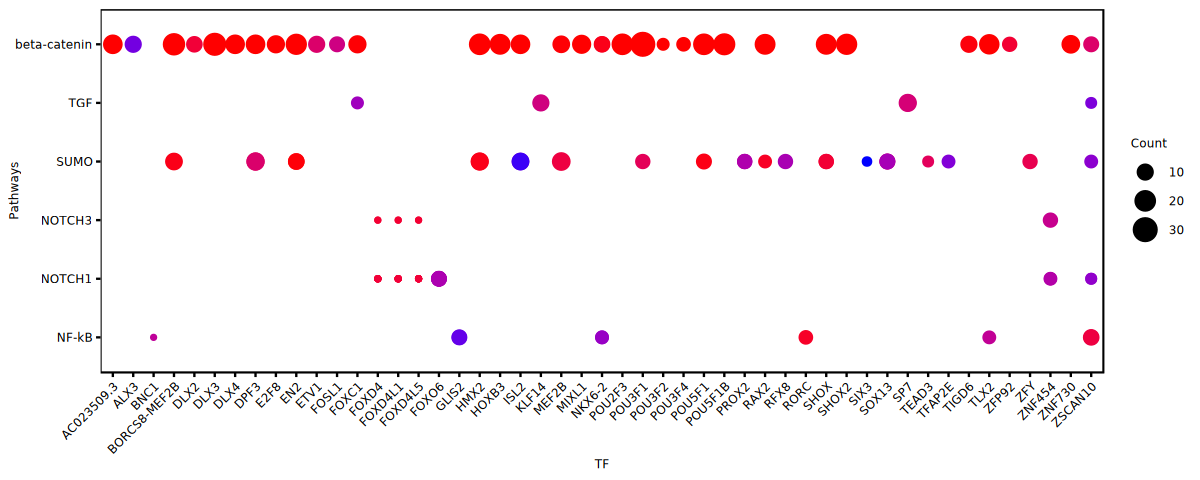

In [72]:
options(repr.plot.width=10, repr.plot.height=4)
p <- ggplot(df2, aes(x=TF, y=D2, size=Count, color=p.adjust))+
    geom_point()+scale_color_gradient(low="red",high="blue")+theme_bw()+ylab("")+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))+ ylab("Pathways")+guides(color='none')+plot.format
p

In [94]:
pdf('hp_C2_TFs_whose_regulatees_in_signature_pathways.pdf', width = 9, height = 2)
print(p)
dev.off()

pdf 
  2

In [95]:
# tmp <- df |> group_by(Description) |> summarise(n=n()) |> arrange(-n)
# # tmp |> filter(grepl('NF-kB', Description))
# tmp |> filter(grepl('NOTCH', Description))
getwd()

[1] "/home/workspace/paper_figures_1031/kmeans_cell_type_5/GO"

## pathogenic genes

In [5]:
# rna <- read.csv('../output_20241031/post-analysis/rna.csv', row.names = 1)
rna <- read.csv('rna.csv', row.names = 1)

In [8]:
# meta <- read.csv('../output_20241031/post-analysis/meta.csv', row.names = 1)
meta <- read.csv('meta_kmeans__5.csv', row.names = 1)

In [19]:
patho_genes <- read.csv('../output_20230310/post-analysis/gene_list_v2_rna_no_receptors.csv', row.names = 1)$gene
rna2 <- rna[intersect(patho_genes,rownames(rna)),meta$id]

In [20]:
head(rna2)
dim(rna2)

B001_PB00001_C1 B001_PB00001_C2 B001_PB00001_C3 B001_PB00001_C4
IL10      0.1555814       0.0000000       0.4239064       0.0000000      
IL11      0.0000000       0.0000000       0.0000000       0.2392465      
IL12A     0.4667442       0.2318385       0.8478127       0.0000000      
IL12A-AS1 0.0000000       0.0000000       0.2119532       0.0000000      
IL12B     0.0000000       0.0000000       0.0000000       0.0000000      
IL13      0.0000000       0.0000000       0.0000000       0.0000000      
          B001_PB00001_C5 B001_PB00001_C6 B001_PB00001_C7 B001_PB00001_C8
IL10      0.3530485       0               0               1.368363       
IL11      0.0000000       0               0               0.000000       
IL12A     0.0000000       0               0               0.000000       
IL12A-AS1 0.0000000       0               0               0.000000       
IL12B     0.0000000       0               0               0.000000       
IL13      0.0000000       0               0               0.000000       
          B001_PB00001_C9 B001_PB00001_C10 ⋯ B002_PB00060_C12 B002_PB00060_C13
IL10      0               0.00000          ⋯ 0.0000000        0               
IL11      0               0.00000          ⋯ 0.0000000        0               
IL12A     0               0.68046          ⋯ 0.7202657        0               
IL12A-AS1 0               0.00000          ⋯ 0.0000000        0               
IL12B     0               0.00000          ⋯ 0.0000000        0               
IL13      0               0.00000          ⋯ 0.0000000        0               
          B002_PB00060_C14 B002_PB00060_C15 B002_PB00060_C17 B002_PB00060_C18
IL10      0.7749313        0                0                0               
IL11      0.0000000        0                0                0               
IL12A     0.7749313        0                0                0               
IL12A-AS1 0.0000000        0                0                0               
IL12B     0.0000000        0                0                0               
IL13      0.0000000        0                0                0               
          B002_PB00060_C20 B002_PB00060_C24 B002_PB00060_C26 B002_PB00060_C28
IL10      0                0.000000         0                0.000000        
IL11      0                0.000000         0                0.000000        
IL12A     0                0.000000         0                3.309823        
IL12A-AS1 0                2.353866         0                0.000000        
IL12B     0                0.000000         0                0.000000        
IL13      0                0.000000         0                0.000000

[1]  186 1610

In [21]:
write.csv(rna2, '../output_20241031/post-analysis/rna_186_genes.csv')

### DEG identification

# heatmap

In [189]:
setwd(maindir)
print(maindir)

[1] "/home/workspace/paper_figures_1031/"


## top Kmeans-specific TFs

In [191]:
# take the top ten TFs for each group and plot partial heatmap
L <- list.files(path = paste0('kmeans_',clusterNo,'/'), pattern = "G.*p0.01_d0.5.*txt", full.names = T)
TFs <- lapply(L, function(x) readLines(x)[1:10])
names(TFs) <- paste0("G",1:clusterNo)
annotation_row <- tibble("TF.group" = unlist(lapply(1:length(TFs), function(x) {rep(names(TFs[x]), length(TFs[[x]]))})),"TFs" = unlist(TFs))
annotation_row[annotation_row$TF.group=="G2","TFs"] <- c("ZNF304","HKR1","NFE4","CTCFL","ETV4","ZNF254","SOX9","FOXL2","VSX2","HEY1")
# annotation_row[annotation_row$TF.group=="G2","TFs"] <- c("ZNF304","HKR1","SP7","ETV4","GLIS1","ZNF254","SOX9","FOXL2","VSX2","HEY1")

annotation_row <- annotation_row |> group_by(TFs) |> filter(n()==1)|> tibble::column_to_rownames("TFs")
head(annotation_row)
nrow(annotation_row)

TF.group
SPI1  G1      
KLF4  G1      
JDP2  G1      
CEBPA G1      
ETS2  G1      
BACH1 G1

[1] 50

In [192]:
get_heatmap <- function(df, info, row_ann, mycolors,...){
        
    info <- info %>% dplyr::filter(id %in% colnames(df)) %>% dplyr::arrange(kmeans, preClust)
   
    # sort df make sure the order of info and df matched
    df <- df[,match(info$id,names(df))]

    annotation_col = data.frame(
      # subject.group = info$subject.group,
      # cell.type = info$preClust,
      subject.group2 = info$subject.group2,
      subject.group3 = info$subject.group3,
      kmeans = info$kmeans
    )
    rownames(annotation_col) = names(df)
  
    df2 <- df[rownames(row_ann),rownames(annotation_col)]
    print(dim(df2))

    p1 <- pheatmap(df2, 
                 fontsize = 7, angle_col = 90, 
                 cellwidth = 0.2, cellheight = 7,
                 cluster_cols = F, cluster_rows = F, 
                 clustering_distance_cols = 'correlation', 
                 clustering_distance_rows = 'correlation', 
                 clustering_method = 'average',
                 annotation_row = row_ann,
                 annotation_col = annotation_col,
                 breaks = seq(-2, 4, by = 0.1),
                 show_colnames = F,
                 color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(seq(-2, 4, by = 0.1))),
                 annotation_names_row = F, annotation_names_col = F,
                 annotation_colors = mycolors, border_color = NA,...)
    return(p1)
}

In [193]:
mycolors$TF.group <- mycolors$kmeans

[1]   50 1610


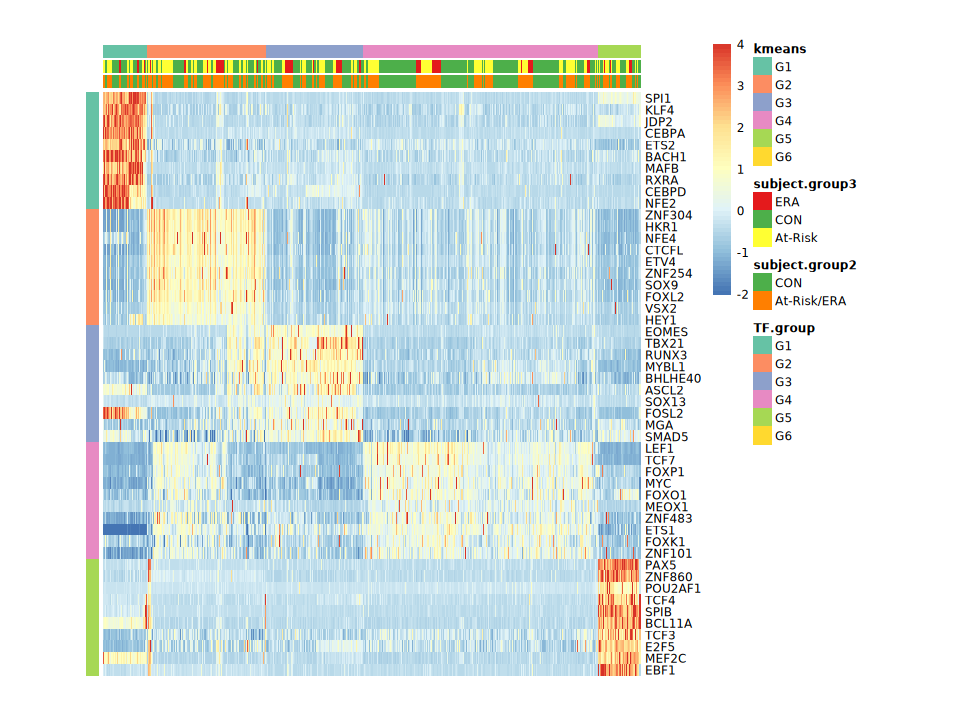

In [194]:
options(repr.plot.width=8, repr.plot.height=6)
p1 <- get_heatmap(pr_normed2, meta2, mycolors, row_ann=annotation_row)

In [195]:
# save to file
pdf(paste0("hp_",tag,"_",clusterNo,"_top10_TFs.pdf"))
print(p1)
dev.off()

pdf 
  2

## all TFs

In [196]:
get_heatmap <- function(df, info, mycolors,...){
        
    info <- info |> dplyr::filter(id %in% colnames(df)) |> arrange(kmeans,preClust)
   
    # sort df make sure the order of info and df matched
    df <- df[,match(info$id,names(df))]

    annotation_col = data.frame(
      subject.group = info$subject.group,
      cell.type = info$preClust,
      subject.subjectGuid = info$subject.subjectGuid,
      kmeans = info$kmeans
    )
    rownames(annotation_col) = names(df)
  
    p1 <- pheatmap(df, 
                 fontsize = 7, angle_col = 90, 
                 cellwidth = 0.3, cellheight = 0.3,
                 clustering_distance_cols = 'correlation', 
                 clustering_distance_rows = 'correlation', 
                 clustering_method = 'average',
                 annotation_col = annotation_col,
                 breaks = seq(-2, 4, by = 0.1),
                 show_colnames = F, 
                 color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(seq(-2, 4, by = 0.1))),
                 annotation_names_row = T, annotation_names_col = T,
                 annotation_colors = mycolors, 
                 border_color = NA,...)
    return(p1)
}

In [12]:
tag <- "" # can be customized for different versions of result
clusterNo <- 5
meta2 <- read.csv(paste0(maindir,'meta_kmeans_',tag,'_',clusterNo,'.csv'), row.names=1)

In [198]:
dim(pr_normed2)

[1] 1047 1610

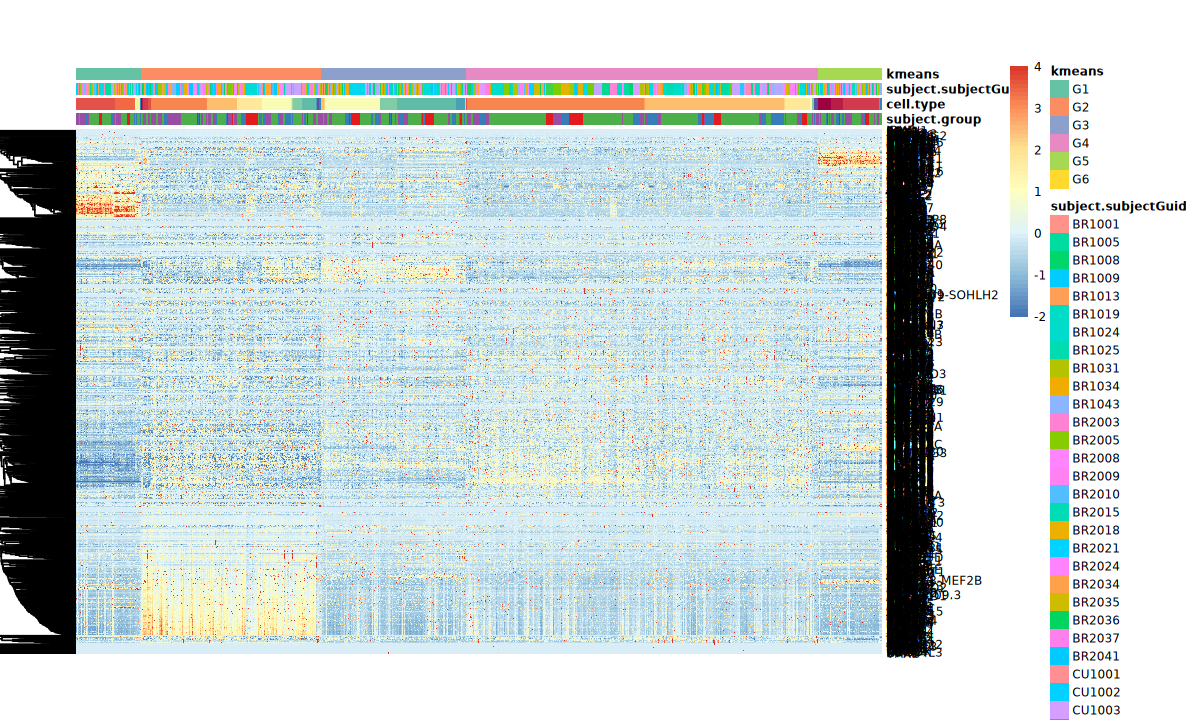

In [199]:
options(repr.plot.width=10, repr.plot.height=6)
p1 <- get_heatmap(pr_normed2, meta2, mycolors, cluster_cols=F)

In [200]:
# save to file
# pdf("hp_normed2_all_TFs.pdf", height=10, width = 8)
# pdf(paste0("hp_normed2_all_TFs_by_kmeans_k",clusterNo,".pdf"), height=10, width = 8)
pdf(paste0("hp_normed2_all_TFs_",tag,"_",clusterNo,".pdf"), height=6, width = 11)
print(p1)
dev.off()

pdf 
  2

In [210]:
# the total heatmap with partial labels
L <- list.files(path = 'kmeans_5/', pattern = "G.*p0.01_d0.5.*txt", full.names = T)
TFs <- unlist(lapply(L, function(x) readLines(x)[1:10]))
TFs

[1] "SPI1"    "KLF4"    "JDP2"    "CEBPA"   "ETS2"    "BACH1"   "MAFB"   
 [8] "RXRA"    "CEBPD"   "NFE2"    "ZNF304"  "WT1"     "SP9"     "HKR1"   
[15] "TFAP2C"  "SP5"     "TFAP2B"  "SP7"     "PAX7"    "ETV4"    "EOMES"  
[22] "TBX21"   "RUNX3"   "MYBL1"   "BHLHE40" "ASCL2"   "SOX13"   "FOSL2"  
[29] "MGA"     "SMAD5"   "LEF1"    "TCF7"    "FOXP1"   "MYC"     "FOXO1"  
[36] "MEOX1"   "ZNF483"  "ETS1"    "FOXK1"   "ZNF101"  "PAX5"    "ZNF860" 
[43] "POU2AF1" "TCF4"    "SPIB"    "BCL11A"  "TCF3"    "E2F5"    "MEF2C"  
[50] "EBF1"

In [201]:
source("addFlag.R")

In [213]:
p2 <- addFlag(p1, TFs, repel.degree = 1)

In [214]:
pdf('hp_normed2_allTFs_partial_labels.pdf', width = 12, height = 8)
grid.draw(p2)
dev.off()

pdf 
  2

## sort by cell type

In [10]:
hp_basic <- function(df,info,mycolors,...){
  
    info <- info %>% dplyr::filter(id %in% colnames(df)) %>% 
            dplyr::filter(preClust %in% selected_cell_states) %>%
            dplyr::arrange(preClust, kmeans, subject.group3)

    # sort df make sure the order of info and df matched
    df <- df[,match(info$id,names(df))]

    annotation_col = data.frame(
      cell.type = info$preClust,
      subject.group2 = info$subject.group2,
      subject.group3 = info$subject.group3,
      kmeans = info$kmeans
    )
    rownames(annotation_col) = names(df)

    p1 <- pheatmap::pheatmap(df, 
                    fontsize = 7, show_rownames = F,
                    angle_col = 90, show_colnames = F,
                    cluster_cols = F, cluster_rows = T, 
                    cellwidth = 0.3, cellheight = 0.1,
                    clustering_distance_cols = 'correlation', 
                    clustering_distance_rows = 'correlation', 
                    clustering_method = 'average',
                    annotation_col = annotation_col,
                    annotation_colors = mycolors, border_color = NA,
                    # breaks = seq(-2, 4, by = 0.1),
                    color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(seq(-2, 4, by = 0.1))),...)
    return(p1)
  
}

In [15]:
pr_normed2[pr_normed2 > 4] <- 4
pr_normed2[pr_normed2 < -2] <- -2
dim(pr_normed2)

[1] 1077 1610

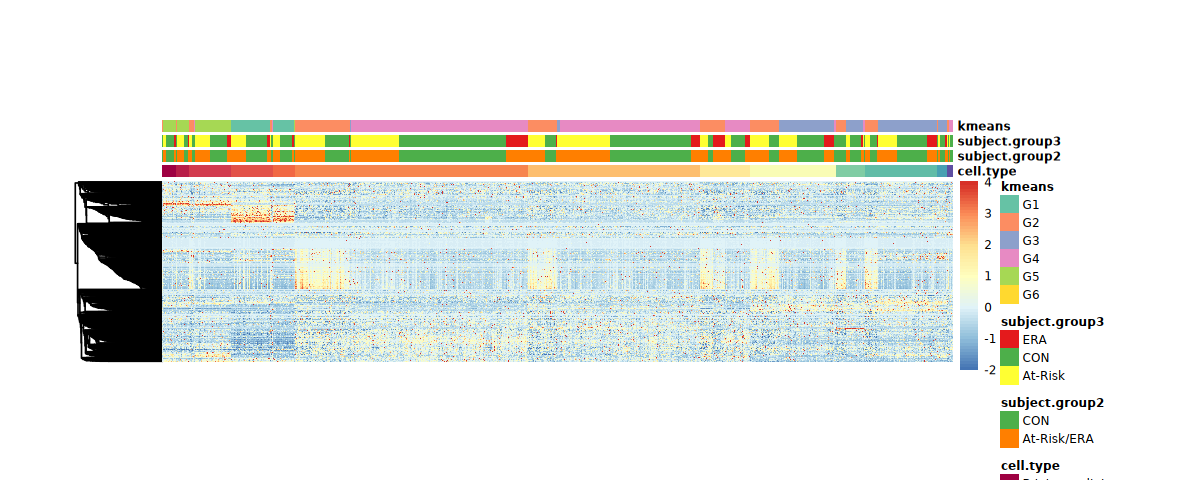

In [16]:
options(repr.plot.width=10, repr.plot.height=4)
selected_cell_states <- c("B intermediate","B memory", "B naive", "CD14 Mono", "CD16 Mono","CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","MAIT","NK","NK_CD56bright","Treg")
p2 <- hp_basic(pr_normed2, meta2, mycolors)

In [217]:
# save to file
pdf(paste0("hp_normed2_by_cell_type.pdf"), height=10, width = 10)
print(p2)
dev.off()

pdf 
  2

## participants in G2 across cell types

We want to check the number of G2 clusters in each cell across At-Risk/ERA participants.

In [26]:
C_target = 'G2'
g <- "subject.group2"
tag <- ""
clusterNo <- 5

In [27]:
file <- paste0('meta_kmeans_',tag,'_',clusterNo,'.csv')
meta3 <- read.csv(file, row.names = 1) %>% 
        mutate(preClust2 = ifelse(preClust %in% c("B memory", "B naive", "B intermediate"), "B cell", ifelse(preClust %in% c("CD16 Mono", "CD14 Mono"), "Monocytes", ifelse(preClust %in% c("NK", "NK_CD56bright"), "NK cell", preClust))),
                kmeans2 = ifelse(kmeans==C_target, kmeans, "other"))
head(meta3)
dim(meta3)

preClust  cluster purity cells RNA_cells ATAC_cells sample      
1 CD14 Mono C1      0.940  5329  4327      1002       B001_PB00001
2 NK        C2      0.873  1946  1391       555       B001_PB00001
3 B naive   C3      0.946  1830  1511       319       B001_PB00001
4 MAIT      C4      0.840  1588  1200       388       B001_PB00001
5 CD16 Mono C5      0.425  1062   392       670       B001_PB00001
6 CD4 TCM   C6      0.726  1059   104       955       B001_PB00001
  id              sample.visitName subject.biologicalSex ⋯ sample.sampleKitGuid
1 B001_PB00001_C1 Flu Year 1 Day 0 Female                ⋯ KT00001             
2 B001_PB00001_C2 Flu Year 1 Day 0 Female                ⋯ KT00001             
3 B001_PB00001_C3 Flu Year 1 Day 0 Female                ⋯ KT00001             
4 B001_PB00001_C4 Flu Year 1 Day 0 Female                ⋯ KT00001             
5 B001_PB00001_C5 Flu Year 1 Day 0 Female                ⋯ KT00001             
6 B001_PB00001_C6 Flu Year 1 Day 0 Female                ⋯ KT00001             
  sample.visitDetails             sample.daysSinceFirstVisit subject.race
1 N/A - Flu-Series Timepoint Only 0                          Caucasian   
2 N/A - Flu-Series Timepoint Only 0                          Caucasian   
3 N/A - Flu-Series Timepoint Only 0                          Caucasian   
4 N/A - Flu-Series Timepoint Only 0                          Caucasian   
5 N/A - Flu-Series Timepoint Only 0                          Caucasian   
6 N/A - Flu-Series Timepoint Only 0                          Caucasian   
  subject.group subject.group2 subject.group3 kmeans preClust2 kmeans2
1 CON           CON            CON            G1     Monocytes other  
2 CON           CON            CON            G3     NK cell   other  
3 CON           CON            CON            G5     B cell    other  
4 CON           CON            CON            G3     MAIT      other  
5 CON           CON            CON            G1     Monocytes other  
6 CON           CON            CON            G4     CD4 TCM   other

[1] 1610   24

In [28]:
# selected_cell_states3 <- c('B cell', 'Monocytes', 'CD4 Naive', 'CD4 TCM', 'CD8 Naive', 'CD8 TEM', 'NK cell', 'Treg', 'MAIT')
selected_cell_states3 <- c('B cell', 'Monocytes', 'CD4 Naive', 'CD4 TCM', 'CD8 Naive', 'CD8 TEM', 'NK cell', 'Treg')
selected_cell_states3

[1] "B cell"    "Monocytes" "CD4 Naive" "CD4 TCM"   "CD8 Naive" "CD8 TEM"  
[7] "NK cell"   "Treg"

In [29]:
g2_cluster <- meta3 |> filter(RNA_cells>0) |> filter(preClust2 %in% selected_cell_states3) |> filter(kmeans=='G2') |> 
    group_by(subject.subjectGuid, preClust2) |> summarise(n=n())
data_p <- g2_cluster |> tidyr::pivot_wider(names_from = subject.subjectGuid, values_from = n, values_fill = 0) |> tibble::column_to_rownames('preClust2')
head(data_p)

`summarise()` has grouped output by 'subject.subjectGuid'. You can override
using the `.groups` argument.


BR1001 BR1005 BR1008 BR1009 BR1013 BR1024 BR1025 BR1031 BR1034 BR1043
B cell    1      0      1      0      0      0      0      0      0      0     
CD4 TCM   1      0      0      3      0      1      0      0      8      1     
CD8 TEM   1      1      1      0      0      0      1      0      0      0     
CD4 Naive 0      0      0      5      3      0      0      0      0      0     
NK cell   0      0      0      0      1      0      0      3      0      0     
CD8 Naive 0      0      0      0      0      0      1      3      0      0     
          ⋯ CU1070 CU1072 CU1075 CU1077 CU1078 SD1001 SD1003 SD1006 SD1007
B cell    ⋯ 0      0      0      0      0      0      0      0      0     
CD4 TCM   ⋯ 0      0      0      0      1      2      1      8      0     
CD8 TEM   ⋯ 0      0      0      0      1      0      0      0      0     
CD4 Naive ⋯ 1      0      0      0      0      8      0      0      2     
NK cell   ⋯ 0      3      0      2      0      1      0      0      0     
CD8 Naive ⋯ 0      0      1      0      0      0      2      0      2     
          SD1012
B cell     0    
CD4 TCM    0    
CD8 TEM    0    
CD4 Naive  0    
NK cell    1    
CD8 Naive 22

In [30]:
# manually add participant CU1044, which doesn't have signature cluster
data_p <- cbind(data_p,data.frame('CU1044'=rep(0,nrow(data_p))))

In [31]:
# get the participant order
pt_orders <- read.csv("heatmap_col_order.csv", row.names = 1) |> mutate(new_sub=1:67) |> mutate(new_id=paste0('p', new_sub)) |> 
    tibble::rownames_to_column('id') |> tibble::column_to_rownames('new_id')
head(pt_orders)

# change the participant name
colnames(data_p) <- rownames(pt_orders)[match(colnames(data_p), pt_orders$id)]

# reorganize it by participant order of `pt_orders`
data_p <- data_p[,intersect(rownames(pt_orders), colnames(data_p))]
head(data_p)

id     subject.group3 new_sub
p1 CU1012 ERA            1      
p2 CU1032 ERA            2      
p3 SD1012 ERA            3      
p4 CU1056 ERA            4      
p5 CU1059 ERA            5      
p6 CU1058 ERA            6

p1 p2 p3 p4 p5 p6 p7 p8 p9 p10 ⋯ p56 p57 p59 p60 p61 p62 p63 p64 p65
B cell    0  0   0 0  1  0  0  0  2  0   ⋯ 0   0   0   0   0   0   0   0   0  
CD4 TCM   1  1   0 0  0  1  1  4  2  0   ⋯ 1   0   0   0   0   0   0   1   0  
CD8 TEM   0  0   0 0  0  0  0  0  2  2   ⋯ 3   0   0   0   0   0   0   1   0  
CD4 Naive 2  1   0 0  0  0  4  3  2  0   ⋯ 9   0   0   1   0   1   0   0   0  
NK cell   0  0   1 1  0  0  0  1  0  0   ⋯ 0   2   0   0   1   0   3   0   5  
CD8 Naive 0  0  22 0  0  2  0  0  1  6   ⋯ 0   0   1   0   1   0   0   0   0  
          p67
B cell    0  
CD4 TCM   0  
CD8 TEM   2  
CD4 Naive 5  
NK cell   0  
CD8 Naive 0

In [32]:
# only non-CON groups with rows clustered
colors = list(subject.group3 = c('#E41A1C','#4DAF4A','#FFFF33'))
names(colors$subject.group3) = c("ERA","CON","At-Risk")

In [226]:
breaksList <- c(seq(-1,12,1),seq(17,22,5))
p1 <- pheatmap::pheatmap(data_p, filename = 'hp_cell_type_across_patients_row_clustered.pdf', 
                         cellheight = 7, fontsize = 7, cellwidth = 7, 
                         cluster_cols = F, cluster_rows = T,
                         breaks = breaksList,
                         color = colorRampPalette(rev(brewer.pal(n = 9, name = "RdYlBu")))(length(breaksList)),
                         annotation_names_col = FALSE, 
                         annotation_col=pt_orders[,'subject.group3',drop=F], annotation_colors=colors
                        )

In [34]:
data_pm <- data_p
data_pm[data_pm > 10] <- 10
dim(data_pm)

[1]  8 63

In [44]:
meta_ps <- pt_orders |> filter(!subject.group3=='CON')
data_ps <- data_pm[,intersect(names(data_pm),rownames(meta_ps))]
data_ps <- data_ps[rowSums(data_pm)>0,]

p2 <- pheatmap::pheatmap(data_ps, filename = 'hp_cell_type_across_patients_noCON_row_clustered.pdf', 
                         cellheight = 7, fontsize = 7, cellwidth = 7, 
                         cluster_cols = F, cluster_rows = T,
                         color = colorRampPalette(rev(brewer.pal(n = 9, name = "RdYlBu")))(11),
                         # breaks = breaksList,
                         annotation_names_col = FALSE, 
                         annotation_col=meta_ps[,'subject.group3',drop=F], annotation_colors=colors
                        )

In [227]:
meta_ps <- pt_orders |> filter(!subject.group3=='CON')
data_ps <- data_p[,intersect(names(data_p),rownames(meta_ps))]
data_ps <- data_ps[rowSums(data_ps)>0,]

p2 <- pheatmap::pheatmap(data_ps, filename = 'hp_cell_type_across_patients_noCON_row_clustered.pdf', 
                         cellheight = 7, fontsize = 7, cellwidth = 7, 
                         cluster_cols = F, cluster_rows = T,
                         color = colorRampPalette(rev(brewer.pal(n = 9, name = "RdYlBu")))(length(breaksList)),
                         breaks = breaksList,
                         annotation_names_col = FALSE, 
                         annotation_col=meta_ps[,'subject.group3',drop=F], annotation_colors=colors
                        )

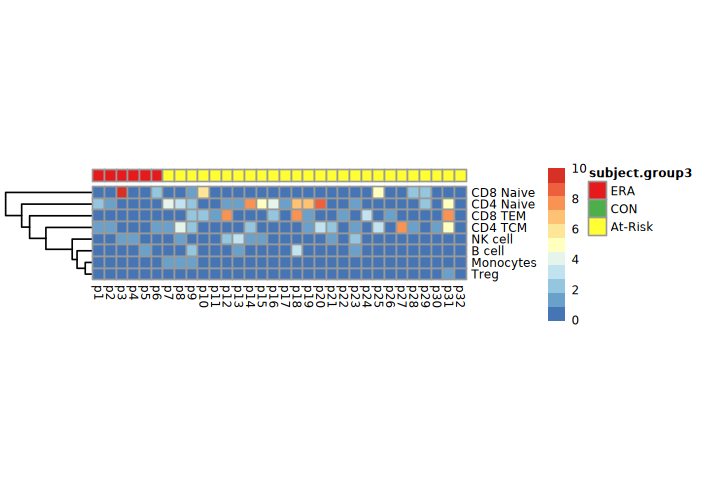

In [45]:
options(repr.plot.width=6, repr.plot.height=4)
print(p2)

In [229]:
# save to file
pdf(paste0("hp_n_clusters_cell_type_across_patients_",tag,".pdf"), height=2, width = 10)
print(p1)
dev.off()

pdf 
  2

In [46]:
# save to file
pdf(paste0("hp_n_clusters_cell_type_across_patients_",tag,"_noCON.pdf"), height=2, width = 6)
print(p2)
dev.off()

pdf 
  2

### for website

We need to transform the heatmap to make it more convenient for visualization. This heatmap includes all the participants including controls

In [61]:
# switch row and column
data_pt <- as.data.frame(t(as.matrix(data_p)))

In [72]:
# get the participant order
pt_orders <- read.csv("heatmap_col_order.csv", row.names = 1) |> mutate(new_sub=1:67) |> mutate(new_id=paste0('p', new_sub)) |> 
    tibble::rownames_to_column('id') |> tibble::column_to_rownames('new_id')
pt_orders

id     subject.group3 new_sub
p1  CU1012 ERA             1     
p2  CU1032 ERA             2     
p3  SD1012 ERA             3     
p4  CU1056 ERA             4     
p5  CU1059 ERA             5     
p6  CU1058 ERA             6     
p7  CU1002 At-Risk         7     
p8  CU1001 At-Risk         8     
p9  CU1004 At-Risk         9     
p10 CU1008 At-Risk        10     
p11 CU1007 At-Risk        11     
p12 CU1003 At-Risk        12     
p13 CU1005 At-Risk        13     
p14 SD1001 At-Risk        14     
p15 CU1009 At-Risk        15     
p16 CU1010 At-Risk        16     
p17 CU1013 At-Risk        17     
p18 CU1019 At-Risk        18     
p19 CU1020 At-Risk        19     
p20 CU1022 At-Risk        20     
p21 CU1021 At-Risk        21     
p22 CU1029 At-Risk        22     
p23 CU1030 At-Risk        23     
p24 CU1031 At-Risk        24     
p25 CU1033 At-Risk        25     
p26 CU1039 At-Risk        26     
p27 SD1006 At-Risk        27     
p28 SD1003 At-Risk        28     
p29 SD1007 At-Risk        29     
p30 CU1034 At-Risk        30     
⋮   ⋮      ⋮              ⋮      
p38 BR1013 CON            38     
p39 BR1034 CON            39     
p40 BR1019 CON            40     
p41 BR1025 CON            41     
p42 BR1024 CON            42     
p43 BR2005 CON            43     
p44 BR2015 CON            44     
p45 BR1031 CON            45     
p46 BR1043 CON            46     
p47 BR2009 CON            47     
p48 BR2010 CON            48     
p49 BR2018 CON            49     
p50 BR2024 CON            50     
p51 BR2021 CON            51     
p52 BR2035 CON            52     
p53 BR2036 CON            53     
p54 BR2034 CON            54     
p55 BR2041 CON            55     
p56 BR2008 CON            56     
p57 CU1077 CON            57     
p58 CU1067 CON            58     
p59 CU1075 CON            59     
p60 CU1066 CON            60     
p61 CU1065 CON            61     
p62 CU1070 CON            62     
p63 CU1072 CON            63     
p64 CU1078 CON            64     
p65 CU1069 CON            65     
p66 CU1064 CON            66     
p67 BR2037 CON            67

In [74]:
# change the participant name
rownames(data_pt) <- rownames(pt_orders)[match(rownames(data_pt), pt_orders$id)]

In [83]:
head(pt_orders)

id     subject.group3 new_sub
p1 CU1012 ERA            1      
p2 CU1032 ERA            2      
p3 SD1012 ERA            3      
p4 CU1056 ERA            4      
p5 CU1059 ERA            5      
p6 CU1058 ERA            6

In [89]:
# only non-CON groups with rows clustered
colors = list(subject.group3 = c('#E41A1C','#4DAF4A','#FFFF33'))
names(colors$subject.group3) = c("ERA","CON","At-Risk")


p1 <- pheatmap::pheatmap(data_pt, filename = 'hp_patients_across_celltypes_n_sig_clusters.pdf', 
                         cellheight = 7, fontsize = 7, cellwidth = 7, 
                         cluster_cols = T, cluster_rows = F,
                         treeheight_col=7,
                         annotation_names_row = FALSE, 
                         annotation_row=pt_orders[,'subject.group3',drop=F], annotation_colors=colors
                        )

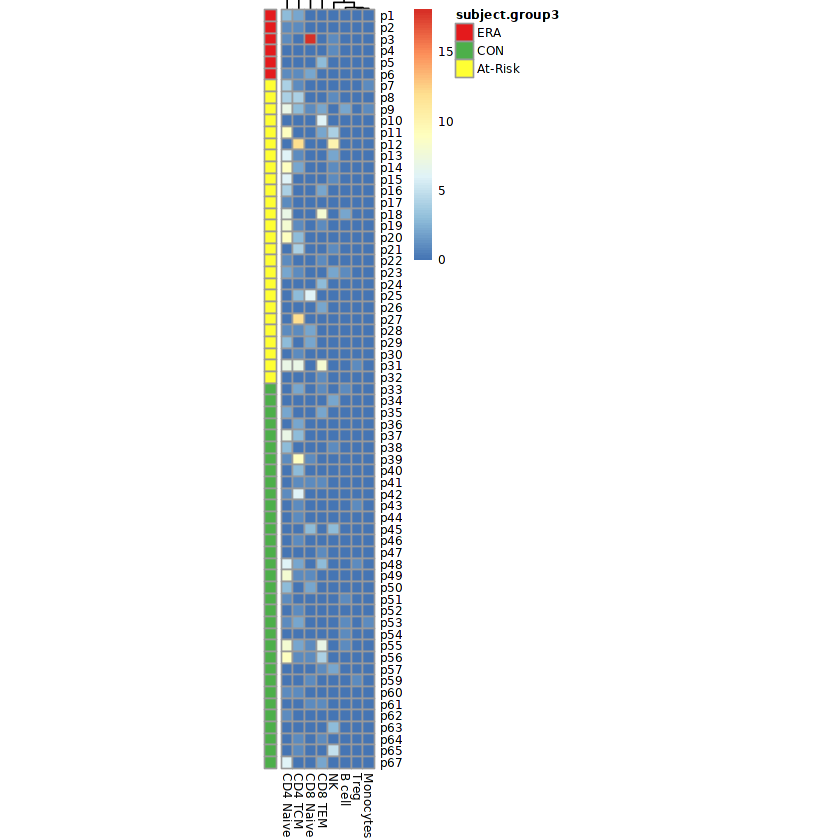

In [90]:
p1

## top signature TFs across cell types

We selected top 40 G2-specific TFs to visualize the mean PageRank scores

In [17]:
TFs <- readLines(paste0(maindir,'/kmeans_5/G2_p0.01_d0.5_gene409_wilcoxon.txt'))[1:100]
TFs

[1] "ZNF304"         "WT1"            "SP9"            "HKR1"          
  [5] "TFAP2C"         "SP5"            "TFAP2B"         "SP7"           
  [9] "PAX7"           "ETV4"           "SP6"            "ZIC1"          
 [13] "PAX4"           "SPZ1"           "TFDP3"          "KLF17"         
 [17] "NFE4"           "ZSCAN10"        "RBPJL"          "CTCFL"         
 [21] "GLIS1"          "ETV3L"          "NKX2-5"         "RFX6"          
 [25] "ZIC2"           "KLF14"          "ZFP42"          "ZNF254"        
 [29] "IRX1"           "VSX2"           "EGR4"           "INSM1"         
 [33] "FOXN1"          "LHX9"           "ZNF534"         "SALL4"         
 [37] "MYOG"           "FOXN4"          "VSX1"           "NEUROD1"       
 [41] "POU3F3"         "POU3F4"         "NR0B1"          "FOXL2"         
 [45] "SPDEF"          "TBX20"          "VAX2"           "ASCL1"         
 [49] "GLIS2"          "SOHLH2"         "PKNOX2"         "SNAI2"         
 [53] "SCRT2"          "CREB3L1"        "BARHL2"         "MYF6"          
 [57] "SIX1"           "PRRX1"          "OVOL1"          "GBX1"          
 [61] "SOX9"           "EN2"            "NKX2-1"         "PAX3"          
 [65] "SOX2"           "ZNF705G"        "LTF"            "VAX1"          
 [69] "HOXD1"          "LHX6"           "EMX1"           "EBF2"          
 [73] "PITX2"          "HAND1"          "PRDM14"         "LHX2"          
 [77] "CCDC169-SOHLH2" "KLF15"          "BARHL1"         "TBX3"          
 [81] "YBX2"           "HNF4A"          "NOBOX"          "HOXD8"         
 [85] "HOXA13"         "HES5"           "ONECUT1"        "NR2E1"         
 [89] "FOXG1"          "TFAP2A"         "GATA4"          "DLX6"          
 [93] "RAX"            "HOXB13"         "FOXD3"          "TEAD4"         
 [97] "SHOX"           "TBX4"           "BCL6B"          "SCRT1"

In [18]:
info <- meta2 %>% mutate(kmeans2 = ifelse(kmeans=="G2", 'G2', "other"))
df <- pr_normed2[TFs,] |> tibble::rownames_to_column('TF') |> tidyr::pivot_longer(cols = !TF,names_to = 'id', values_to = 'value')
df1 <- info %>% dplyr::inner_join(df, by = "id") %>% dplyr::group_by(preClust, TF, kmeans2) %>% dplyr::summarise(mean.value=mean(value)) |> ungroup() |> 
    filter(preClust %in% selected_cell_states) |> dplyr::mutate(group=paste0(preClust,'_',kmeans2))
head(df1)
dim(df1)

`summarise()` has grouped output by 'preClust', 'TF'. You can override using
the `.groups` argument.


preClust       TF     kmeans2 mean.value  group               
1 B intermediate ASCL1  G2      -0.01219466 B intermediate_G2   
2 B intermediate ASCL1  other   -0.03774394 B intermediate_other
3 B intermediate BARHL1 G2      -0.02199495 B intermediate_G2   
4 B intermediate BARHL1 other   -0.02716483 B intermediate_other
5 B intermediate BARHL2 G2      -0.02141816 B intermediate_G2   
6 B intermediate BARHL2 other   -0.02808317 B intermediate_other

[1] 2600    5

In [1372]:
df2 |> filter(TF=='EGR4')
TFs2

TF   G2      other      diff  
1 EGR4 1.22973 -0.3875701 1.6173

[1] "BCL6B"  "CDX1"   "CTCFL"  "EGR4"   "EMX1"   "ETV3L"  "ETV4"   "FOXL2" 
 [9] "FOXN4"  "GLIS2"  "HEYL"   "HKR1"   "KLF14"  "KLF15"  "LHX2"   "LHX6"  
[17] "MYF6"   "MYOG"   "NFE4"   "POU3F3" "PRDM14" "SALL4"  "SCRT1"  "SCRT2" 
[25] "SIX1"   "SOX9"   "SP7"    "SPDEF"  "TBX18"  "TBX3"   "TFAP2A" "VSX2"  
[33] "YBX2"   "ZFP42"  "ZNF177" "ZNF254" "ZNF304"

In [19]:
# second round filtering: diff(G2-other)>0.5
df2 <- df1 |> dplyr::group_by(TF, kmeans2) |> dplyr::summarise(mean2.value=mean(mean.value)) |> 
    tidyr::pivot_wider(names_from = kmeans2, values_from = mean2.value) |> mutate(diff=G2-other) 
TFs2 <- df2 |> filter(diff>0.5) |> pull(TF)

`summarise()` has grouped output by 'TF'. You can override using the `.groups`
argument.


In [20]:
selected_cell_states4 <- c('B memory','CD14 Mono','CD4 Naive','CD8 Naive','CD4 TCM','CD8 TEM','MAIT','NK','Treg')

In [21]:
m <- df1 |> filter(TF %in% TFs2) |> select(TF, mean.value, group) |> tidyr::pivot_wider(names_from = group, values_from = mean.value) %>% tibble::column_to_rownames("TF")
m <- m[,c(paste0(selected_cell_states4,'_G2'), paste0(selected_cell_states4,'_other'))]
head(m)
dim(m)

B memory_G2 CD14 Mono_G2 CD4 Naive_G2 CD8 Naive_G2 CD4 TCM_G2 CD8 TEM_G2
BCL6B 1.3592375   2.5434566    1.4228141    0.9780538    1.1112395  1.1400979 
CTCFL 1.2984348   1.7841723    1.5037561    1.1678028    1.2433022  1.1806670 
EGR4  1.3053651   1.5594422    1.3259263    1.0540384    1.2271191  1.1692233 
EMX1  0.4864556   0.4948484    0.5580947    0.5382158    0.4842672  0.5557955 
ETV3L 1.6976685   2.0783799    1.4779290    1.1346721    1.2557271  1.2951712 
ETV4  1.4216440   1.9285459    1.2065583    0.9065482    1.0300283  1.0483493 
      MAIT_G2   NK_G2     Treg_G2   B memory_other CD14 Mono_other
BCL6B 0.8974760 1.2426956 0.4477548 -0.7183821     -0.41487233    
CTCFL 1.4340372 1.5280633 0.7330931 -0.6843633     -0.66106171    
EGR4  1.3504684 1.3831697 1.8956362 -0.5411164     -0.61831139    
EMX1  0.3669809 0.5963791 0.2141006 -0.3478562     -0.10503244    
ETV3L 1.6225719 1.7320529 0.9304344 -0.6708758     -0.05725234    
ETV4  1.1926369 1.3467843 0.6540281 -0.6333188     -0.51000155    
      CD4 Naive_other CD8 Naive_other CD4 TCM_other CD8 TEM_other MAIT_other
BCL6B -0.2008778      -0.20307228     -0.2890572    -0.4062145    -0.6064286
CTCFL -0.2202234      -0.06467174     -0.2673567    -0.4419105    -0.5490023
EGR4  -0.2191900      -0.07947866     -0.2682410    -0.3991648    -0.4372416
EMX1  -0.1298049      -0.16416011     -0.1826140    -0.1418456    -0.2678176
ETV3L -0.2739780      -0.12058414     -0.3777553    -0.4546300    -0.4266393
ETV4  -0.1952688      -0.14143599     -0.2576860    -0.3739649    -0.3699277
      NK_other   Treg_other
BCL6B -0.5409086 -0.5675878
CTCFL -0.5562904 -0.2773610
EGR4  -0.5362530  0.1005711
EMX1  -0.2343115 -0.1397383
ETV3L -0.5246293 -0.2962719
ETV4  -0.4206887 -0.3244667

[1] 32 18

In [22]:
# set annotation 
annotation_col <- df1 |> distinct(kmeans2, group) |> tibble::column_to_rownames("group")

In [23]:
m[m > 2] <- 2
m[m < -2] <- -2
dim(m)

[1] 32 18

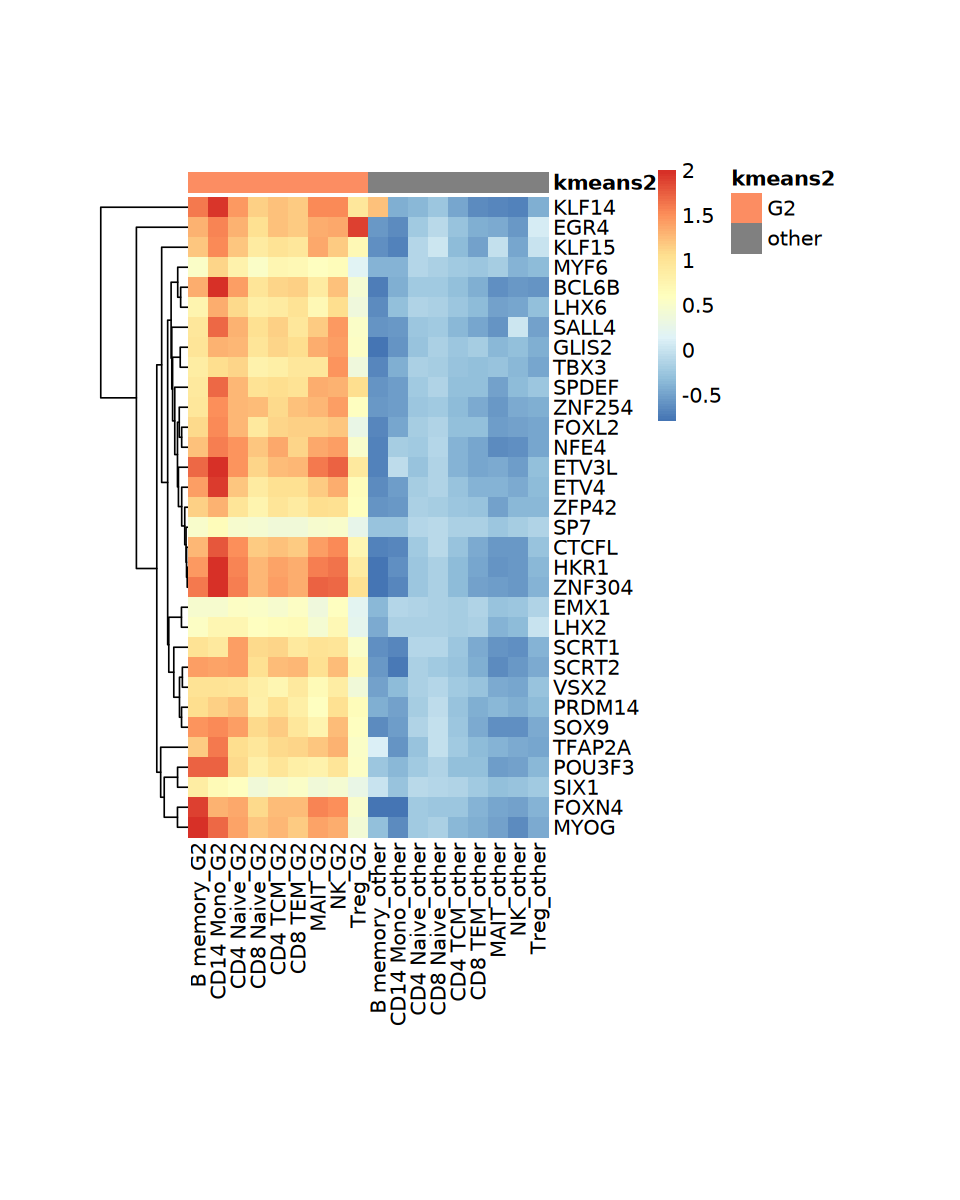

In [24]:
options(repr.plot.width=8, repr.plot.height=10)
p <- pheatmap::pheatmap(m, 
                fontsize = 12, show_rownames = T,
                angle_col = 90, show_colnames = T,
                cluster_cols = F, cluster_rows = T, 
                cellwidth = 12, cellheight = 12,
                clustering_distance_cols = 'correlation', 
                clustering_distance_rows = 'correlation', 
                clustering_method = 'average',
                annotation_col = annotation_col, 
                annotation_colors = mycolors,
                border_color = NA,
                filename = NA)

In [25]:
# save to file
pdf(paste0("mean_pr_top_TFs_across_cell_types",tag,".pdf"), height=10, width = 10)
print(p)
dev.off()

pdf 
  2

# session info

In [610]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] vcd_1.4-13             data.table_1.16.0      pheatmap_1.0.12       
 [4] dplyr_1.1.4            RColorBrewer_1.1-3     ReactomePA_1.46.0     
 [7] enrichplot_1.22.0      clusterProfiler_4.10.1 org.Hs.eg.db_3.18.0   
[10] AnnotationDbi_1.64.1   IRanges_2.36.0         S4Vectors_0.40.2